In [1]:
#%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from IPython.display import Image
from descartes import PolygonPatch
from itertools import combinations, combinations_with_replacement
%matplotlib inline
ox.config(log_console=True, use_cache=True)
%config IPCompleter.greedy=True

import libpysal as lp

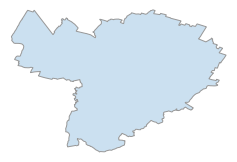

{'init': 'epsg:4326'}


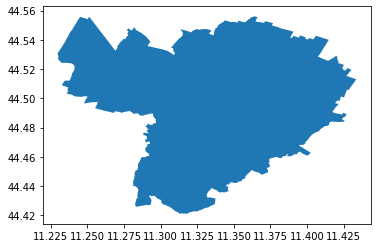

time: 415 ms


In [2]:
city = ox.gdf_from_place('Bologna, Italy')
#city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city, figsize=(4,4))
ox.save_gdf_shapefile(city)
crs = {'init': 'epsg:4326'}
city = city.to_crs(crs)
print(city.crs)
city.plot()

764
data max index: 763
number of NA prices: 0
average bedroom price 57.52883355176933
pointinpoly length: 736
check contains: True
check if there are NAs: False


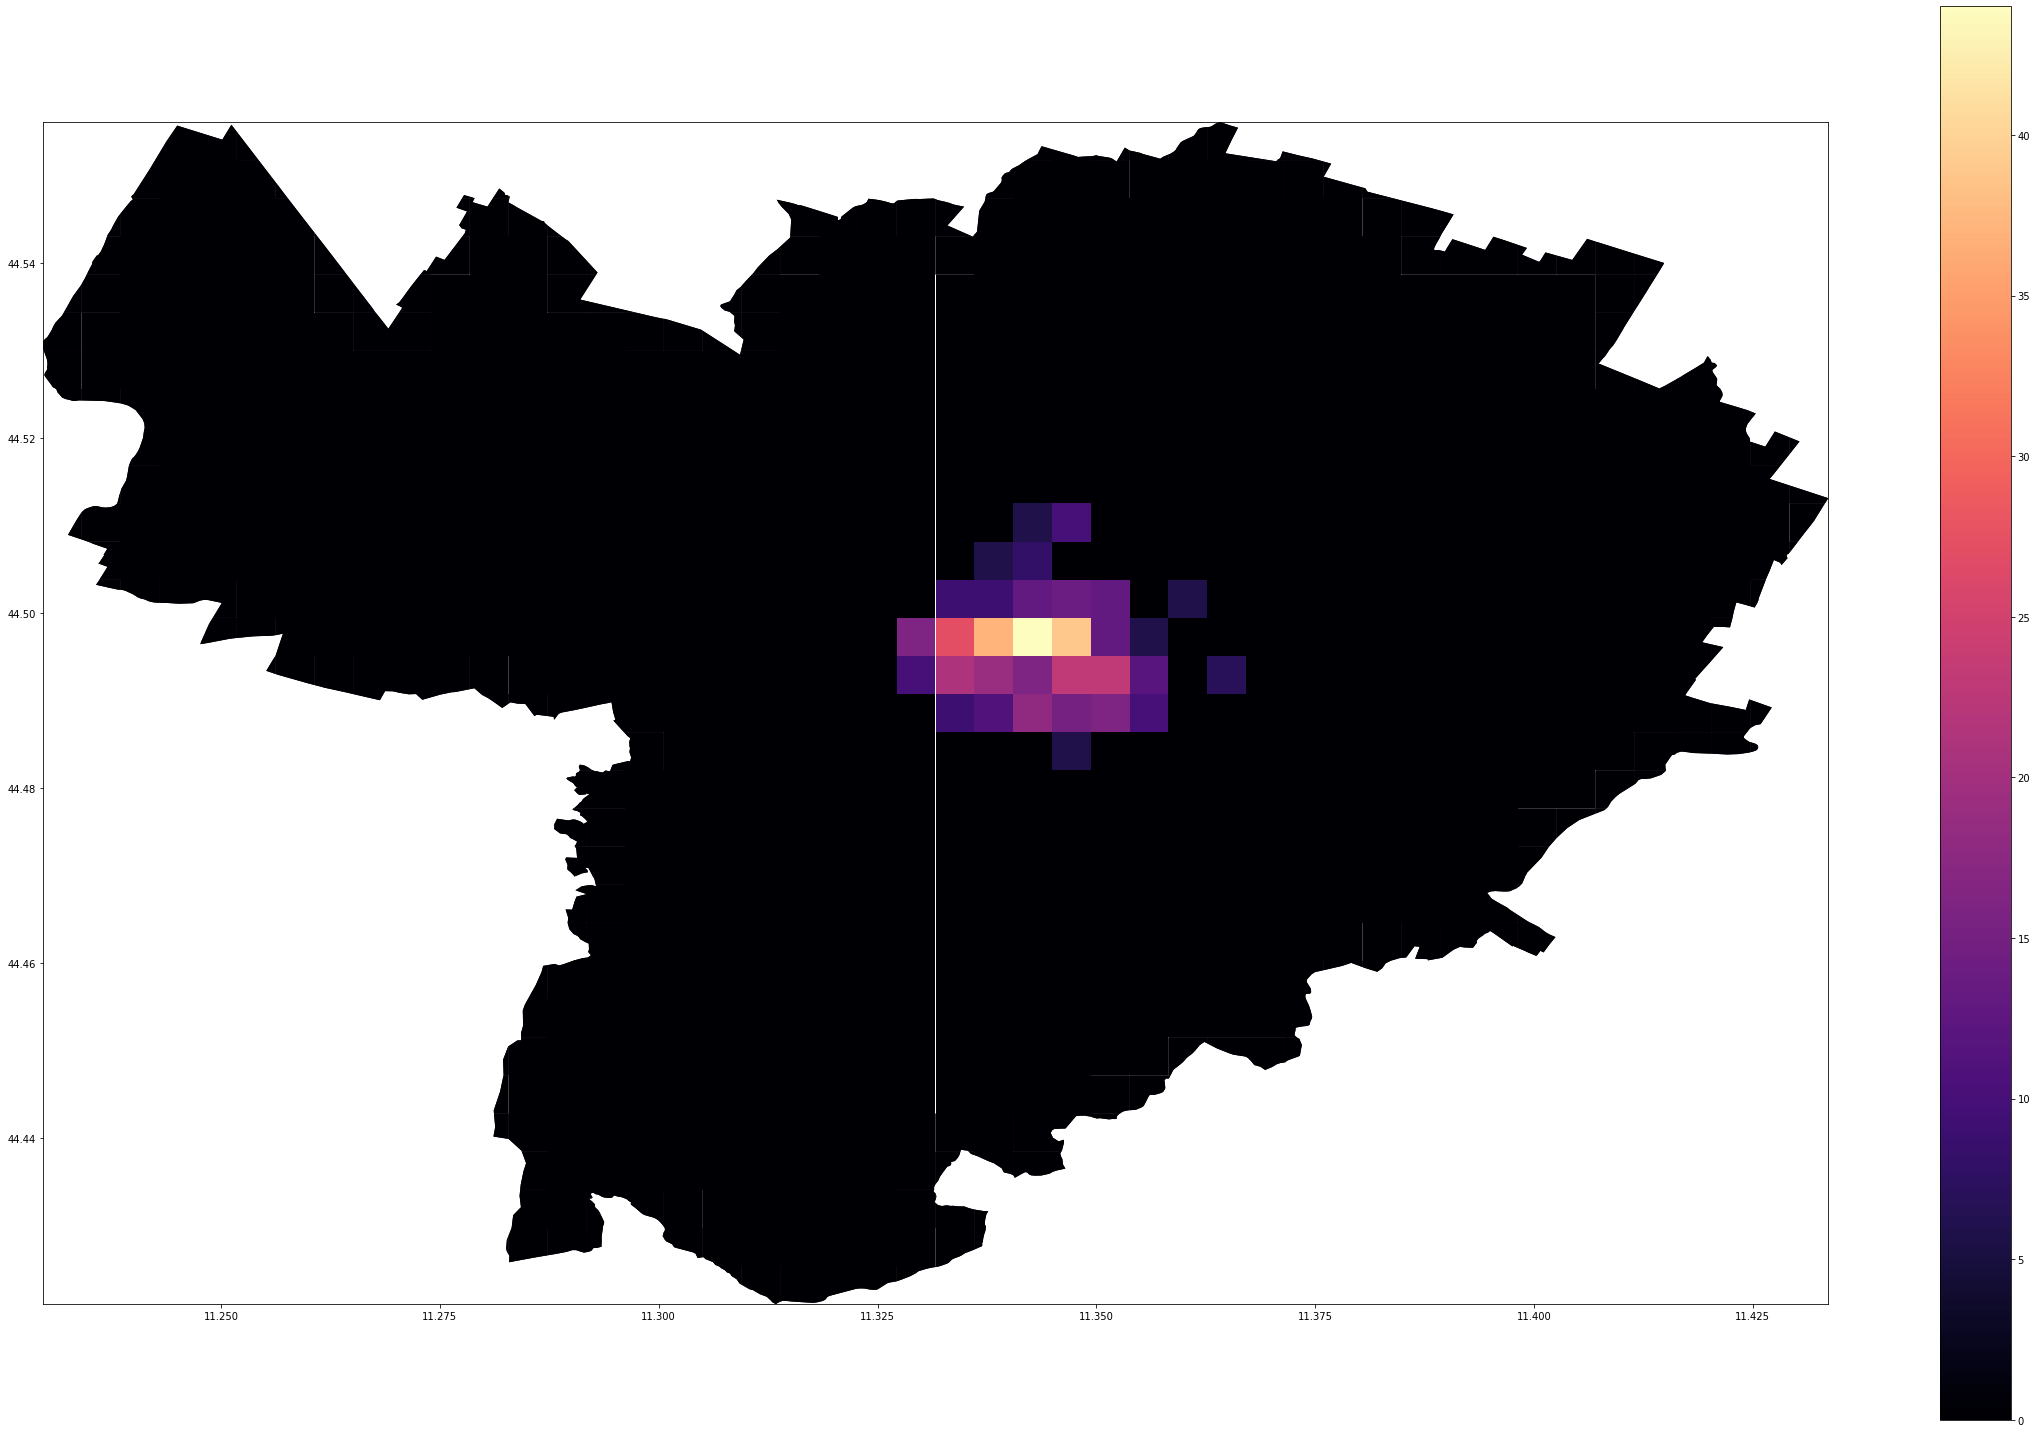

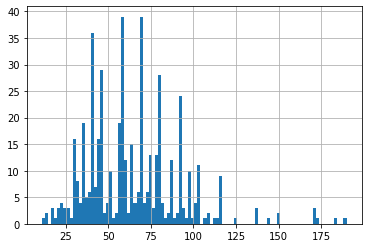

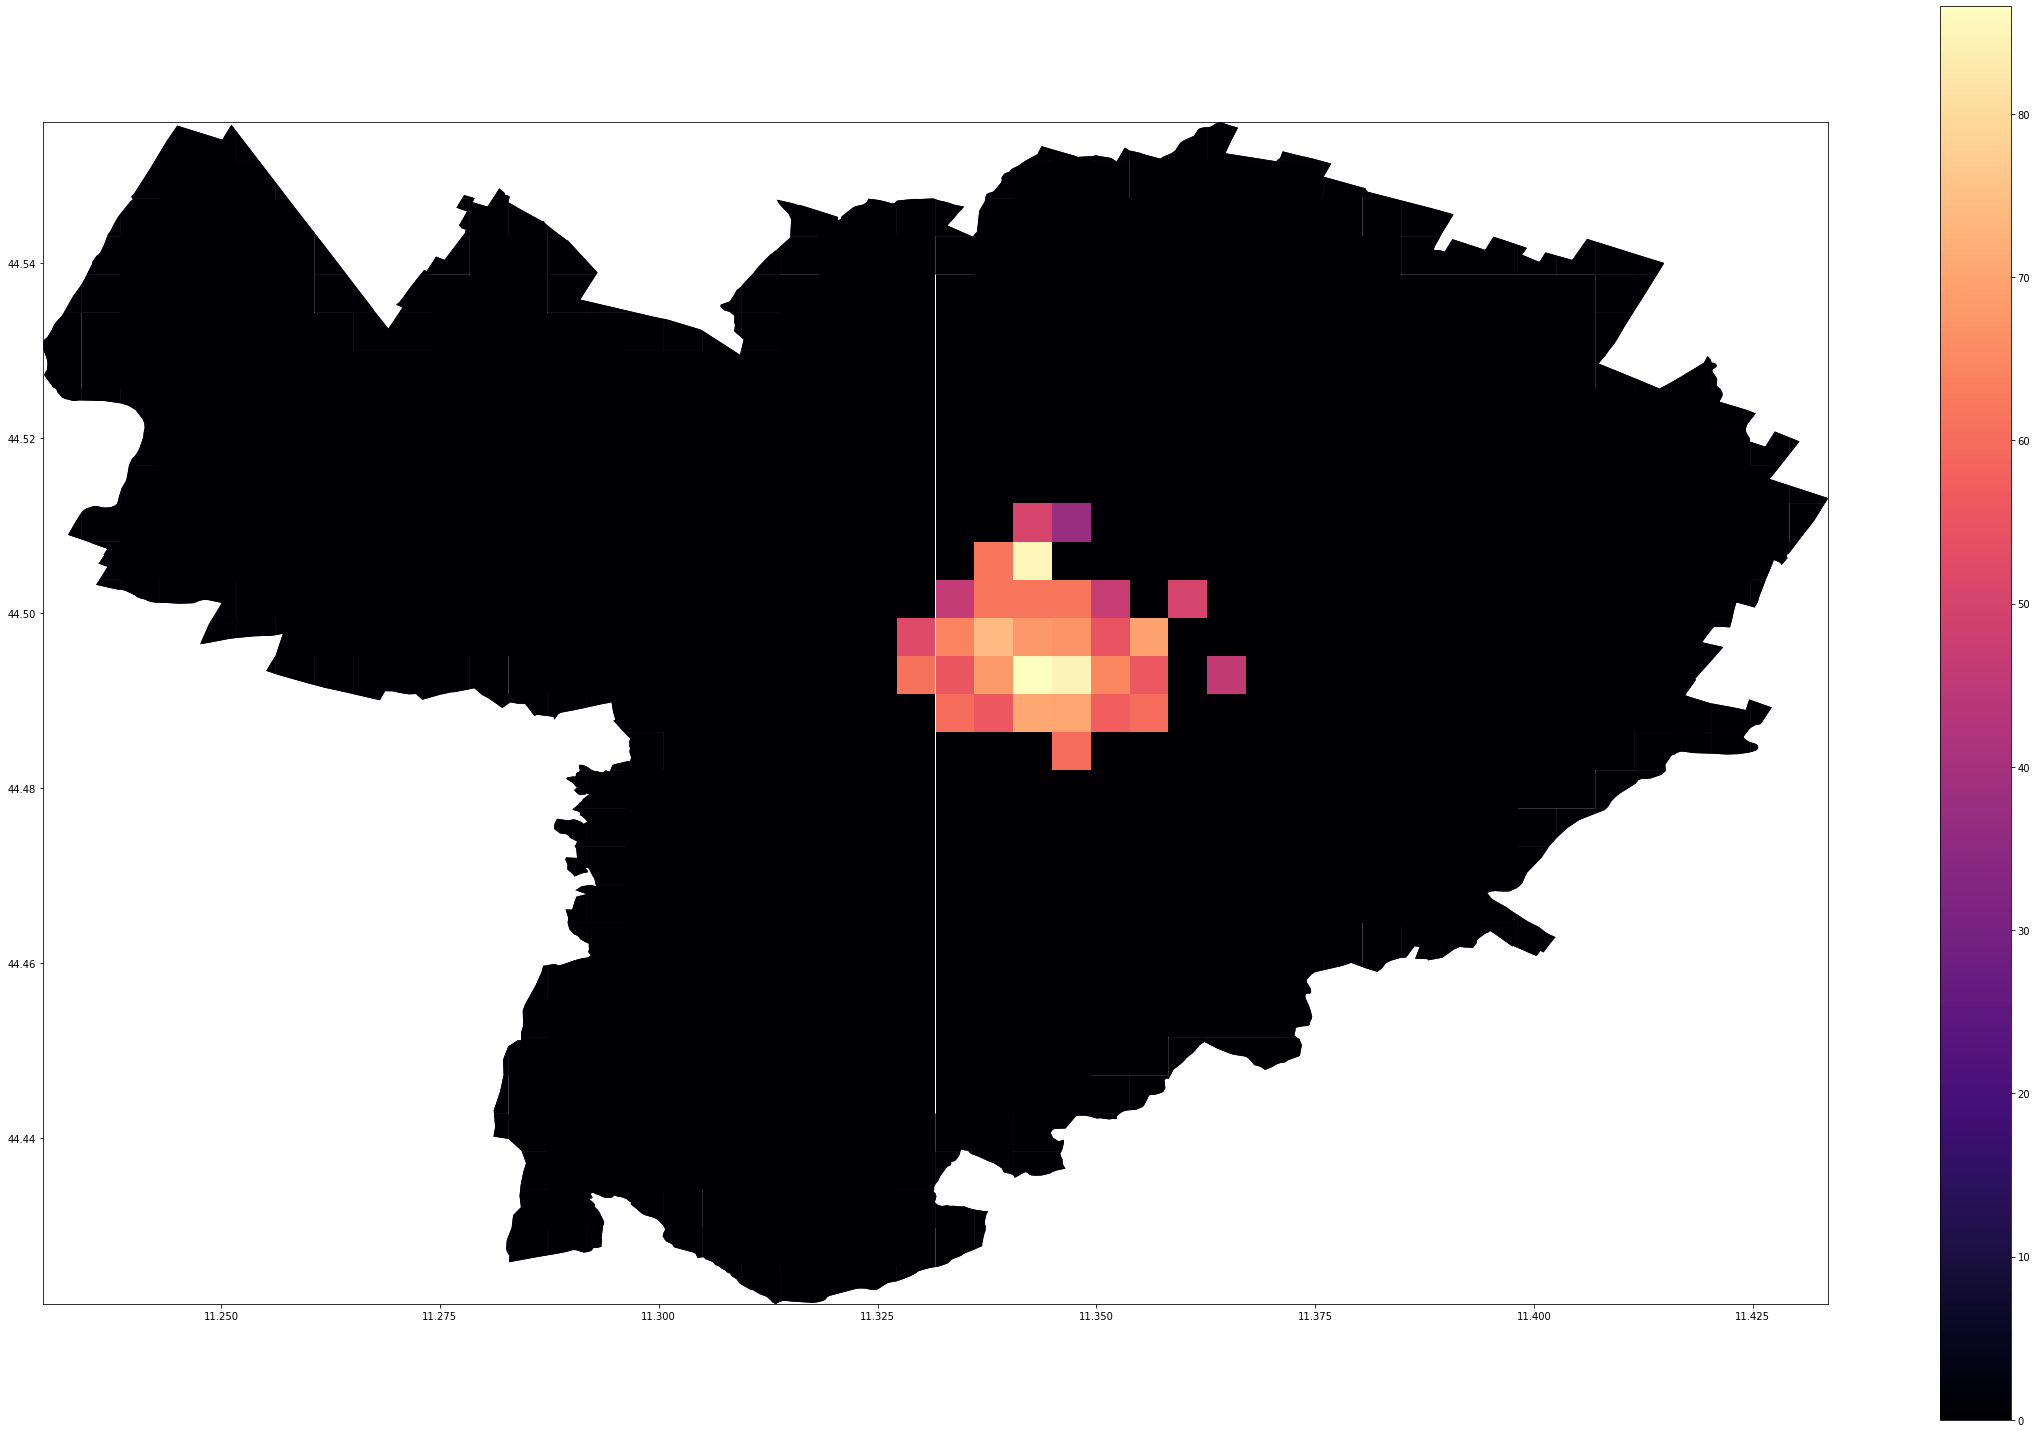

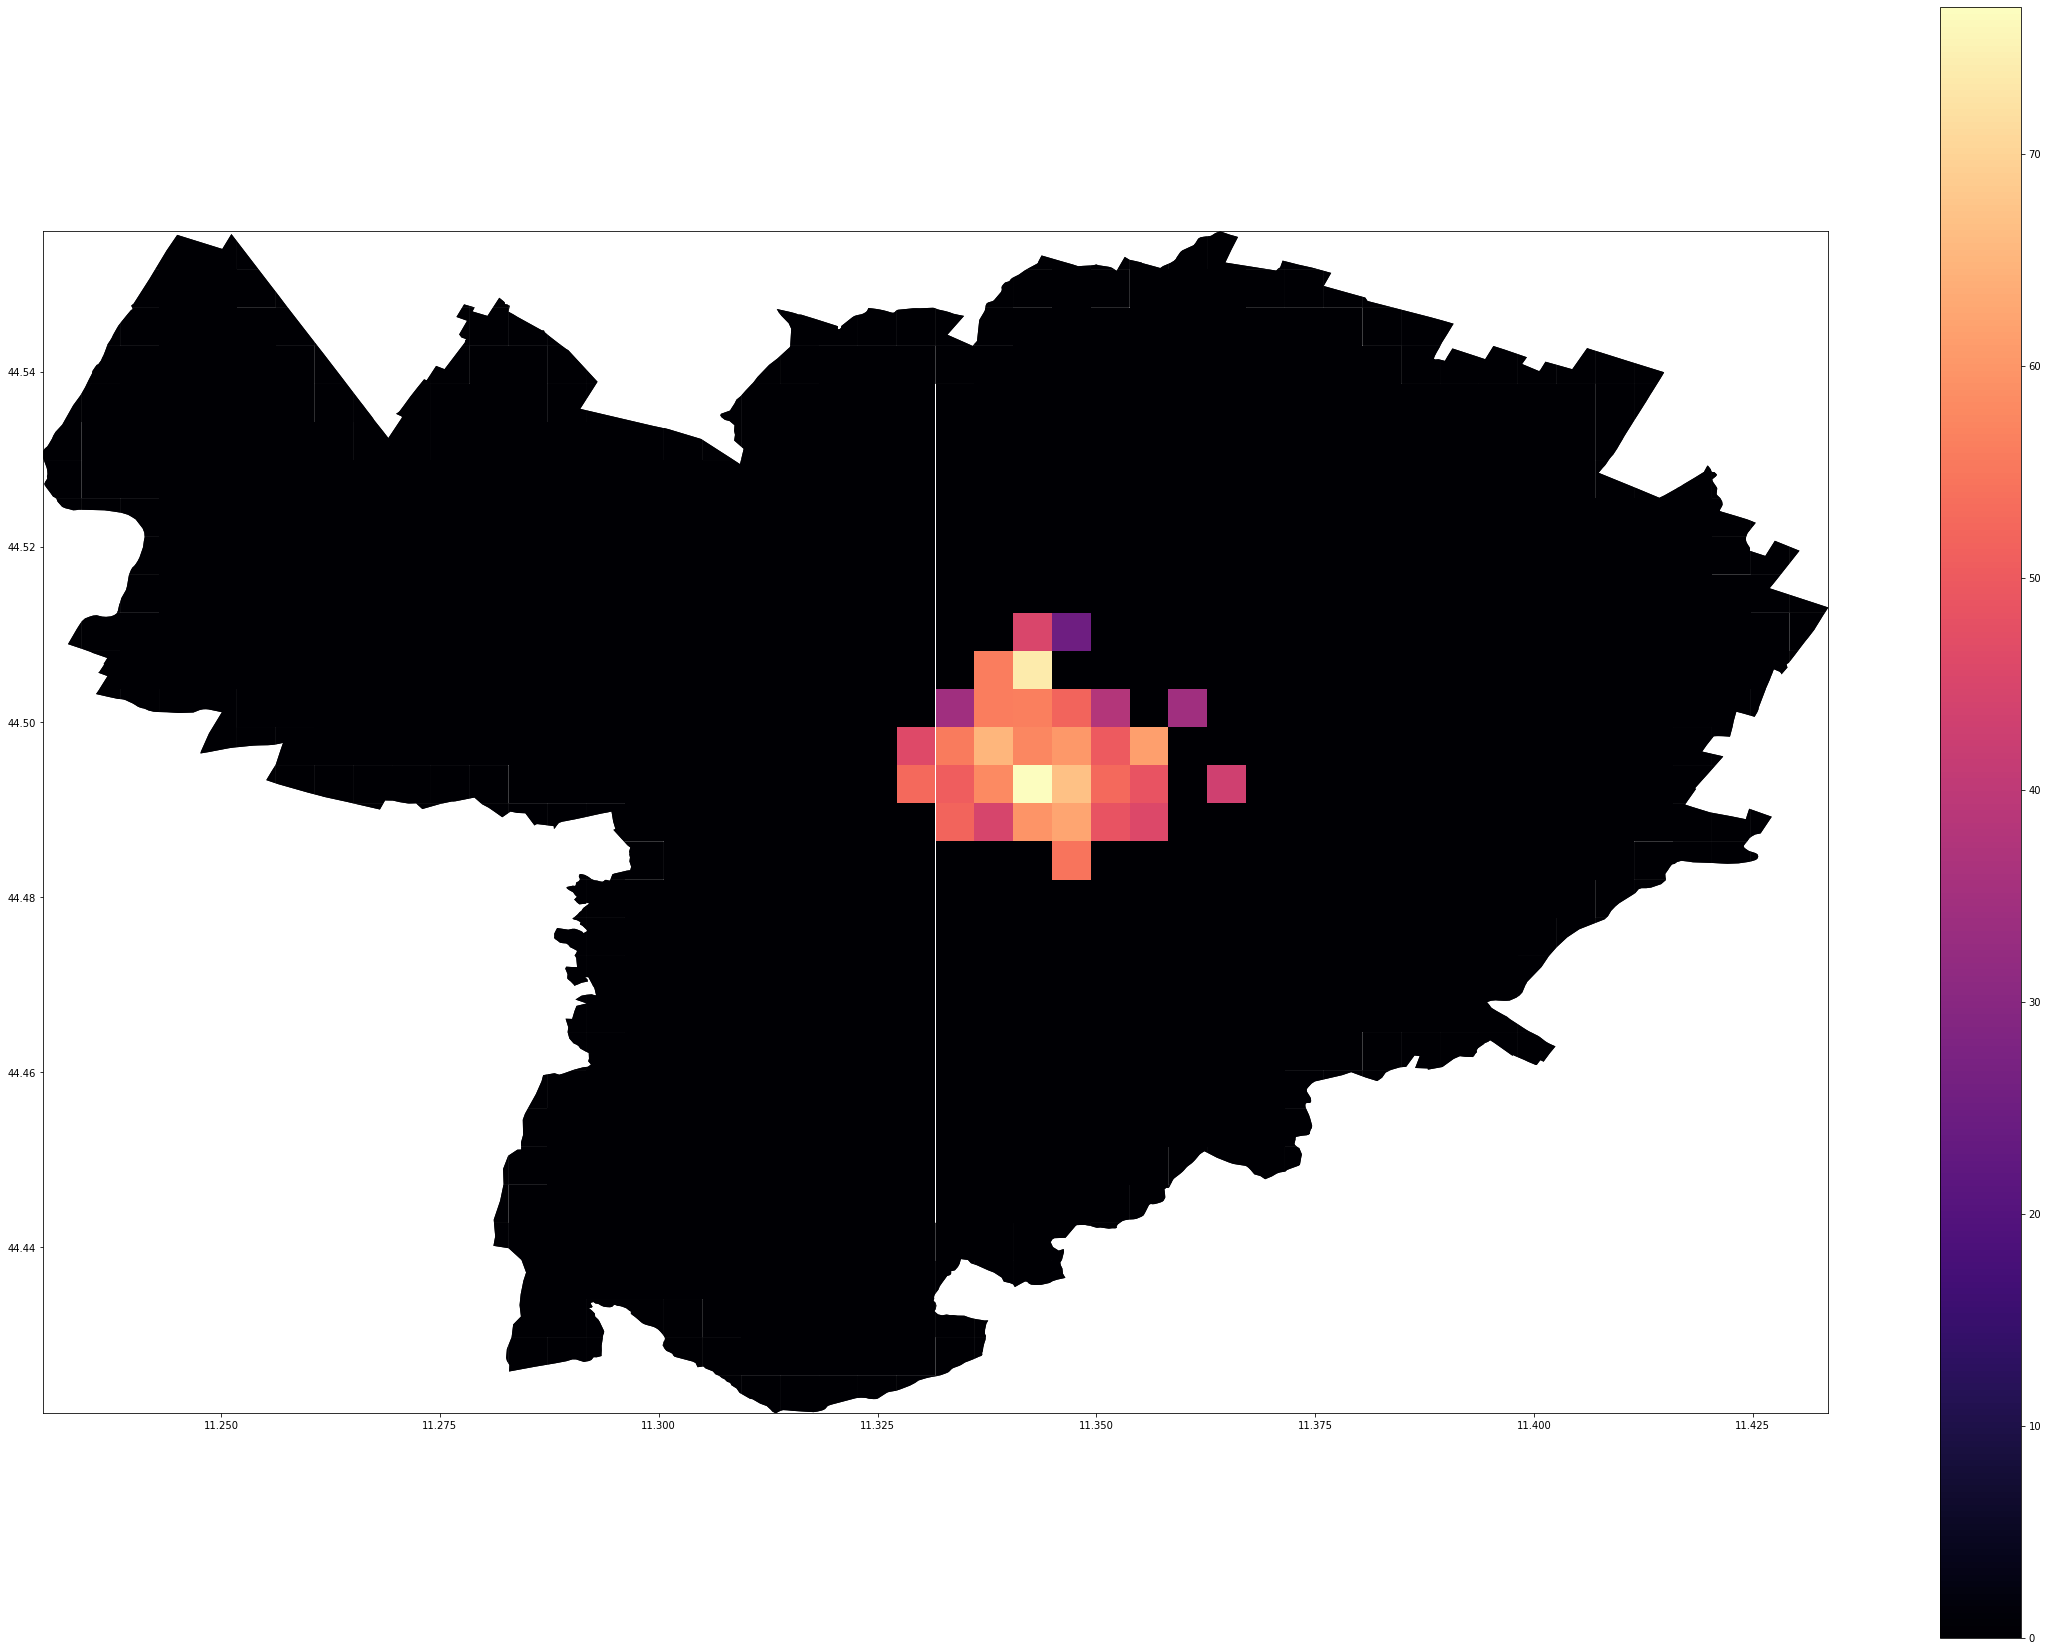

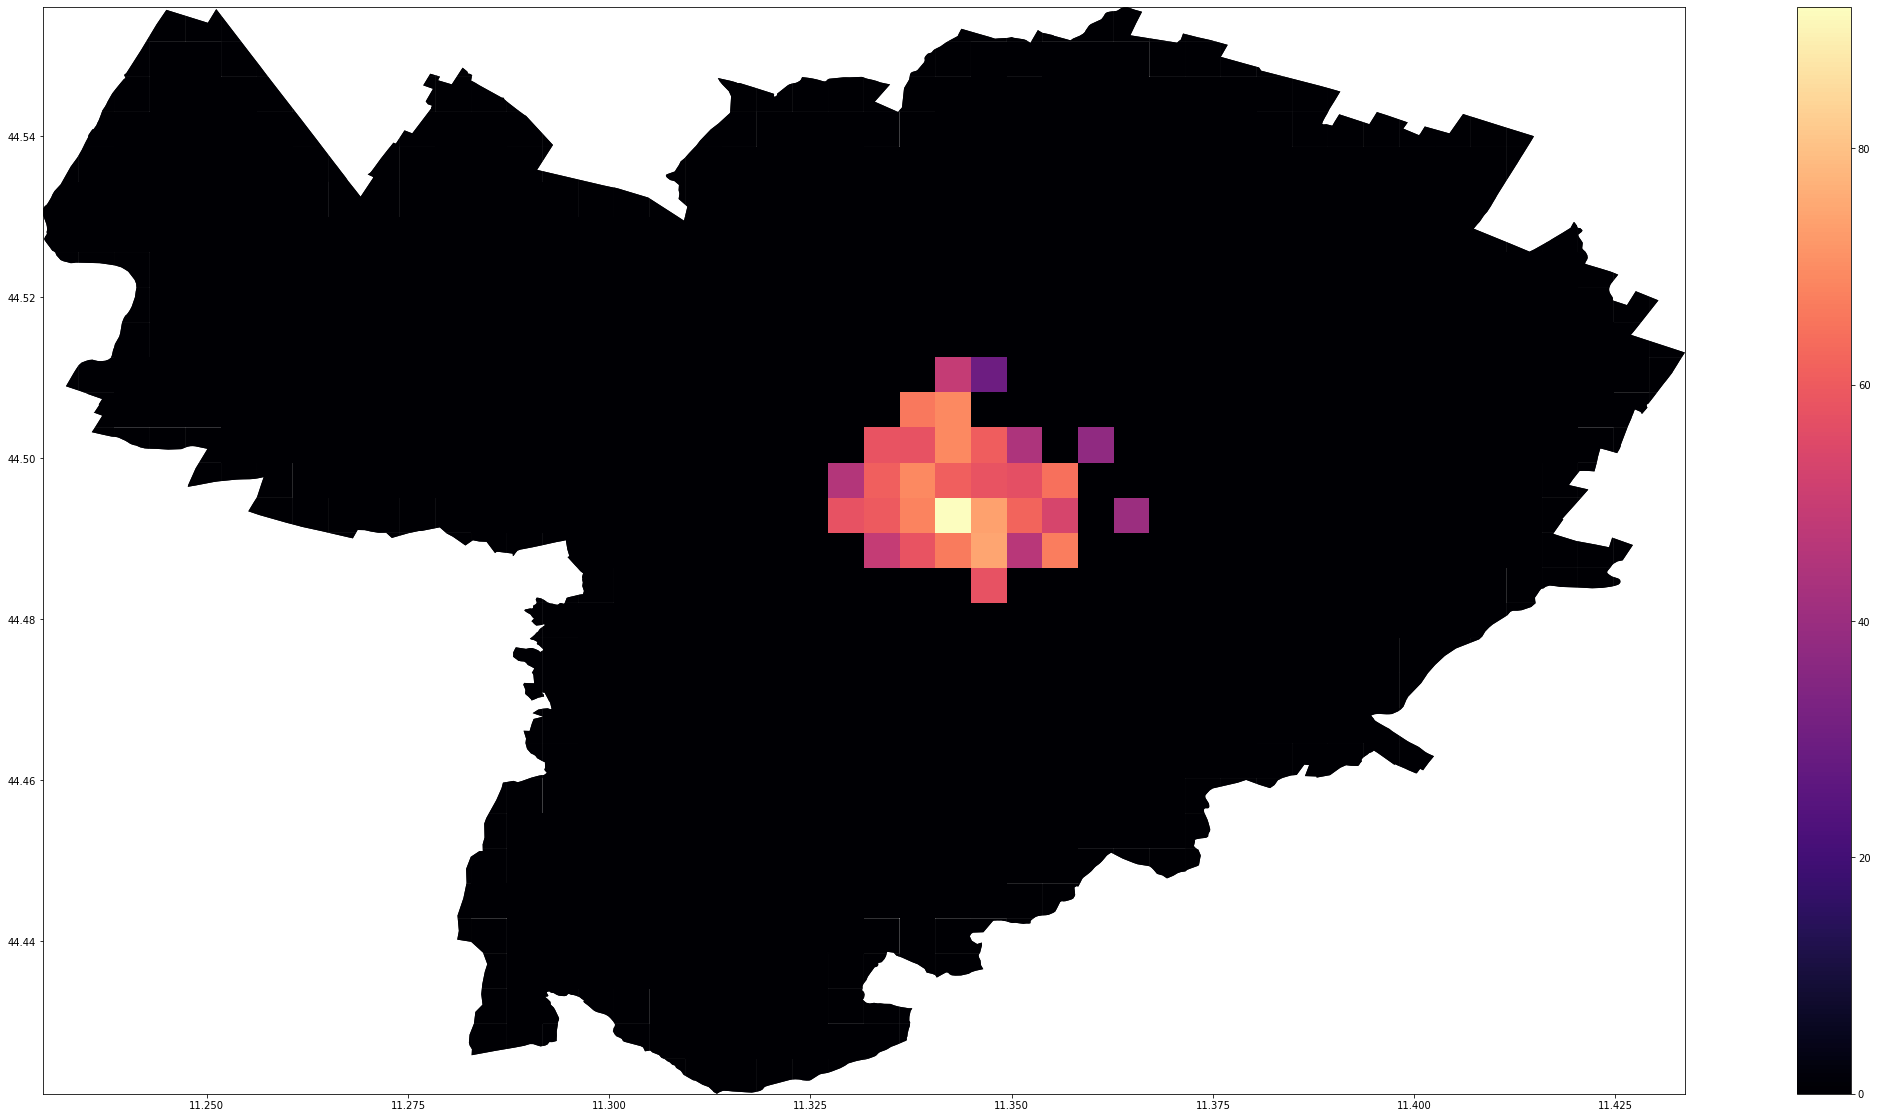

time: 7.06 s


In [3]:
data = pd.read_csv('data/Airbnb_Bologna.csv', header=0, index_col=0)
data = data[['room_id','latitude', 'longitude', 'bedrooms', 'price']]
print(len(data))

data.reset_index(drop=True, inplace=True)
print("data max index:", data.index.max())
print("number of NA prices:", data.price.isna().sum())

data.loc[data.bedrooms == 0, 'bedrooms'] = 1

price_proom = np.divide(np.array(data[pd.notnull(data['bedrooms'])].price),np.array(data[pd.notnull(data['bedrooms'])].bedrooms))
mean_bed = np.mean(price_proom)
print("average bedroom price",mean_bed)

nan_list = data[data.bedrooms.isna()].index.tolist()
data.loc[data.bedrooms.isna(), 'bedrooms'] = np.ceil(data.loc[data.bedrooms.isna(), 'price']/mean_bed)

geometry = [Point(xy) for xy in zip(data.longitude, data.latitude)]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

meter_500 = 0.00899928/2


# make the geometry a multipolygon if it's not already
geometry = city['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
    
# quadrat_width is in the units the geometry is in, so we'll do a tenth of a degree
geometry_cut = ox.quadrat_cut_geometry(geometry, quadrat_width=meter_500)

city['coords'] = city['geometry'].apply(lambda x: x.representative_point().coords[:])
city['coords'] = [coords[0] for coords in city['coords']]

polylist = [p for p in geometry_cut]

polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = city.geometry.crs
polyframe['center_lon'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][0])
polyframe['center_lat'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][1])


pointInPoly = gpd.sjoin(polyframe, gdf, op='contains')
print("pointinpoly length:",len(pointInPoly))

#pointInPoly.sort_values(['PlateID', 'Time'], inplace=True)
pointInPoly['index'] = pointInPoly.index
pointInPoly.reset_index(drop=True, inplace=True)


present_ind = list(pointInPoly['index_right'])
gdf_test_dropped = gdf.iloc[present_ind,:]
gdf_dropped = gdf_test_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)

print("check contains:",polyframe.iloc[pointInPoly.loc[len(pointInPoly)-1, 'index']].geometry.contains(gdf_dropped.loc[len(pointInPoly)-1,'geometry']))
gdf_dropped['pindex'] = pointInPoly['index']

print("check if there are NAs:", gdf_dropped.isna().values.any())

pindex = gdf_dropped.pindex.unique()
airbnb_dict = dict(gdf_dropped.pindex.value_counts())
counts = pd.DataFrame(list(airbnb_dict.items()), columns=['key', 'count'])
counts = counts[counts['count']>5]
counts = counts.copy()
airbnb_dict = dict(zip(list(counts['key']), list(counts['count'])))
polyair = polyframe.copy()
polyair['count'] = 0
polyair['count'].update(pd.Series(airbnb_dict))

# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='count',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


gdf_dropped = gdf_dropped[gdf_dropped.pindex.isin(airbnb_dict.keys())]
gdf_dropped = gdf_dropped.copy()
gdf_dropped = gdf_dropped[gdf_dropped['price'] > 0]
gdf_dropped = gdf_dropped.copy()
gdf_dropped['price_normalized'] = gdf_dropped.price.divide(gdf_dropped.bedrooms)
gdf_dropped = gdf_dropped[gdf_dropped.price_normalized<270]
gdf_dropped = gdf_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)
gdf_dropped.price_normalized.hist(bins=100)

prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].mean())
from scipy import stats
hmean_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].apply(lambda x: stats.hmean(x)))
median_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].median())

polyair['prices'] = 0
polyair['hmean_prices'] = 0
polyair['median_prices'] = 0
polyair['prices'].update(pd.Series(prices_dict))
polyair['hmean_prices'].update(pd.Series(hmean_prices_dict))
polyair['median_prices'].update(pd.Series(median_prices_dict))


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()



# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,30))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='hmean_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


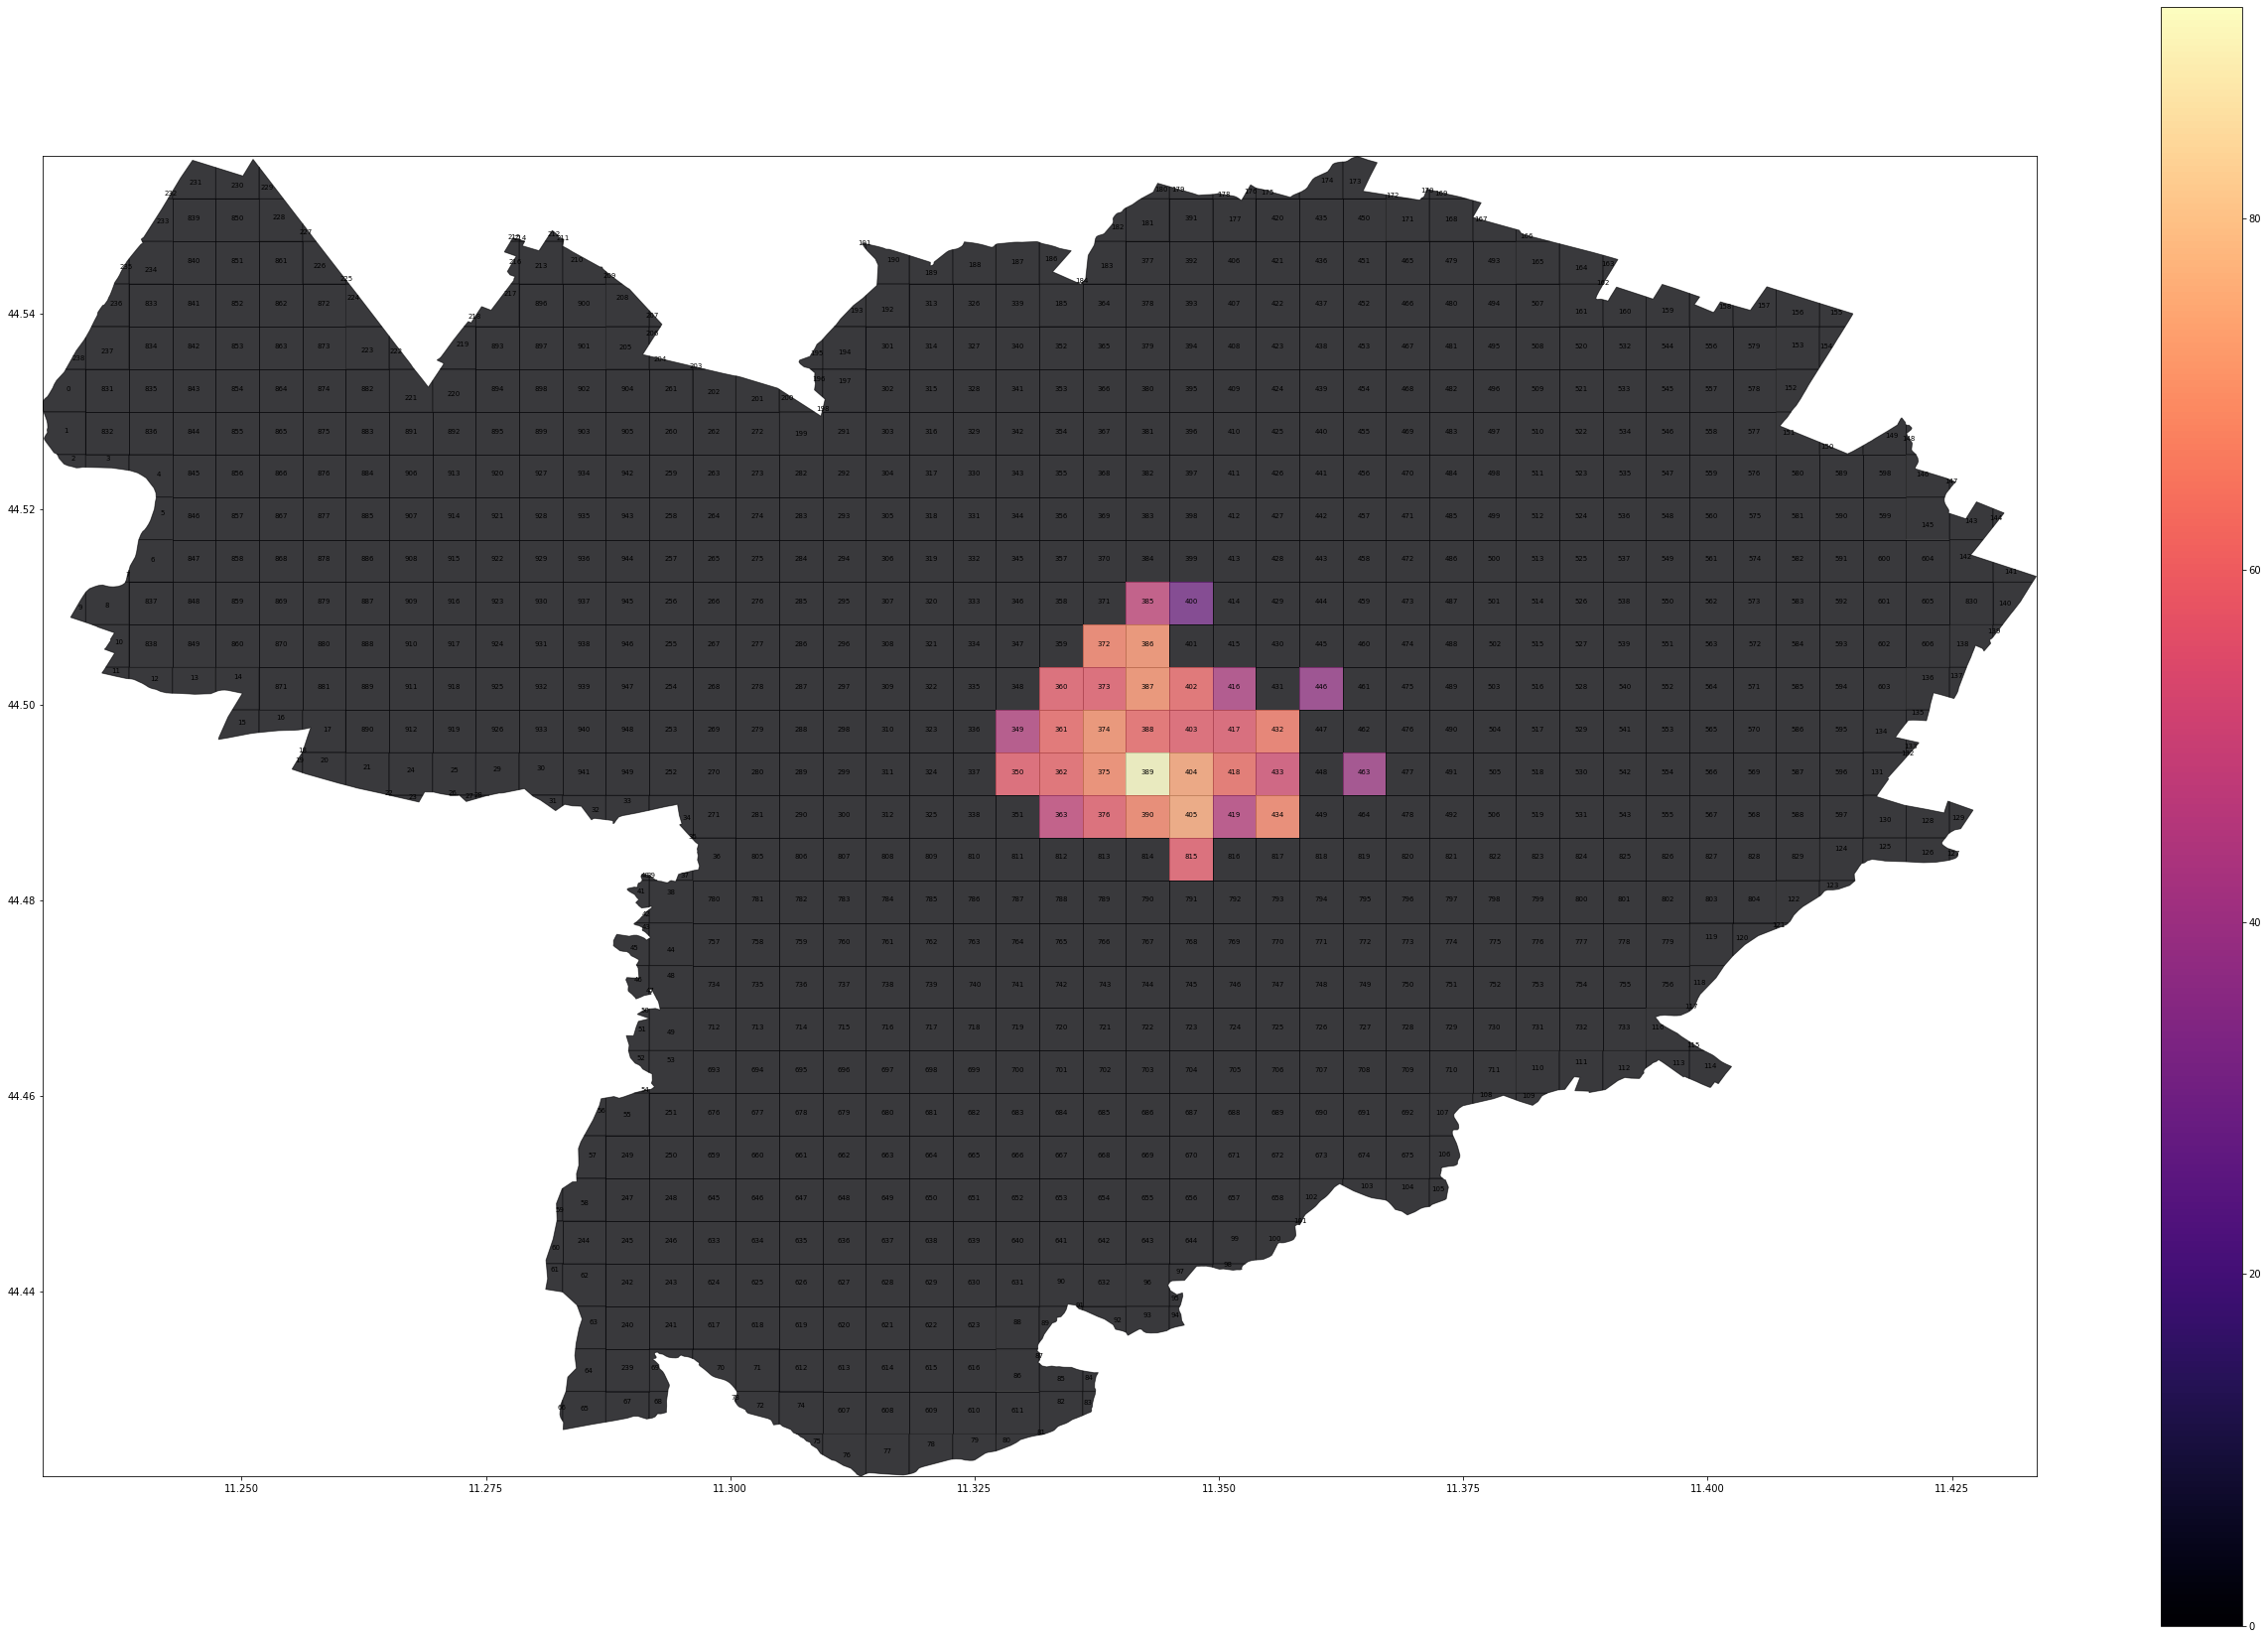

time: 9.16 s


In [4]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(45,30))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5)
    ax.add_patch(patch)
    plt.annotate(s=n, xy=p,
                 horizontalalignment='center', size=7)
polyframe.plot(ax=ax, color='#000004', alpha=0.5)
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax, alpha=0.7, zorder=2)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [5]:
polyair[polyair.median_prices==polyair.median_prices.max()]

geometry  center_lon  \
389  POLYGON ((11.34049500217841 44.49509870967292,...   11.342712   

     center_lat  count    prices  hmean_prices  median_prices  
389    44.49292     16  86.59375     76.924004           92.0

time: 16 ms


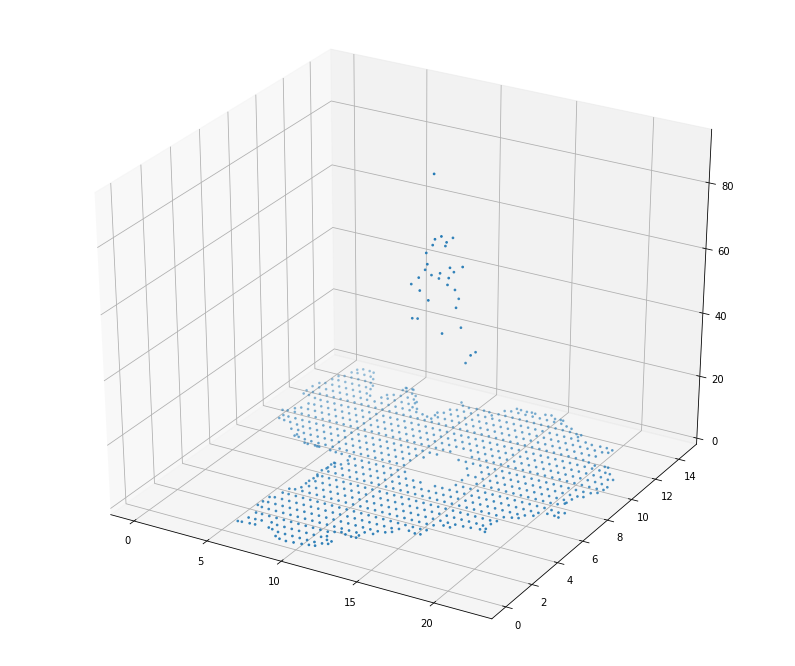

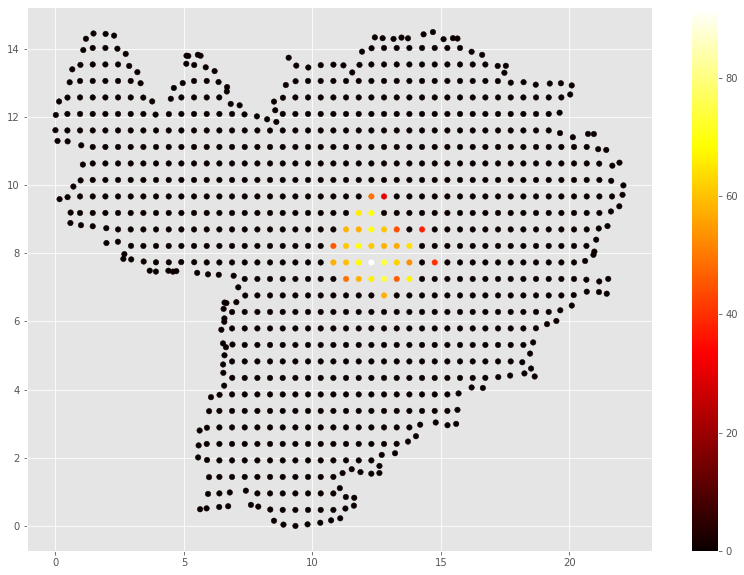

time: 1.72 s


In [6]:
import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
from mpl_toolkits.mplot3d import Axes3D
#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

y = np.array(polyair.center_lat)*500/meter_500 
y = y-y.min()
y = y/1000


# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, np.array(polyair.median_prices), cmap='plasma', s=3)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(30, 300)
plt.show()


plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14,10))
scat = ax.scatter(x, y, c=np.array(polyair.median_prices), s=30, cmap='hot')
cbar = fig.colorbar(scat)
#cbar.set_clim(0, 250)
plt.savefig('images/Bologna_observed.jpg')
plt.show()

In [7]:
cdf = polyair[polyair.index.isin([389])]
cdf["cen_lon_km"] = cdf['center_lon'].apply(lambda x: (x*500/meter_500 - (polyair.center_lon*500/meter_500).min())/1000)
cdf["cen_lat_km"] = cdf['center_lat'].apply(lambda x: (x*500/meter_500 - (polyair.center_lat*500/meter_500).min())/1000)
cdf

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



geometry  center_lon  \
389  POLYGON ((11.34049500217841 44.49509870967292,...   11.342712   

     center_lat  count    prices  hmean_prices  median_prices  cen_lon_km  \
389    44.49292     16  86.59375     76.924004           92.0   12.292206   

     cen_lat_km  
389    7.731734

time: 228 ms


Fitted parameters:
[ 61.96230065  12.39734712   8.00424304   0.86840417   1.23388713
   1.79650577 109.3863506 ]
RMS residual = 3.062079042825288


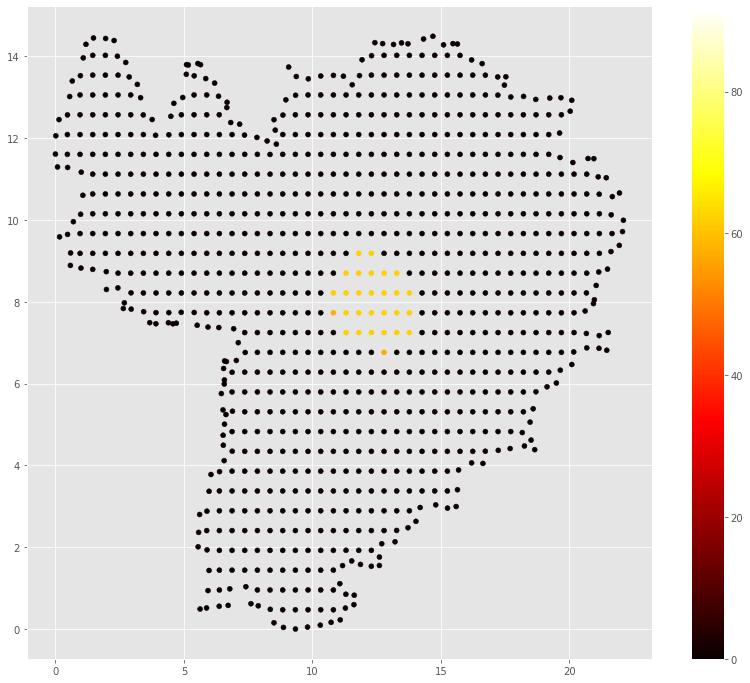

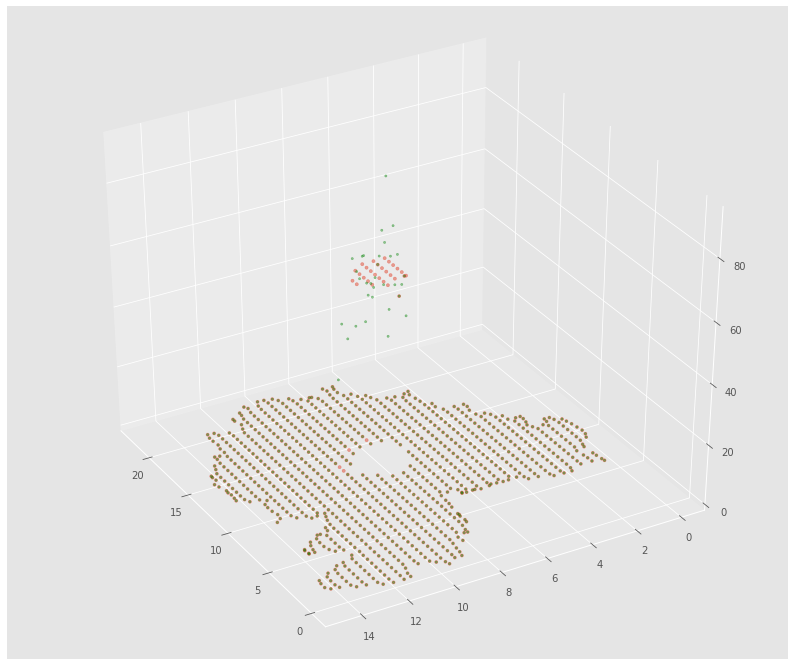

{'Bologna': 109.38635059879002}
time: 1.01 s


In [8]:
alphas = {}
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//7):
        arr += twoD_Gaussian_alpha(xy, *args[i*7:i*7+7])
    return arr




guess_prms = [(80,12.292206,7.731734, 0.7, 1,1.8, 0.5)
#               (75.5,12.667788,7.894592, 4, 3,1.87, 1.8),
#               #(40.75,14.133387,12.332541, 1, 2,0.87),
#               (65,15.598986,8.387698, 1, 1,0.87, 1.5),
#               #(115.16,18.041651,9.867014, 0.5, 1,1.87, 1.1)
             ]

# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian_alpha(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, alpha):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2))**alpha)
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//7):
    zpred += twoD_Gaussian_alpha(xy, *popt[i*7:i*7+7])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=25, cmap='hot')
fig.colorbar(scat)
plt.savefig('Bologna_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=10, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=5, alpha=0.4)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(35, 150)
plt.show()

alphas['Bologna'] = np.mean(popt[6::7])
print(alphas)

In [9]:
import pickle
pickle_in = open("alphas.pickle","rb")
alphas_dict = pickle.load(pickle_in)
#prices_params_dict = {}
alphas_dict['Bologna'] = 1.068635059
print(alphas_dict)
pickle_out = open("alphas.pickle","wb")
pickle.dump(alphas_dict, pickle_out)
pickle_out.close()

{'Paris': 1.9119263949210794, 'Amsterdam': 1.6077156181165682, 'Stockholm': 1.4869621148124246, 'Arezzo': 1.5291330654483044, 'Berlin': 1.3281036059479567, 'Bordeaux': 1.387341915093677, 'Denver': 0.9886695315944182, 'Edinburgh': 1.7431661910906637, 'Lyon': 1.840995035260712, 'Madrid': 1.561423826026336, 'Buenos_Aires': 2.0626361633770363, 'Los_Angeles': 1.7386638625850566, 'Beijing': 1.77233254047711, 'Florence': 1.052999973906332, 'Moscow': 1.822610958759147, 'Porto': 1.4172416677632145, 'Prague': 1.3671832768992007, 'Reykjavik': 1.4194582940670377, 'Riga': 1.4587192546215861, 'Rome': 1.8608390724186512, 'Seoul': 1.3208669147673713, 'Siena': 0.6212787996336754, 'Sydney': 2.584174464016137, 'Tallin': 2.014994948135572, 'Treviso': 1.07320426583068, 'Valencia': 1.5432619, 'Venezia': 1.3156028460923, 'Verona': 1.4364606330705336, 'Vicenza': 1.20971848439062, 'Vienna': 1.3399164167136137, 'Wellington': 1.46363348, 'Zurich': 1.72383878, 'Aarhus': 1.87621535, 'Milan': 2.1468310347956194, 'B

Fitted parameters:
[91.70376883 12.38126476  8.00587316  0.78999495  1.07243229  1.81306414]
RMS residual = 4.759979942196996


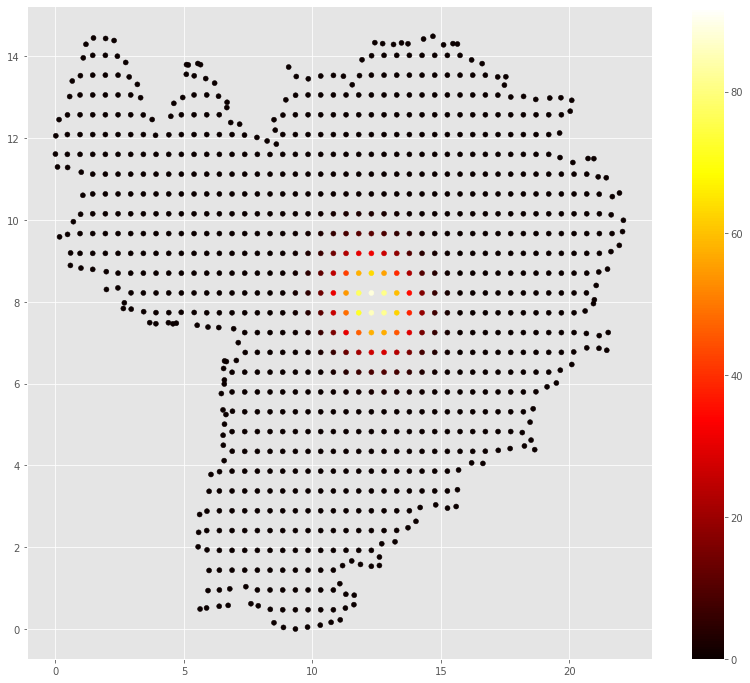

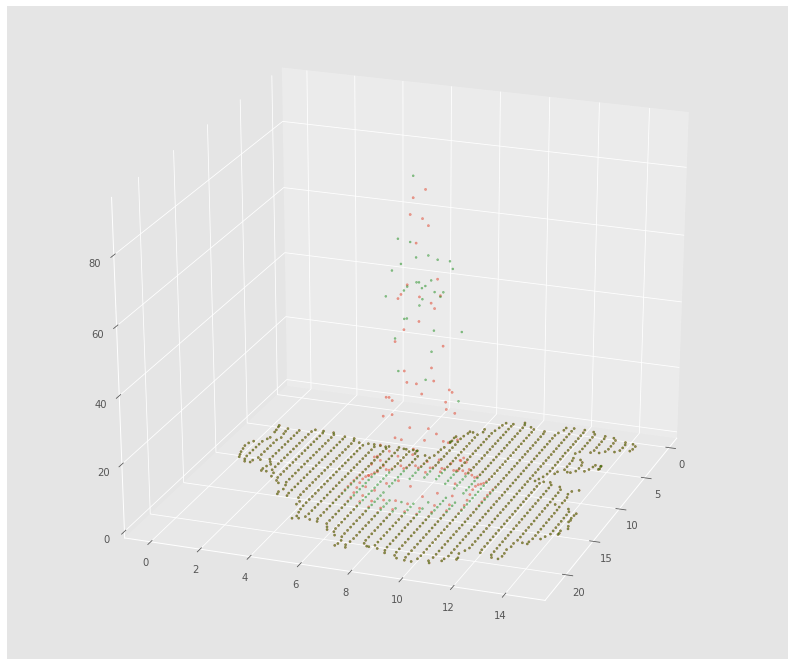

time: 953 ms


In [10]:
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//6):
        arr += twoD_Gaussian(xy, *args[i*6:i*6+6])
    return arr



guess_prms = [(92,12.292206,7.731734, 2, 3,1.5)
#               (75.5,12.667788,7.894592, 4, 3,1.87, 1.8),
#               #(40.75,14.133387,12.332541, 1, 2,0.87),
#               (65,15.598986,8.387698, 1, 1,0.87, 1.5),
#               #(115.16,18.041651,9.867014, 0.5, 1,1.87, 1.1)
             ]

# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//6):
    zpred += twoD_Gaussian(xy, *popt[i*6:i*6+6])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=25, cmap='hot')
fig.colorbar(scat)
plt.savefig('Bologna_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=5, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=4, alpha=0.4)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(25, 20)
plt.show()

In [11]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

sqrt_eigs_long = np.array([])
sqrt_eigs_short = np.array([])
for i in range(0, len(popt), 6):
    a = (np.cos(popt[i+5])**2)/(2*popt[i+3]**2) + (np.sin(popt[i+5])**2)/(2*popt[i+4]**2)
    b = -(np.sin(2*popt[i+5]))/(4*popt[i+3]**2) + (np.sin(2*popt[i+5]))/(4*popt[i+4]**2)
    c = (np.sin(popt[i+5])**2)/(2*popt[i+3]**2) + (np.cos(popt[i+5])**2)/(2*popt[i+4]**2)
    cov = np.array([a, b, b, c]).reshape(-1, 2)
    print("Is cov_{} positive definite?: ".format(i//6+1), is_pos_def(cov))
    eigenvalues = np.linalg.eigvals(cov)
    eigenvalues = eigenvalues[eigenvalues>0]
    if eigenvalues.size!=0:
        stds = np.sqrt(eigenvalues)/popt[i]
        #stds = stds[stds>=0]
        sqrt_eigs_long = np.append(sqrt_eigs_long,max(stds))
        sqrt_eigs_short = np.append(sqrt_eigs_short,min(stds))

print('long stds: ', sqrt_eigs_long, 'mean: ', np.mean(sqrt_eigs_long))
print('short stds: ', sqrt_eigs_short, 'mean: ', np.mean(sqrt_eigs_short))

Is cov_1 positive definite?:  True
long stds:  [0.00976053] mean:  0.00976053228522521
short stds:  [0.00718998] mean:  0.0071899842054552
time: 5.99 ms


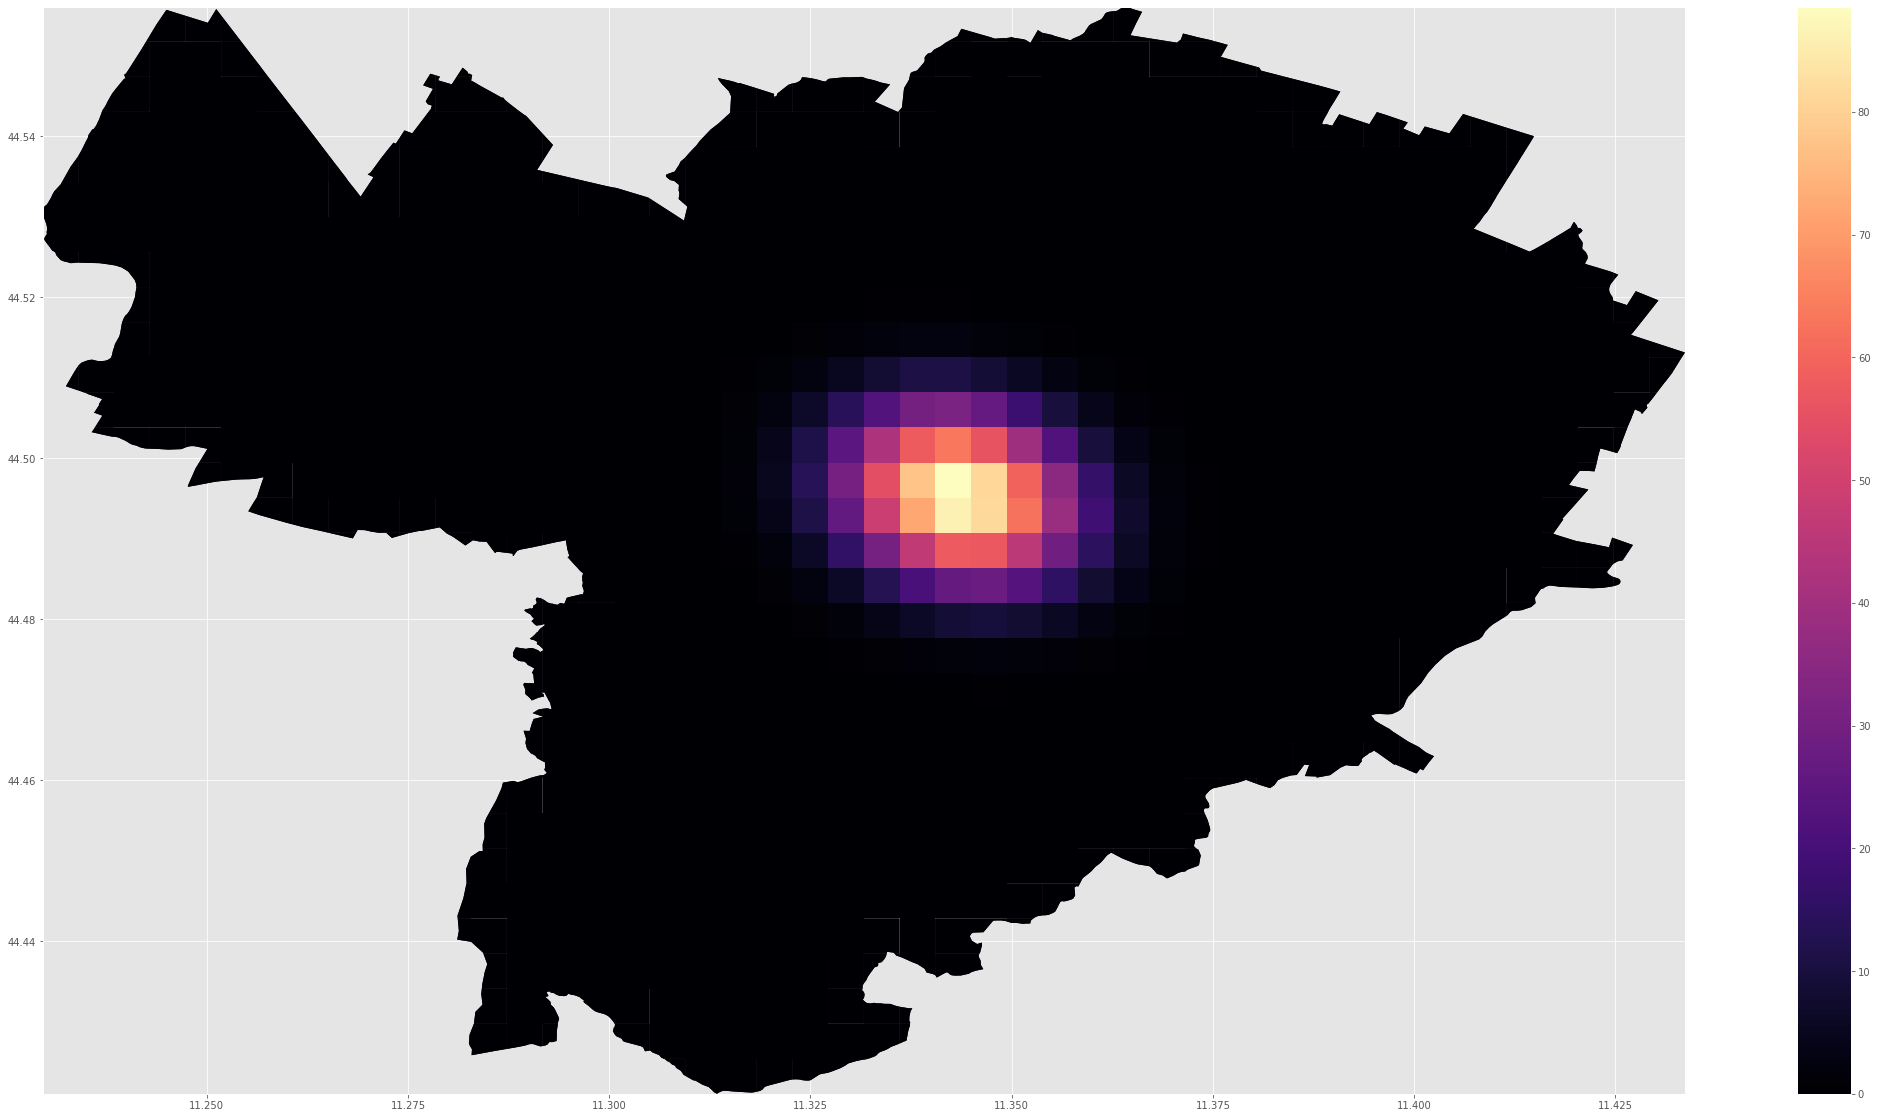

time: 1.35 s


In [12]:
polyair['zpred'] = zpred
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='zpred',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [13]:
import pickle
pickle_in = open("Prices_params.pickle","rb")
prices_params_dict = pickle.load(pickle_in)
#prices_params_dict = {}
prices_params_dict['Bologna'] = popt
pickle_out = open("Prices_params.pickle","wb")
pickle.dump(prices_params_dict, pickle_out)
pickle_out.close()

#average_slopes = {}
pickle_in_long = open("Average_price_slopes_long.pickle","rb")
average_slopes_long = pickle.load(pickle_in_long)
average_slopes_long['Bologna'] = np.mean(sqrt_eigs_long)
pickle_out_long = open("Average_price_slopes_long.pickle","wb")
pickle.dump(average_slopes_long, pickle_out_long)
pickle_out_long.close()

pickle_in_short = open("Average_price_slopes_short.pickle","rb")
average_slopes_short = pickle.load(pickle_in_short)
average_slopes_short['Bologna'] = np.mean(sqrt_eigs_short)
pickle_out_short = open("Average_price_slopes_short.pickle","wb")
pickle.dump(average_slopes_short, pickle_out_short)
pickle_out_short.close()

print('long: ', average_slopes_long, '\n', '\n', ' short: ', average_slopes_short)

long:  {'Paris': 0.010453121182320417, 'Amsterdam': 0.017790862401138207, 'Stockholm': 0.01160078748441716, 'Arezzo': 0.012661960610292892, 'Berlin': 0.017168942092868542, 'Bordeaux': 0.0057209390468692745, 'Denver': 0.00873766709683174, 'Edinburgh': 0.012921100209712873, 'Lyon': 0.00594530194011358, 'Madrid': 0.01315080289968449, 'Buenos_Aires': 0.00938788752473718, 'Palermo': 0.02659431146972356, 'Los_Angeles': 0.0056655377791732745, 'Beijing': 0.03548021455387483, 'Florence': 0.011913882705309832, 'Moscow': 0.026524810524746, 'Porto': 0.03745056113103571, 'Prague': 0.01850581507565583, 'Reykjavik': 0.04000475004839031, 'Riga': 0.02150786435094239, 'Rome': 0.009635062558537275, 'Seoul': 0.013154650694260608, 'Siena': 0.013838139160990736, 'Sydney': 0.009200022664460229, 'Tallin': 0.024848430854086192, 'Treviso': 0.015264513943951563, 'Valencia': 0.01982718757582555, 'Venezia': 0.013133572970121148, 'Verona': 0.01119208328282184, 'Vicenza': 0.029546407262138693, 'Vienna': 0.0120270170

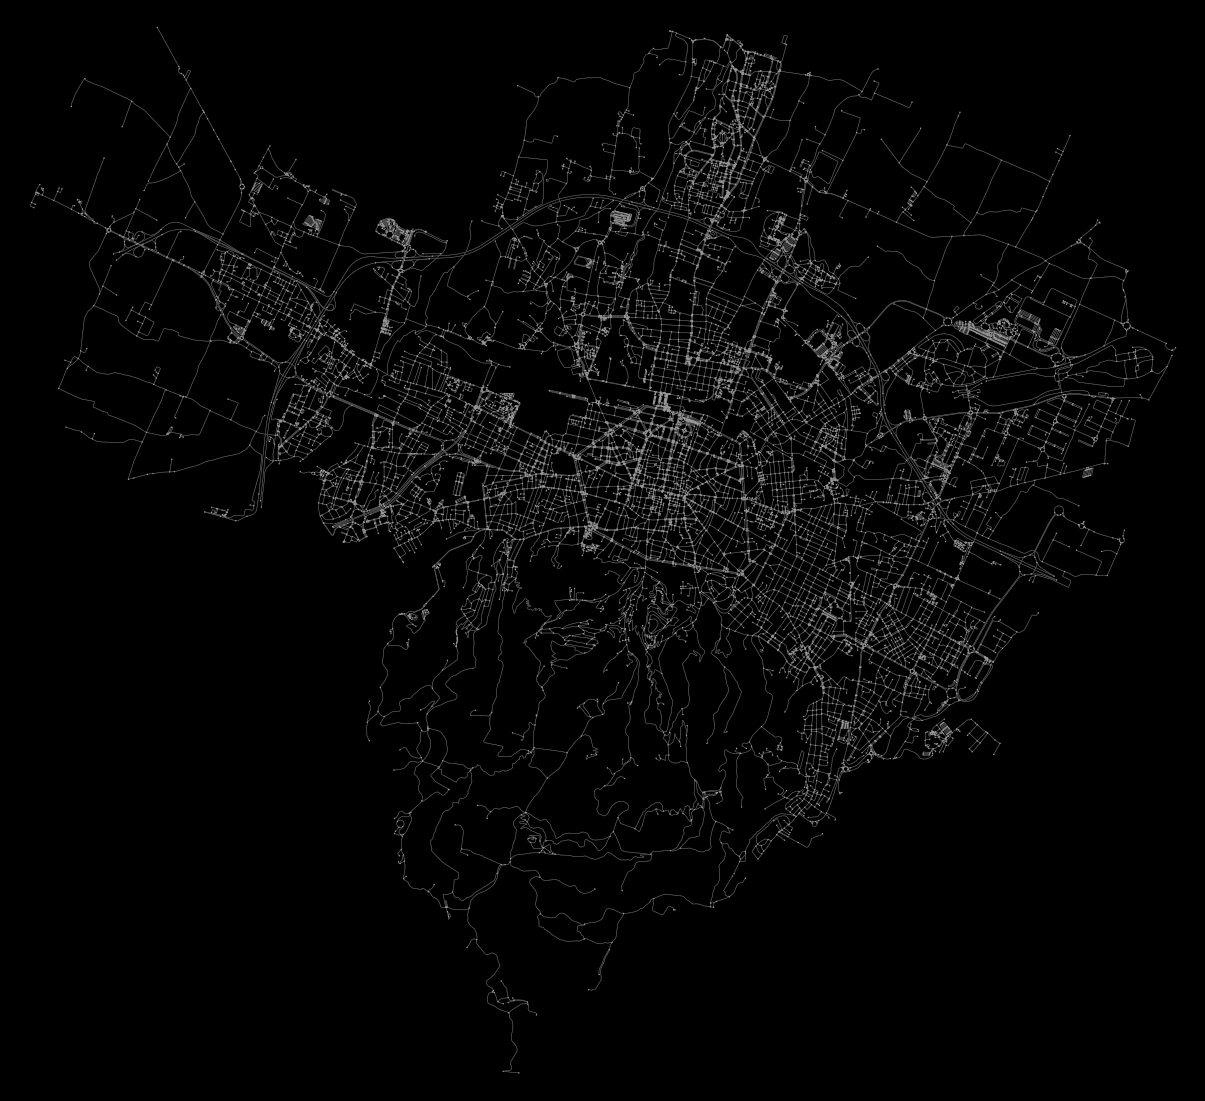

time: 43.8 s


In [14]:
# download and project a street network
G = ox.graph_from_place('Bologna, Italy', network_type="walk")
#G = ox.project_graph(G)
fig, ax = ox.plot_graph(G, fig_height=20, bgcolor='k', node_size=2, node_color='#999999', node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=0.5, edge_alpha=1)

In [15]:
centers = {}
for i in range(0, len(popt), 6):
    lon = popt[i+1]*1000 + (np.array(polyair.center_lon)*500/meter_500).min()
    lon = lon*meter_500/500
    lat = popt[i+2]*1000 + (np.array(polyair.center_lat)*500/meter_500).min()
    lat = lat*meter_500/500
    centers['center_node_{}'.format(i//6+1)] = ox.get_nearest_node(G, (lat,lon))

centers

{'center_node_1': 344154407}

time: 208 ms


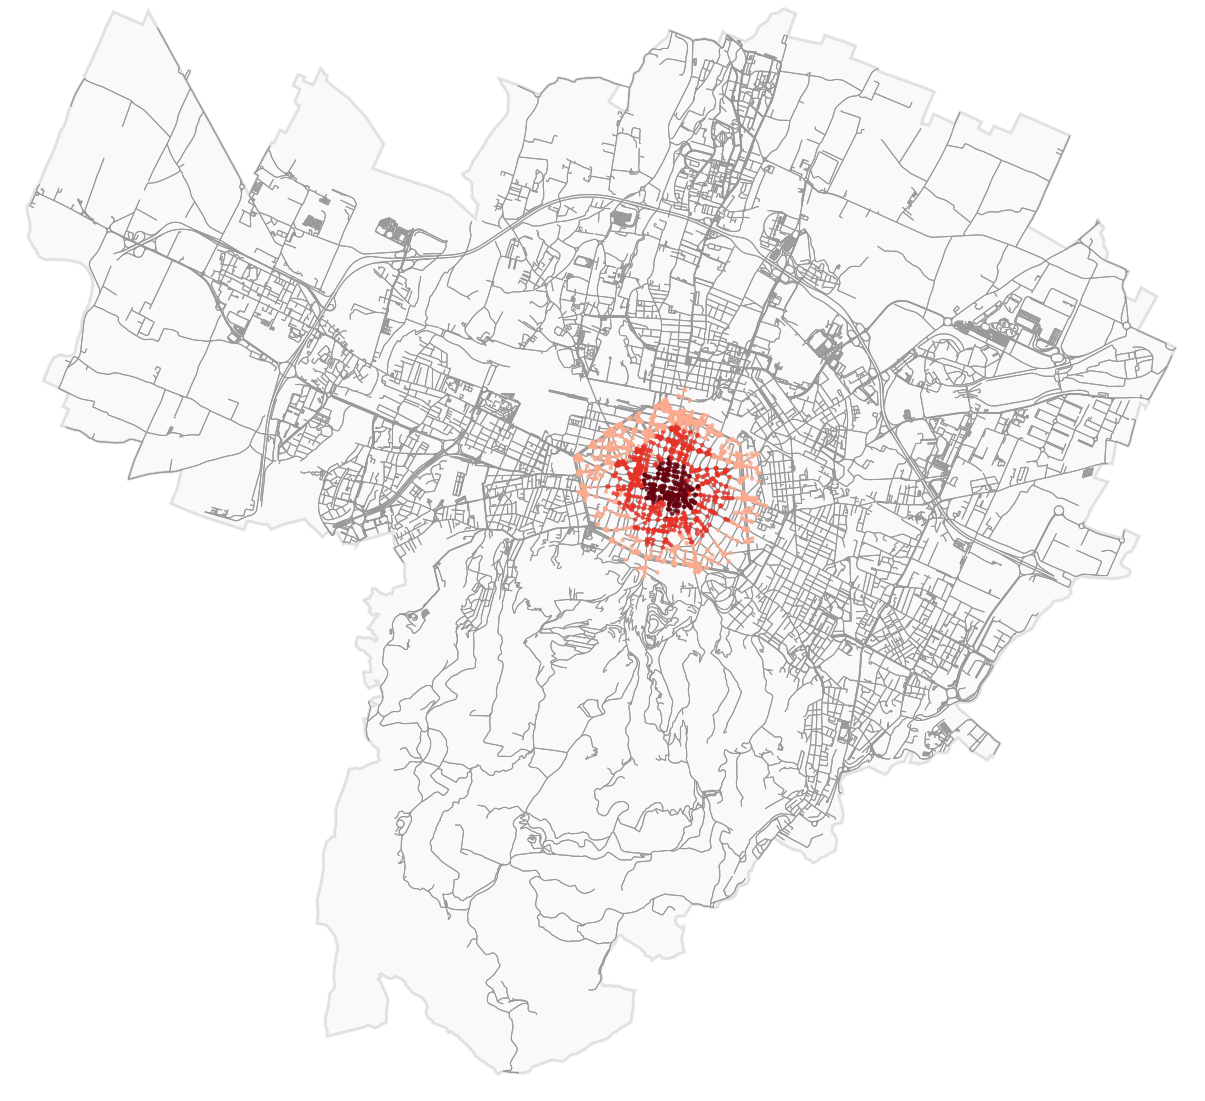

time: 8.3 s


In [16]:
import networkx as nx
#center_node = ox.get_nearest_node(G, (popt[8],popt[7]))
center_node = centers['center_node_1']
# list of distances from center
dists = np.arange(500, 2000, 500)
dists

# get one color for each isochrone
iso_colors = ox.get_colors(n=len(dists), cmap='Reds', start=0.3, return_hex=True)
# color the nodes according to isochrone then plot the street network
node_colors = {}
for dist, color in zip(sorted(dists, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=dist, distance='length')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=20,show=False, close=False, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)
plt.close()
# to this matplotlib axis, add the place shape as descartes polygon patches
for geometry in city['geometry'].tolist():
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            geometry = MultiPolygon([geometry])
        for polygon in geometry:
            patch = PolygonPatch(polygon, fc='#cccccc', ec='k', linewidth=3, alpha=0.1, zorder=-1)
            ax.add_patch(patch)
            
fig

950
950 67
Number of cells with price above 5th percentile:  67



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yes


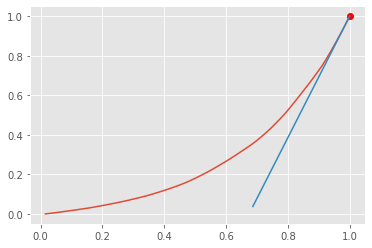

Loubar price:  31.497501615010844
Average price:  29.04583351402186
average city distance:  2104.4589605649485
eta =  0.5794073545459113
time: 568 ms


In [17]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))



mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)
    
print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True

  
if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No") 
    
    
L1= L
F1 = np.arange(1, len(L1)+1)/len(L1)

L1 = (L1 - L1.min())/(L1.max()-L1.min())

from scipy import interpolate
tck = interpolate.splrep(F1,L1)
x0_1 =1
y0_1 = interpolate.splev(x0_1,tck)
dydx = interpolate.splev(x0_1,tck,der=1)
tngnt1 = lambda x: dydx*x + (y0_1-dydx*x0_1)
plt.plot(F1, L1)
plt.plot(x0_1,y0_1, "or")
plt.plot(F1[tngnt1(F1)>0],tngnt1(F1[tngnt1(F1)>0]), label="tangent")
plt.show()

indlist = poly_prices.index.tolist()

loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

print('Loubar price: ', loubar_val)
print('Average price: ', np.mean(vals_cut))

if loubar_val > np.mean(vals_cut):
    loubar_keys = keys[vals_cut>loubar_val]
else:
    loubar_keys = keys[vals_cut>np.mean(vals_cut)]
#loubar_keys = keys[vals_cut>loubar_val]
dist_mat = mat[keys.reshape(-1,1), keys]

total_dist = dist_mat.sum()
dist_corr = dist_mat[dist_mat>0]

loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]
loubar_dist = loubar_dist_mat.sum()

loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
eta_loubar = loubar_dist_corr.mean()/dist_corr.mean()

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

avg_dist_meters = (dist_corr.mean()/0.00899928)*1000
print('average city distance: ', avg_dist_meters)
print('eta = ', eta_loubar)

In [18]:
pickle_in = open("City_spreading_index.pickle","rb")
spreading_index_dict = pickle.load(pickle_in)
#spreading_index_dict = {}
spreading_index_dict['Bologna'] = eta_loubar


pickle_out = open("City_spreading_index.pickle","wb")
pickle.dump(spreading_index_dict, pickle_out)
pickle_out.close()

spreading_index_dict

{'Paris': 0.7251609142253275,
 'Amsterdam': 0.6513935879350918,
 'Stockholm': 0.6839327295656318,
 'Arezzo': 0.5574311537992848,
 'Berlin': 0.7499866909236614,
 'Bordeaux': 0.5818334466519048,
 'Denver': 0.6312111392217781,
 'Edinburgh': 0.6813298654934006,
 'Lyon': 0.6138305864151811,
 'Madrid': 0.6426066210787698,
 'Buenos_Aires': 0.8337988194080271,
 'Palermo': 0.8841435007903967,
 'Los_Angeles': 0.7889452782510832,
 'Beijing': 0.6425383574699105,
 'Florence': 0.5049117106731263,
 'Moscow': 0.6925493573699144,
 'Porto': 0.7058843952576399,
 'Prague': 0.5522963433539414,
 'Reykjavik': 0.8276260142343259,
 'Riga': 0.6850021296374689,
 'Rome': 0.5803964773671335,
 'Seoul': 0.8924742030382572,
 'Siena': 0.5646389917673048,
 'Sydney': 0.7909301400958108,
 'Tallin': 0.5690189423395199,
 'Treviso': 0.5345662066021125,
 'Valencia': 0.6956994914059091,
 'Venezia': 0.656650370883064,
 'Verona': 0.5707647012625697,
 'Vicenza': 0.5117751186840898,
 'Vienna': 0.6189242538490607,
 'Wellington': 0

time: 6 ms


In [19]:
pickle_in = open("avg_distances_dict.pickle","rb")
avg_distances_dict = pickle.load(pickle_in)
#avg_distances_dict = {}
avg_distances_dict['Bologna'] = avg_dist_meters


pickle_out = open("avg_distances_dict.pickle","wb")
pickle.dump(avg_distances_dict, pickle_out)
pickle_out.close()

avg_distances_dict

{'Venezia': 2398.636425932576,
 'Verona': 3141.8502884813342,
 'Vicenza': 1988.2224372858566,
 'Vienna': 5125.89366602888,
 'Wellington': 2806.4963410749997,
 'Zurich': 2068.4583585914684,
 'Aarhus': 2857.919349359045,
 'Milan': 6008.128043000454,
 'Busan': 7348.804402235624,
 'Valencia': 4090.433301180094,
 'Bologna': 2104.4589605649485,
 'Barcelona': 4218.232625020259,
 'Bremen': 3772.1380465457137,
 'Brno': 2231.9772664038364,
 'Budapest': 3463.3335339061914,
 'Dublin': 4138.1465107736385,
 'Boston': 5610.60832524716,
 'Rio': 8357.334811118957,
 'NY': 8563.096975538809,
 'Ottawa': 2220.3476963993976,
 'Nashville': 5606.900406329212,
 'New_Orleans': 5048.047130029565,
 'Shanghai': 5452.583570486633,
 'Portland': 5406.388840795854,
 'Amsterdam': 7020.480387015727,
 'Arezzo': 1662.0178383704194,
 'Beijing': 6586.560663166117,
 'Berlin': 8495.253652229821}

time: 5 ms


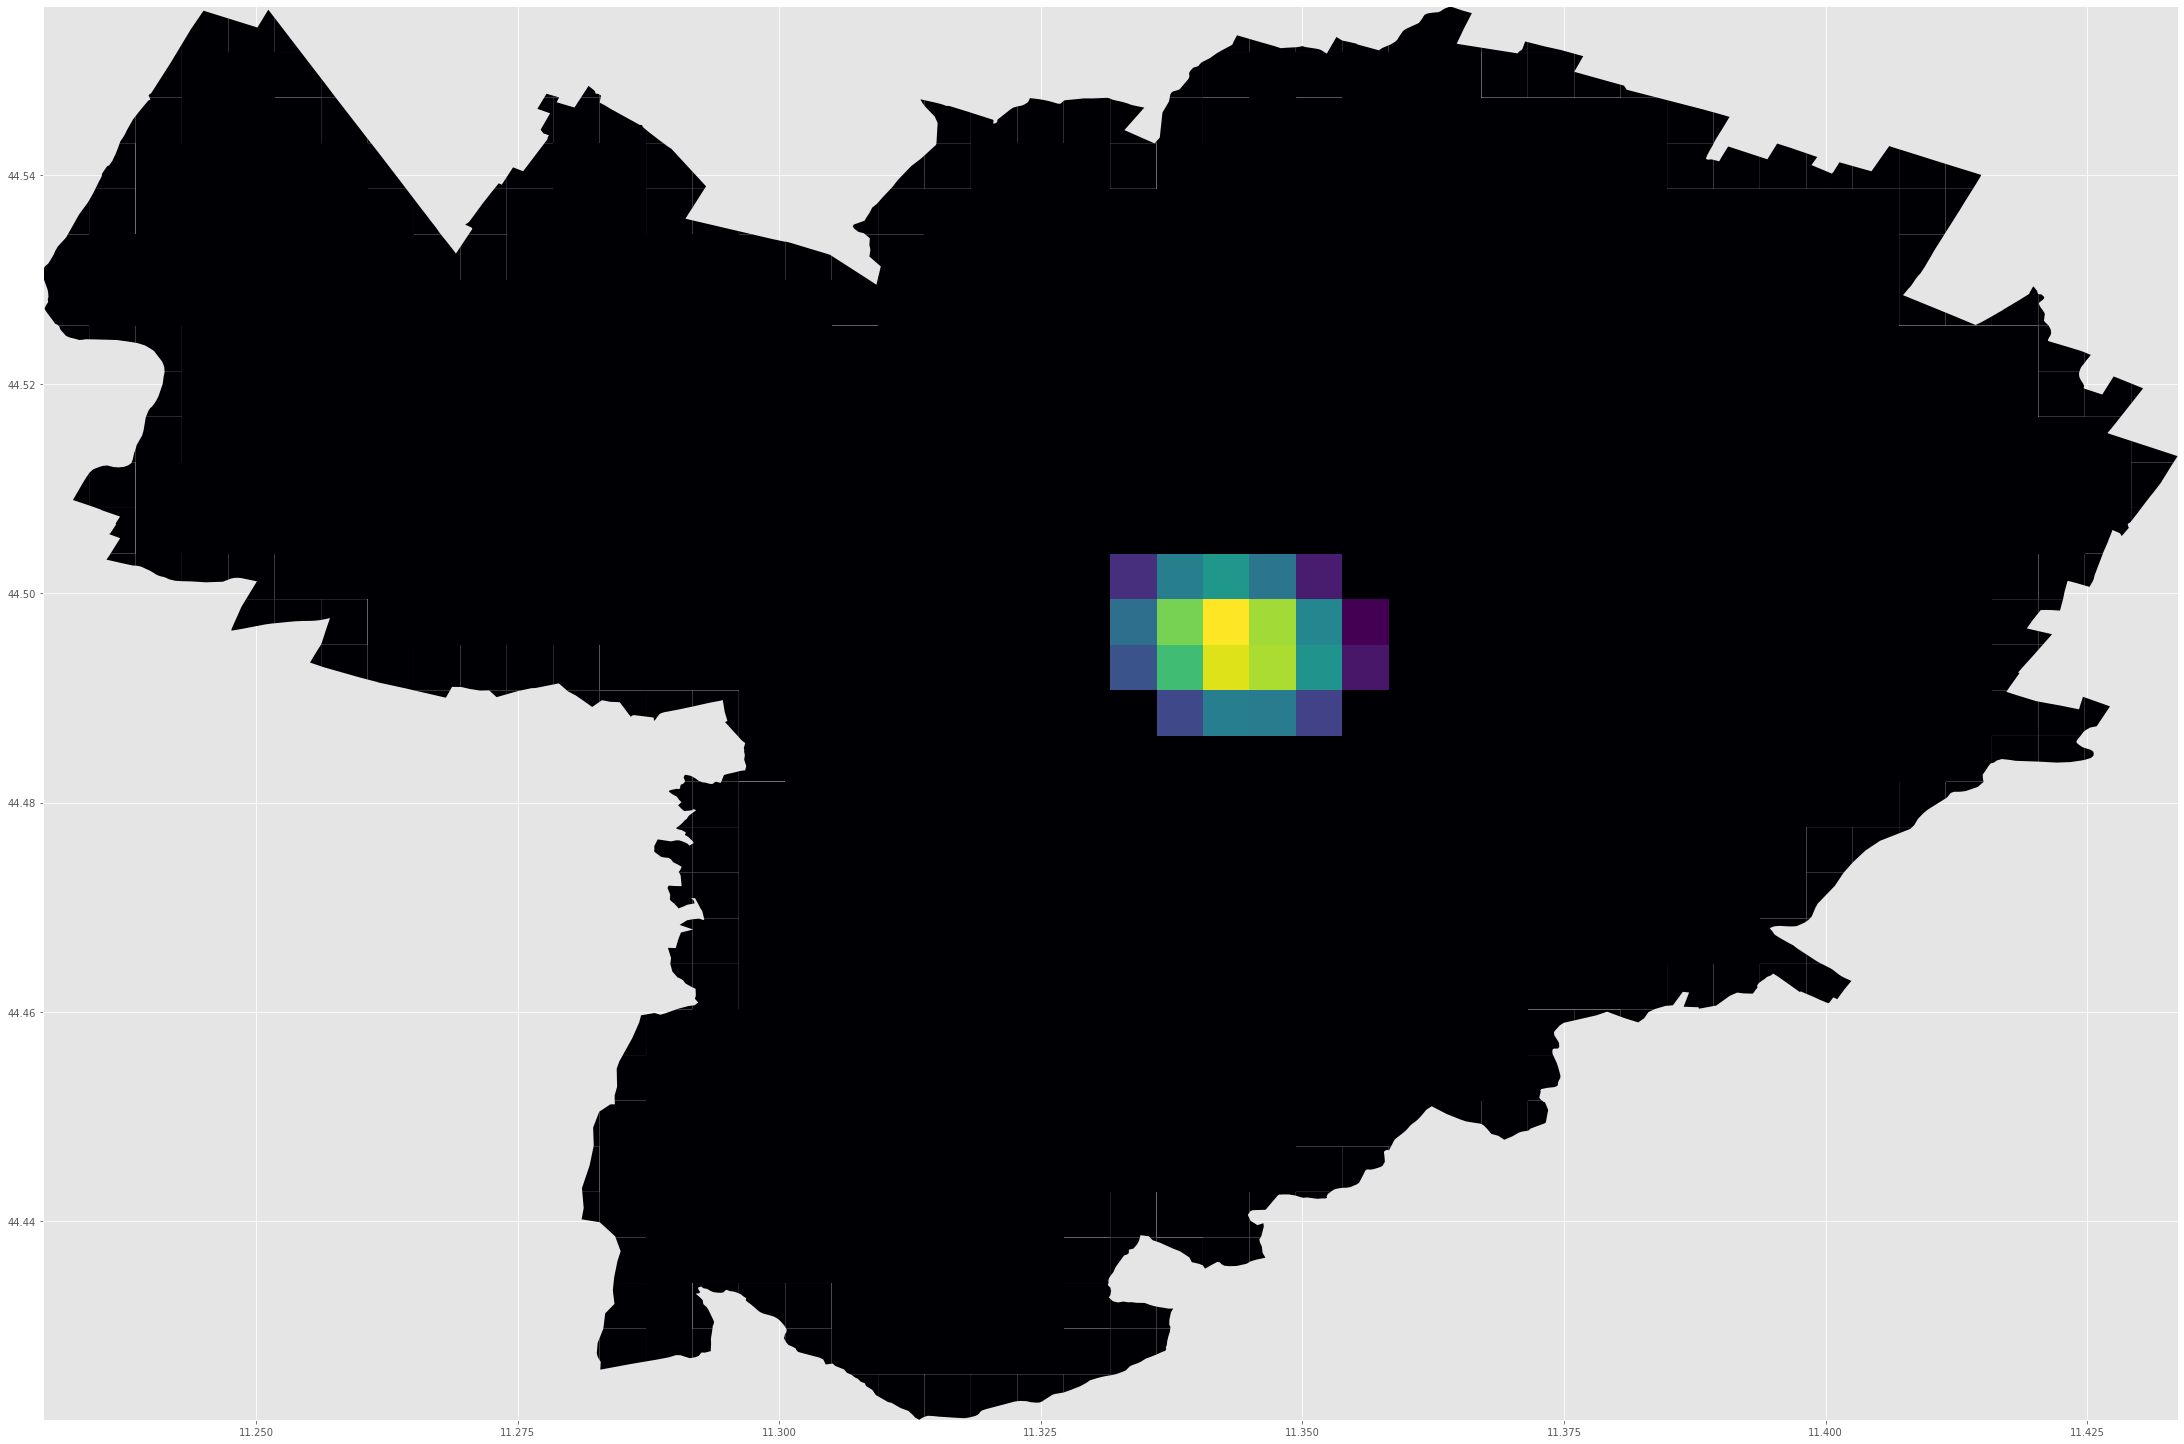

time: 905 ms


In [20]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe.plot(ax=ax, color='#000004')
#polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
poly_prices[poly_prices.index.isin(loubar_keys)].plot(ax=ax, column='zpred')
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [21]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    
print(len(keys))
vals = np.array(vals)
keys = np.array(keys)
keys = keys[vals>=0.01*vals.max()]
print(len(keys))

indlist = poly_prices.index.tolist()
mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)

print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True


if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No")

950
103



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yes
time: 564 ms


950


950 103
Number of cells with price above 1.0th percentile:  103
Loubar price:  22.157846861405076
Average price:  19.672586955669974
eta =  0.5739405253784119
950 90
Number of cells with price above 2.0th percentile:  90
Loubar price:  26.221856053009734
Average price:  22.327082868998996
eta =  0.5764608706930607
950 78
Number of cells with price above 3.0th percentile:  78
Loubar price:  29.07648089419176
Average price:  25.43242683324671
eta =  0.5803552554185883
950 72
Number of cells with price above 4.0th percentile:  72
Loubar price:  30.099118020567296
Average price:  27.306810627290947
eta =  0.5879461277492674
950 67
Number of cells with price above 5.0th percentile:  67
Loubar price:  31.497501615010844
Average price:  29.04583351402186
eta =  0.5794073545459113
950 66
Number of cells with price above 6.000000000000001th percentile:  66
Loubar price:  31.497501615010844
Average price:  29.41054849612146
eta =  0.5855017210836101
950 62
Number of cells with price above 6.9999

Number of cells with price above 52.0th percentile:  16
Loubar price:  72.12352699858346
Average price:  65.64808017841248
eta =  0.6306130085336928
950 15
Number of cells with price above 53.0th percentile:  15
Loubar price:  77.53172089564062
Average price:  66.92166328587129
eta =  0.537405228993808
950 15
Number of cells with price above 54.0th percentile:  15
Loubar price:  77.53172089564062
Average price:  66.92166328587129
eta =  0.537405228993808
950 14
Number of cells with price above 55.00000000000001th percentile:  14
Loubar price:  77.53172089564062
Average price:  68.23184968460046
eta =  0.5562765984016143
950 14
Number of cells with price above 56.00000000000001th percentile:  14
Loubar price:  77.53172089564062
Average price:  68.23184968460046
eta =  0.5562765984016143
950 14
Number of cells with price above 57.00000000000001th percentile:  14
Loubar price:  77.53172089564062
Average price:  68.23184968460046
eta =  0.5562765984016143
950 14
Number of cells with price 

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning:

Mean of empty slice.

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



eta =  nan
950 6
Number of cells with price above 73.0th percentile:  6
Loubar price:  85.81182658059461
Average price:  81.15474757336963
eta =  nan
950 6
Number of cells with price above 74.0th percentile:  6
Loubar price:  85.81182658059461
Average price:  81.15474757336963
eta =  nan
950 6
Number of cells with price above 75.0th percentile:  6
Loubar price:  85.81182658059461
Average price:  81.15474757336963
eta =  nan
950 6
Number of cells with price above 76.0th percentile:  6
Loubar price:  85.81182658059461
Average price:  81.15474757336963
eta =  nan
950 6
Number of cells with price above 77.0th percentile:  6
Loubar price:  85.81182658059461
Average price:  81.15474757336963
eta =  nan
950 6
Number of cells with price above 78.0th percentile:  6
Loubar price:  85.81182658059461
Average price:  81.15474757336963
eta =  nan
950 6
Number of cells with price above 79.0th percentile:  6
Loubar price:  85.81182658059461
Average price:  81.15474757336963
eta =  nan
950 6
Number of 

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning:

invalid value encountered in true_divide



Loubar price:  88.5654784060658
Average price:  88.5654784060658
eta =  nan
950 1
Number of cells with price above 98.0th percentile:  1
Loubar price:  88.5654784060658
Average price:  88.5654784060658
eta =  nan
950 1
Number of cells with price above 99.0th percentile:  1
Loubar price:  88.5654784060658
Average price:  88.5654784060658
eta =  nan
950 1
Number of cells with price above 100.0th percentile:  1
Loubar price:  88.5654784060658
Average price:  88.5654784060658
eta =  nan



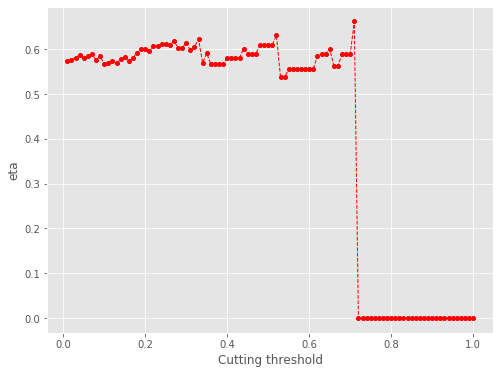

time: 1.6 s


In [22]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_cut = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    
    
        
    L1= L
    F1 = np.arange(1, len(L1)+1)/len(L1)

    L1 = (L1 - L1.min())/(L1.max()-L1.min())
    

    loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

    print('Loubar price: ', loubar_val)
    print('Average price: ', np.mean(vals_cut))
    
    
    loubar_keys = keys[vals_cut>loubar_val]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas_cut.append(eta)
    print('eta = ', eta)
etas_cut = np.array(etas_cut)
etas_cut = np.where(np.isnan(etas_cut), 0, etas_cut)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(perc_vals, etas_cut, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Cutting threshold")
plt.ylabel("eta")
plt.show()

In [23]:
pickle_in = open("etas_cut_dict.pickle","rb")
etas_cut_dict = pickle.load(pickle_in)
#etas_cut_dict = {}
etas_cut_dict['Bologna'] = etas_cut


pickle_out = open("etas_cut_dict.pickle","wb")
pickle.dump(etas_cut_dict, pickle_out)
pickle_out.close()

etas_cut_dict

{'Boston': array([0.54176111, 0.69697859, 0.70601119, 0.71142664, 0.72735905,
        0.71723297, 0.69152614, 0.68969459, 0.69338651, 0.68627389,
        0.68571239, 0.68565242, 0.66080855, 0.68568495, 0.66662135,
        0.65169235, 0.66853925, 0.64080339, 0.6392735 , 0.64870117,
        0.66369008, 0.64936606, 0.65513408, 0.65817401, 0.54708479,
        0.54484174, 0.5177247 , 0.54225619, 0.54660686, 0.55128317,
        0.55836993, 0.56571414, 0.52792612, 0.52759205, 0.55096732,
        0.46941853, 0.48021089, 0.47484233, 0.46129546, 0.46439344,
        0.4699713 , 0.50255475, 0.51573036, 0.52765377, 0.52765377,
        0.53943229, 0.54404083, 0.54813213, 0.6100999 , 0.50092562,
        0.52536404, 0.56707558, 0.56150998, 0.61316219, 0.66467806,
        0.74541769, 0.74541769, 0.77652679, 0.74895419, 0.92876367,
        0.92876367, 0.90963119, 0.90963119, 1.05344906, 1.15130075,
        1.15130075, 1.22651104, 1.26738008, 0.62257449, 0.62257449,
        0.64231201, 0.64231201, 0.6240

time: 23 ms


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


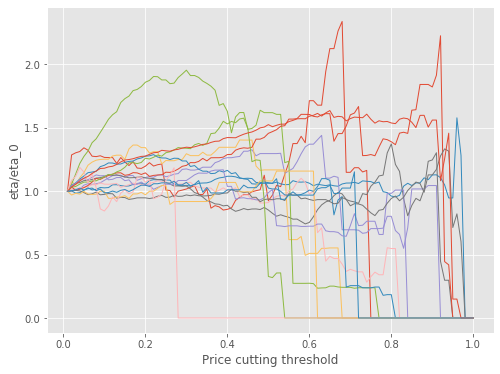

time: 231 ms


In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_cut_dict:
    print(len(etas_cut_dict[key]))
    etas = etas_cut_dict[key]#[1:]
    vals = etas/etas[0]
    plt.plot(np.linspace(0.01, 1, 100), vals, linestyle='-', linewidth=1)
plt.xlabel("Price cutting threshold")
plt.ylabel("eta/eta_0")
plt.show()

950 67
Number of cells with price above 5th percentile:  67


eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  0.989591206450393
eta =  0.9508719342886205
eta =  0.9221664415581582
eta =  0.9110806954057296
eta =  0.8779888264730086
eta =  0.8653635975047327
eta =  0.8553931394571747
eta =  0.8215363921467295
eta =  0.8215363921467295
eta =  0.8160475790843922
eta =  0.788935206443935
eta =  0.777595924489026
eta =  0.7566318741615606
eta =  0.7448381728995137
eta =  0.7448381728995137
eta =  0.7389916313472701
eta =  0.7237725003202509
eta =  0.7237725003202509
eta =  0.7190360099206415
eta =  0.7092589220781768
eta =  0.6903997587752297
eta =  0.6903997587752297
eta =  0.6770975602143565
eta =  0.6770975602143565
eta =  0.659158554781499
eta =  0.6541851357133438
eta =  0.6458911947323599
eta =  0.628769794388677
eta =  0.610186201259463
eta =  0.5883275414441737
eta =  0.5794073545459113
eta =  0.5794073545459113
eta =  0.5794073545459113
eta =  0.5794073545459113
eta =  0.5651706800058207
eta =  0.5651706800058207
eta 

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan
eta =  nan
eta =  nan



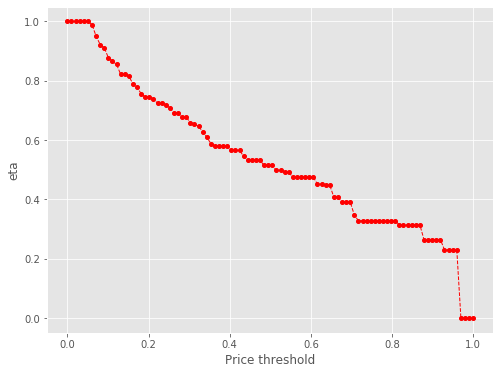

time: 520 ms


In [25]:
lval = np.linspace(0, max(vals_cut), 100)
etas = []

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)
vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

for i in tqdm_notebook(lval):
    loubar_keys = keys[vals_cut>=i]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas.append(eta)
    print('eta = ', eta)
etas = np.array(etas)
etas = np.where(np.isnan(etas), 0, etas)
lval = lval/lval.max()
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(lval, etas, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

etas_cut_threshold = etas

In [26]:
pickle_in = open("etas_cut_threshold_dict.pickle","rb")
etas_cut_threshold_dict = pickle.load(pickle_in)
#etas_cut_threshold_dict = {}
etas_cut_threshold_dict['Bologna'] = etas_cut_threshold


pickle_out = open("etas_cut_threshold_dict.pickle","wb")
pickle.dump(etas_cut_threshold_dict, pickle_out)
pickle_out.close()

etas_cut_threshold_dict

{'NY': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        0.99991145, 0.98955316, 0.97868522, 0.96344498, 0.95205618,
        0.94615067, 0.93194961, 0.92540239, 0.92150344, 0.91822455,
        0.91569734, 0.91218202, 0.90337978, 0.898264  , 0.89376519,
        0.89441924, 0.88573077, 0.88617046, 0.87902683, 0.87195329,
        0.87101443, 0.87158631, 0.86935351, 0.86321974, 0.86053312,
        0.86079304, 0.86069179, 0.86140605, 0.85888874, 0.8617884 ,
        0.85709178, 0.8579834 , 0.85179248, 0.84947743, 0.84847717,
        0.84228408, 0.82983947, 0.82767187, 0.82334824, 0.81678545,
        0.81788964, 0.81304395, 0.807866  , 0.79902867, 0.79698224,
        0.78820712, 0.76853775, 0.76312442, 0.75071909, 0.7481045 ,
        0.73389742, 0.71700231, 0.70245218, 0.68328343, 0.67990807,
        0.66811743, 0.61552082, 0.58620924, 0.57826542, 0.57372339,
        0.55441141, 0.5326264 , 0.53706259, 0.53126932, 0.52772792,
        0.5331439 , 0.51700595, 0.49034259

time: 17 ms


950 103
Number of cells with price above 1.0th percentile:  103


eta =  1.0
eta =  0.9233652201524867
eta =  0.857781913913503
eta =  0.8331247669678042
eta =  0.8092115693049405
eta =  0.7942877854512396
eta =  0.7694565701537188
eta =  0.7462277533336298
eta =  0.7321096741663197
eta =  0.7104787161024264
eta =  0.7002622347561737
eta =  0.6878161045418392
eta =  0.664796753130174
eta =  0.664796753130174
eta =  0.6603551420983785
eta =  0.6384154964864138
eta =  0.6292396183408908
eta =  0.6122752662764147
eta =  0.60273166677024
eta =  0.60273166677024
eta =  0.5980005777057424
eta =  0.5856850808039107
eta =  0.5856850808039107
eta =  0.5818522579746451
eta =  0.5739405253784119
eta =  0.558679472246256
eta =  0.558679472246256
eta =  0.5479151792736059
eta =  0.5479151792736059
eta =  0.5333987285355134
eta =  0.5293741802865605
eta =  0.5226626272896159
eta =  0.5088077920488061
eta =  0.4937697334893903
eta =  0.4760814530773572
eta =  0.46886313463892093
eta =  0.46886313463892093
eta =  0.46886313463892093
eta =  0.46886313463892093
eta = 

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan
eta =  nan
eta =  nan


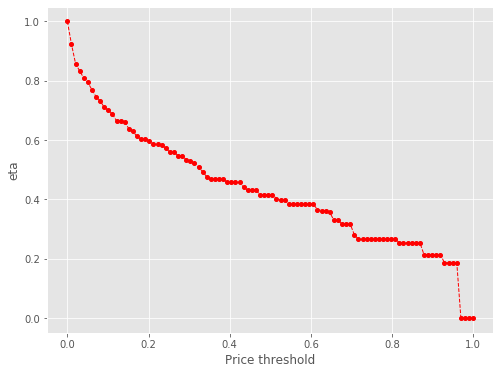

950 90
Number of cells with price above 2.0th percentile:  90


eta =  1.0
eta =  0.927172307683996
eta =  0.9000557517510639
eta =  0.8672505096120233
eta =  0.8582234781016803
eta =  0.8246441695875765
eta =  0.7997493163884187
eta =  0.7901351973882955
eta =  0.761436257192379
eta =  0.7557528029241399
eta =  0.7418401361128633
eta =  0.7237880486397189
eta =  0.7124778547540741
eta =  0.707717678828597
eta =  0.6842044598393695
eta =  0.6743704617853402
eta =  0.6561893784553138
eta =  0.6459612850255916
eta =  0.6459612850255916
eta =  0.6408908688849404
eta =  0.6276920697459059
eta =  0.6276920697459059
eta =  0.6235843460330722
eta =  0.6235843460330722
eta =  0.6071737166356719
eta =  0.598749542633836
eta =  0.598749542633836
eta =  0.5872132041529583
eta =  0.5764608706930607
eta =  0.5673423923280081
eta =  0.5601494677855576
eta =  0.5601494677855576
eta =  0.5453009246122272
eta =  0.5102273601362484
eta =  0.5024913235028958
eta =  0.5024913235028958
eta =  0.5024913235028958
eta =  0.5024913235028958
eta =  0.4901445602528218
eta = 

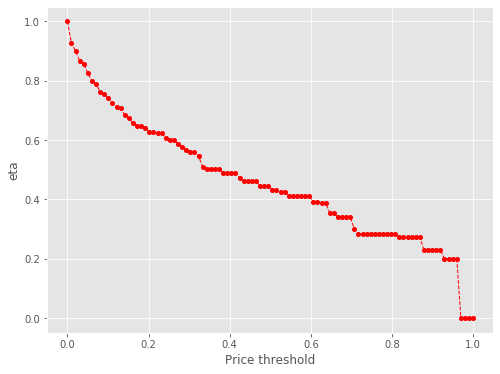

950 78
Number of cells with price above 3.0th percentile:  78


eta =  1.0
eta =  0.9579152759917134
eta =  0.9230011692639278
eta =  0.9133938406470138
eta =  0.8869280041711239
eta =  0.8511607038141354
eta =  0.8409285471532808
eta =  0.8139149342656754
eta =  0.804335901844019
eta =  0.7895288678993143
eta =  0.7793249963519248
eta =  0.7582790505443
eta =  0.7532128696698916
eta =  0.7281881180212303
eta =  0.7281881180212303
eta =  0.6983721045534775
eta =  0.6874865044986588
eta =  0.6874865044986588
eta =  0.6820901398097877
eta =  0.6680428640766681
eta =  0.6680428640766681
eta =  0.6636710778996213
eta =  0.6636710778996213
eta =  0.6546468143890302
eta =  0.6372397846090707
eta =  0.6372397846090707
eta =  0.6249618397836038
eta =  0.6249618397836038
eta =  0.6038136451784977
eta =  0.5961583279552435
eta =  0.5961583279552435
eta =  0.5803552554185883
eta =  0.5632025772311987
eta =  0.5430270086631442
eta =  0.5347936657259953
eta =  0.5347936657259953
eta =  0.5347936657259953
eta =  0.5347936657259953
eta =  0.5216531984790618
eta =

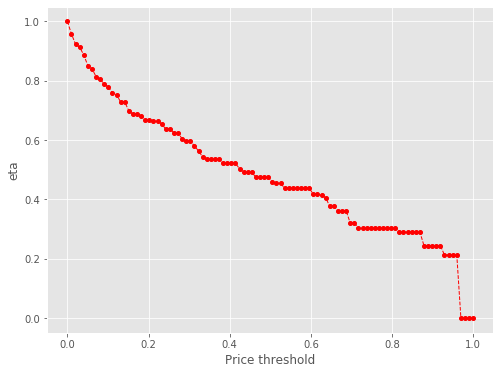

950 72
Number of cells with price above 4.0th percentile:  72


eta =  1.0
eta =  0.963551988779342
eta =  0.9535225750538247
eta =  0.9258939975175804
eta =  0.8885553087489321
eta =  0.8778736159966566
eta =  0.8496731962260891
eta =  0.8396733218512501
eta =  0.8242157607121656
eta =  0.8041591281779877
eta =  0.7915930245075865
eta =  0.7863042677653335
eta =  0.7601800871870943
eta =  0.7601800871870943
eta =  0.7290541471222126
eta =  0.7176903028160978
eta =  0.7176903028160978
eta =  0.7120568560759524
eta =  0.6973924321073747
eta =  0.6973924321073747
eta =  0.6973924321073747
eta =  0.6928285773629969
eta =  0.6834078449279196
eta =  0.6652360606206505
eta =  0.6652360606206505
eta =  0.6524187007421834
eta =  0.6524187007421834
eta =  0.6351335363806302
eta =  0.6303413885464761
eta =  0.6223497452194305
eta =  0.6058523858675877
eta =  0.5879461277492674
eta =  0.5668841726121944
eta =  0.5582891087860902
eta =  0.5582891087860902
eta =  0.5582891087860902
eta =  0.5582891087860902
eta =  0.5445713327193816
eta =  0.5445713327193816
et

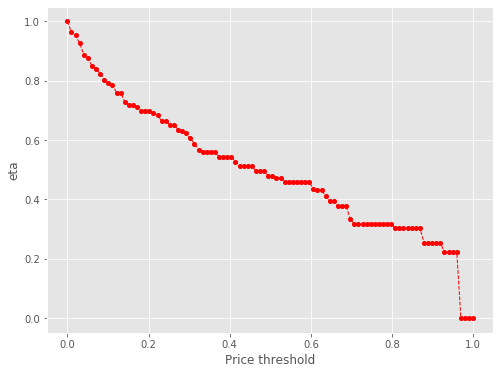

950 67
Number of cells with price above 5.0th percentile:  67


eta =  1.0
eta =  0.9711124021974902
eta =  0.9332534147138215
eta =  0.9110806954057296
eta =  0.8935245015538613
eta =  0.8779888264730086
eta =  0.8553931394571747
eta =  0.8443380380259091
eta =  0.8215363921467295
eta =  0.8215363921467295
eta =  0.8160475790843922
eta =  0.788935206443935
eta =  0.777595924489026
eta =  0.7566318741615606
eta =  0.7448381728995137
eta =  0.7448381728995137
eta =  0.7389916313472701
eta =  0.7237725003202509
eta =  0.7237725003202509
eta =  0.7190360099206415
eta =  0.7190360099206415
eta =  0.7092589220781768
eta =  0.6903997587752297
eta =  0.6903997587752297
eta =  0.6770975602143565
eta =  0.6770975602143565
eta =  0.6541851357133438
eta =  0.6541851357133438
eta =  0.6458911947323599
eta =  0.628769794388677
eta =  0.610186201259463
eta =  0.5883275414441737
eta =  0.5794073545459113
eta =  0.5794073545459113
eta =  0.5794073545459113
eta =  0.5794073545459113
eta =  0.5651706800058207
eta =  0.5651706800058207
eta =  0.5651706800058207
eta =

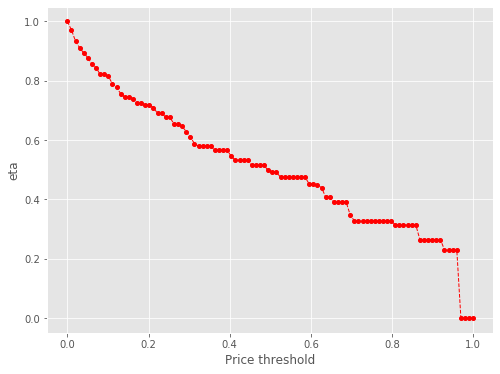

950 66
Number of cells with price above 6.000000000000001th percentile:  66


eta =  1.0
eta =  0.9608734678426899
eta =  0.9318660428136951
eta =  0.9206636937223035
eta =  0.8910887046152279
eta =  0.8806014076843981
eta =  0.8643904006841581
eta =  0.8532190186435682
eta =  0.8301775387571737
eta =  0.8246309928435077
eta =  0.8108232827196499
eta =  0.7972334447815077
eta =  0.7753147096071751
eta =  0.7645903371307793
eta =  0.75267258646245
eta =  0.7467645493718469
eta =  0.7313853393224676
eta =  0.7313853393224676
eta =  0.7313853393224676
eta =  0.7265990292090231
eta =  0.7167191032570387
eta =  0.7074774020150207
eta =  0.697661574067189
eta =  0.697661574067189
eta =  0.6842194593089268
eta =  0.6716908653770981
eta =  0.6610660356005672
eta =  0.6526848566582706
eta =  0.6526848566582706
eta =  0.6353833686983116
eta =  0.5945157329706585
eta =  0.5945157329706585
eta =  0.5855017210836101
eta =  0.5855017210836101
eta =  0.5855017210836101
eta =  0.5855017210836101
eta =  0.5711153012697593
eta =  0.5711153012697593
eta =  0.5711153012697593
eta =

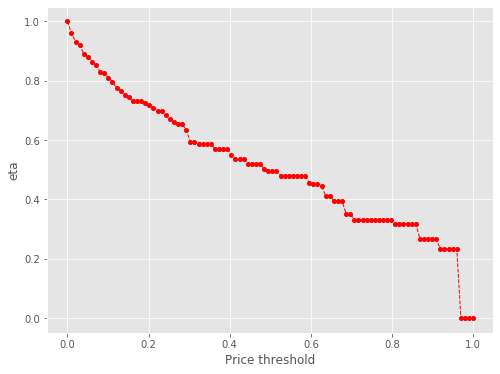

950 62
Number of cells with price above 6.999999999999999th percentile:  62


eta =  1.0
eta =  0.9596728255407668
eta =  0.9481361995545154
eta =  0.9176786959459211
eta =  0.9068784591999764
eta =  0.8901837174903123
eta =  0.8786789826083357
eta =  0.8549499474345131
eta =  0.8549499474345131
eta =  0.8492378931859352
eta =  0.8210228052295592
eta =  0.7984500173495344
eta =  0.7874056307491827
eta =  0.7751322556797012
eta =  0.7751322556797012
eta =  0.7690479233962549
eta =  0.7532097993692123
eta =  0.7532097993692123
eta =  0.7482806662755601
eta =  0.7482806662755601
eta =  0.7285884517778652
eta =  0.7184797205773218
eta =  0.7184797205773218
eta =  0.7046364945570301
eta =  0.7046364945570301
eta =  0.6807921751696069
eta =  0.672160902746984
eta =  0.672160902746984
eta =  0.6543431402427728
eta =  0.6350037145997415
eta =  0.6122560186501593
eta =  0.6029730296156172
eta =  0.6029730296156172
eta =  0.6029730296156172
eta =  0.6029730296156172
eta =  0.5881573205782032
eta =  0.5881573205782032
eta =  0.5881573205782032
eta =  0.5881573205782032
eta

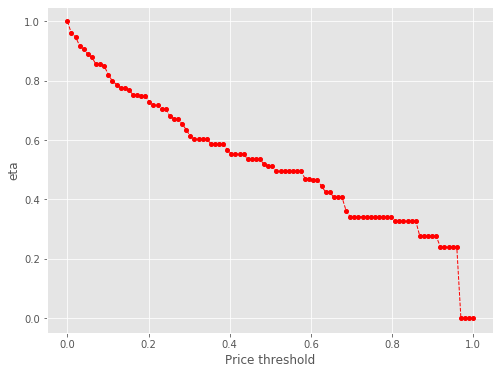

950 57
Number of cells with price above 8.0th percentile:  57


eta =  1.0
eta =  0.9689405960643055
eta =  0.9520936643383987
eta =  0.9384028289324351
eta =  0.9275908349167873
eta =  0.9050186524800887
eta =  0.8908764786090058
eta =  0.884924393589448
eta =  0.855523656999374
eta =  0.855523656999374
eta =  0.8320023200611262
eta =  0.8204938285144073
eta =  0.8077047041974137
eta =  0.8013646973518329
eta =  0.7848610269284071
eta =  0.7848610269284071
eta =  0.7848610269284071
eta =  0.7797247628158178
eta =  0.7797247628158178
eta =  0.7592050461232059
eta =  0.748671527895421
eta =  0.748671527895421
eta =  0.7342465846732442
eta =  0.7208019549129413
eta =  0.7094002841916325
eta =  0.7004063102112197
eta =  0.7004063102112197
eta =  0.6818398133489468
eta =  0.6616877103318235
eta =  0.637984115373027
eta =  0.6283110384790226
eta =  0.6283110384790226
eta =  0.6283110384790226
eta =  0.6283110384790226
eta =  0.6128727467580235
eta =  0.6128727467580235
eta =  0.6128727467580235
eta =  0.6128727467580235
eta =  0.5913775209976179
eta =  

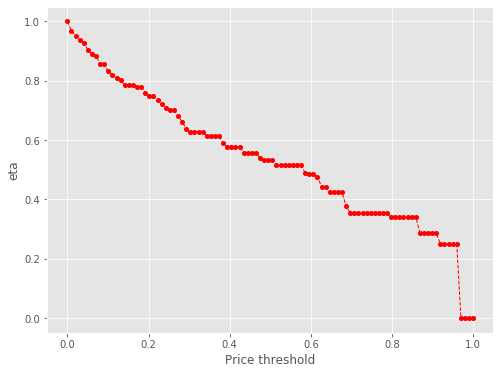

950 56
Number of cells with price above 9.0th percentile:  56


eta =  1.0
eta =  0.9636784435236176
eta =  0.9564854285977857
eta =  0.938877471304827
eta =  0.9160306375821762
eta =  0.901716386143904
eta =  0.8956918780075607
eta =  0.8806943167721084
eta =  0.8659334024112982
eta =  0.8421258651707302
eta =  0.8304773418831045
eta =  0.8175326034844987
eta =  0.8175326034844987
eta =  0.8111154534101687
eta =  0.7944109714649753
eta =  0.7944109714649753
eta =  0.7892122108903151
eta =  0.7892122108903151
eta =  0.7784809025750722
eta =  0.7577811298787047
eta =  0.7577811298787047
eta =  0.7431806684399411
eta =  0.7431806684399411
eta =  0.723490858828874
eta =  0.7180320459122636
eta =  0.7089286360575631
eta =  0.6901362278438666
eta =  0.6817053797759234
eta =  0.6457469073935049
eta =  0.6359561315124618
eta =  0.6359561315124618
eta =  0.6359561315124618
eta =  0.6359561315124618
eta =  0.6359561315124618
eta =  0.620329991465942
eta =  0.620329991465942
eta =  0.620329991465942
eta =  0.620329991465942
eta =  0.5985732184930111
eta =  0

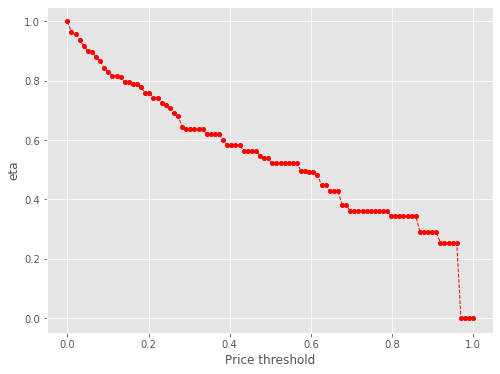

950 51
Number of cells with price above 10.0th percentile:  51


eta =  1.0
eta =  0.9742642658601891
eta =  0.9616728739222354
eta =  0.935702559504025
eta =  0.935702559504025
eta =  0.9294509844305854
eta =  0.8985708959568277
eta =  0.885655831877413
eta =  0.8617784775246468
eta =  0.8483458450053655
eta =  0.8483458450053655
eta =  0.8416868291090814
eta =  0.8243527462960274
eta =  0.8243527462960274
eta =  0.8243527462960274
eta =  0.8189580416519645
eta =  0.8078222645809274
eta =  0.7974058378497568
eta =  0.7863423063692647
eta =  0.7863423063692647
eta =  0.771191545721991
eta =  0.771191545721991
eta =  0.7450950581470241
eta =  0.7450950581470241
eta =  0.7356485359010614
eta =  0.716147831760598
eta =  0.6949817387889292
eta =  0.67008545405704
eta =  0.6599256585911958
eta =  0.6599256585911958
eta =  0.6599256585911958
eta =  0.6599256585911958
eta =  0.6437105609603055
eta =  0.6437105609603055
eta =  0.6437105609603055
eta =  0.6437105609603055
eta =  0.6437105609603055
eta =  0.6211337635657526
eta =  0.6057727099323625
eta =  0.

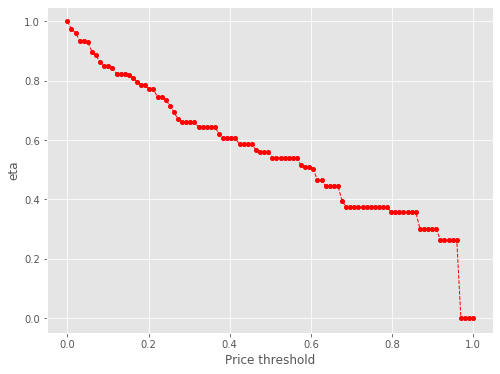

950 49
Number of cells with price above 11.0th percentile:  49


eta =  1.0
eta =  0.9822264723176625
eta =  0.9644244716415385
eta =  0.9493539993080613
eta =  0.943011216831234
eta =  0.9116806030653726
eta =  0.9116806030653726
eta =  0.8866153153093598
eta =  0.8743514013569569
eta =  0.8607227933405648
eta =  0.8607227933405648
eta =  0.8539666256798242
eta =  0.83637964713011
eta =  0.83637964713011
eta =  0.830906236400485
eta =  0.830906236400485
eta =  0.8196079938228483
eta =  0.7978146535929991
eta =  0.7978146535929991
eta =  0.7824428508048646
eta =  0.7824428508048646
eta =  0.7617128299389715
eta =  0.7559656283204889
eta =  0.7463812859643977
eta =  0.7463812859643977
eta =  0.7265960761484865
eta =  0.6798616710254629
eta =  0.6798616710254629
eta =  0.6695536491442748
eta =  0.6695536491442748
eta =  0.6695536491442748
eta =  0.6695536491442748
eta =  0.6531019812197841
eta =  0.6531019812197841
eta =  0.6531019812197841
eta =  0.6531019812197841
eta =  0.6301957994632144
eta =  0.6146106356177994
eta =  0.6146106356177994
eta =  0

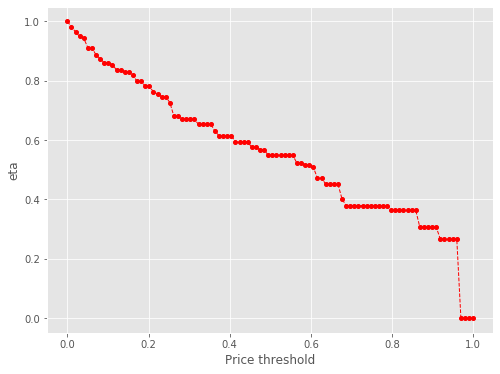

950 48
Number of cells with price above 12.0th percentile:  48


eta =  1.0
eta =  0.9756657983379887
eta =  0.960419664656265
eta =  0.9540029507394099
eta =  0.9380290226243717
eta =  0.9223071475001385
eta =  0.8969496988785619
eta =  0.8845428368080119
eta =  0.8707553738064602
eta =  0.8707553738064602
eta =  0.8639204562901077
eta =  0.8461284840085938
eta =  0.8461284840085938
eta =  0.8405912752315687
eta =  0.8405912752315687
eta =  0.8291613403963779
eta =  0.8071139771045529
eta =  0.8071139771045529
eta =  0.7915630006619376
eta =  0.7915630006619376
eta =  0.7770688624555064
eta =  0.7647771598080436
eta =  0.7550811024065929
eta =  0.7550811024065929
eta =  0.7350652762865144
eta =  0.7133400691601082
eta =  0.6877861351770035
eta =  0.6773579630456217
eta =  0.6773579630456217
eta =  0.6773579630456217
eta =  0.6773579630456217
eta =  0.6607145345641576
eta =  0.6607145345641576
eta =  0.6607145345641576
eta =  0.6607145345641576
eta =  0.6607145345641576
eta =  0.6375413584704828
eta =  0.6217745340351972
eta =  0.6217745340351972
et

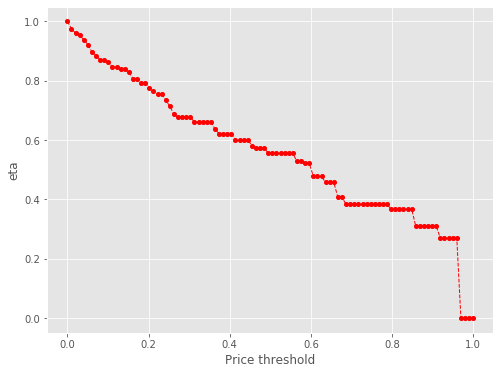

950 45
Number of cells with price above 13.0th percentile:  45


eta =  1.0
eta =  0.9843736106075514
eta =  0.977796856633203
eta =  0.9453105244349606
eta =  0.9453105244349606
eta =  0.9193206325429089
eta =  0.9066043293869669
eta =  0.8924729915610042
eta =  0.8924729915610042
eta =  0.8854676035193249
eta =  0.8672318794508765
eta =  0.8672318794508765
eta =  0.8615565664631122
eta =  0.8615565664631122
eta =  0.8498415562058486
eta =  0.827244306892219
eta =  0.827244306892219
eta =  0.8113054716177779
eta =  0.8113054716177779
eta =  0.7964498333130208
eta =  0.7838515617856173
eta =  0.773913673814175
eta =  0.773913673814175
eta =  0.7533986304928095
eta =  0.7311315722814687
eta =  0.7049402944621224
eta =  0.6942520319964853
eta =  0.6942520319964853
eta =  0.6942520319964853
eta =  0.6942520319964853
eta =  0.6942520319964853
eta =  0.677193497701427
eta =  0.677193497701427
eta =  0.677193497701427
eta =  0.677193497701427
eta =  0.6534423565492522
eta =  0.6372822897905898
eta =  0.6372822897905898
eta =  0.6372822897905898
eta =  0.6

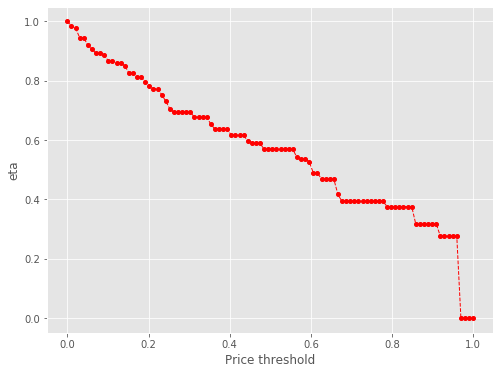

950 44
Number of cells with price above 14.000000000000002th percentile:  44


eta =  1.0
eta =  0.9933188436753305
eta =  0.9603168088298495
eta =  0.9465142773007487
eta =  0.9209961742345109
eta =  0.9066405091966794
eta =  0.9066405091966794
eta =  0.8995239144747266
eta =  0.8809987083213502
eta =  0.8809987083213502
eta =  0.8809987083213502
eta =  0.8752333028628865
eta =  0.8752333028628865
eta =  0.8522001246554533
eta =  0.8403763550524757
eta =  0.8403763550524757
eta =  0.8241844995387914
eta =  0.8241844995387914
eta =  0.8023485764995434
eta =  0.7962947739952388
eta =  0.7861991275208187
eta =  0.7861991275208187
eta =  0.765358419175637
eta =  0.7427378836681912
eta =  0.7161308337258615
eta =  0.7052729009750636
eta =  0.7052729009750636
eta =  0.7052729009750636
eta =  0.7052729009750636
eta =  0.6879435718349519
eta =  0.6879435718349519
eta =  0.6879435718349519
eta =  0.6879435718349519
eta =  0.6879435718349519
eta =  0.6638153943866396
eta =  0.6473987954606603
eta =  0.6473987954606603
eta =  0.6473987954606603
eta =  0.6473987954606603
et

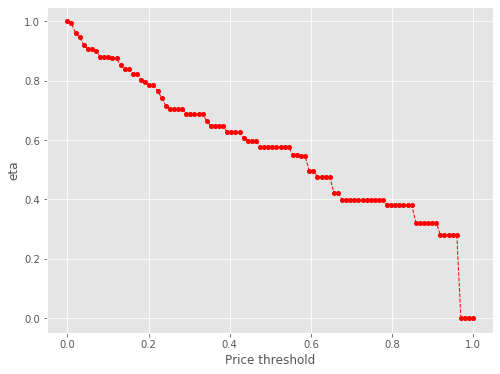

950 43
Number of cells with price above 15.000000000000002th percentile:  43


eta =  1.0
eta =  0.9667759903523305
eta =  0.952880621693028
eta =  0.9271908814563286
eta =  0.9127386588600929
eta =  0.9127386588600929
eta =  0.9055741972501418
eta =  0.8869243888111594
eta =  0.8869243888111594
eta =  0.8869243888111594
eta =  0.8811202046912535
eta =  0.8811202046912535
eta =  0.857932103152568
eta =  0.8460288057589244
eta =  0.8460288057589244
eta =  0.8297280422963351
eta =  0.8297280422963351
eta =  0.8077452487771324
eta =  0.8016507278256269
eta =  0.7914871770798606
eta =  0.7914871770798606
eta =  0.7705062921627175
eta =  0.7477336087977783
eta =  0.720947597325488
eta =  0.7100166330938792
eta =  0.7100166330938792
eta =  0.7100166330938792
eta =  0.7100166330938792
eta =  0.7100166330938792
eta =  0.692570745249859
eta =  0.692570745249859
eta =  0.692570745249859
eta =  0.692570745249859
eta =  0.6682802794020183
eta =  0.651753260881724
eta =  0.651753260881724
eta =  0.651753260881724
eta =  0.651753260881724
eta =  0.6303557135805921
eta =  0.630

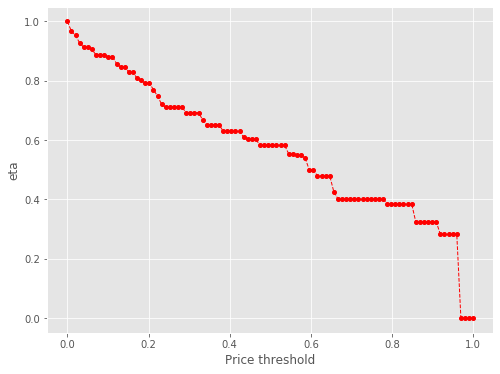

950 41
Number of cells with price above 16.0th percentile:  41


eta =  1.0
eta =  0.9590545180155172
eta =  0.9590545180155172
eta =  0.9441056335371503
eta =  0.9441056335371503
eta =  0.9366949596256684
eta =  0.9174042359987963
eta =  0.9174042359987963
eta =  0.9174042359987963
eta =  0.9114005865724275
eta =  0.8990078225499747
eta =  0.887415607869931
eta =  0.8751032443933562
eta =  0.8751032443933562
eta =  0.8582422925024754
eta =  0.8582422925024754
eta =  0.8355040431680133
eta =  0.8292000792587685
eta =  0.8186872501782053
eta =  0.8186872501782053
eta =  0.7969853408150065
eta =  0.773430056455245
eta =  0.7457235228429151
eta =  0.7344169075145544
eta =  0.7344169075145544
eta =  0.7344169075145544
eta =  0.7344169075145544
eta =  0.7344169075145544
eta =  0.7163714781512721
eta =  0.7163714781512721
eta =  0.7163714781512721
eta =  0.7163714781512721
eta =  0.6912462515318272
eta =  0.6741512691520194
eta =  0.6741512691520194
eta =  0.6741512691520194
eta =  0.6741512691520194
eta =  0.6520183784775893
eta =  0.6520183784775893
eta

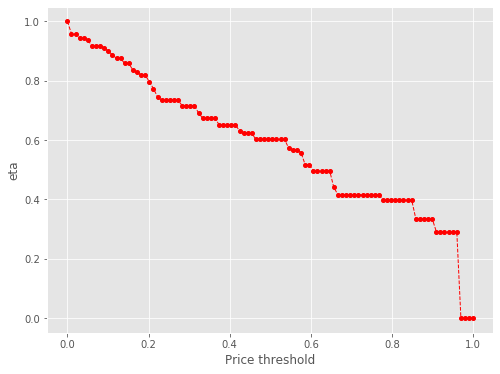

950 40
Number of cells with price above 17.0th percentile:  40


eta =  1.0
eta =  0.9730399174336706
eta =  0.9578730410514457
eta =  0.9578730410514457
eta =  0.9503543010888031
eta =  0.9307822707479547
eta =  0.9307822707479547
eta =  0.9307822707479547
eta =  0.9246910731857739
eta =  0.9246910731857739
eta =  0.9121175918511212
eta =  0.8878644255098241
eta =  0.8878644255098241
eta =  0.8707575990181416
eta =  0.8707575990181416
eta =  0.8548133457193958
eta =  0.841291878096226
eta =  0.8306257458290923
eta =  0.8306257458290923
eta =  0.8086073686688292
eta =  0.7847085896964141
eta =  0.7565980259358683
eta =  0.7451265320438137
eta =  0.7451265320438137
eta =  0.7451265320438137
eta =  0.7451265320438137
eta =  0.7451265320438137
eta =  0.7268179554531562
eta =  0.7268179554531562
eta =  0.7268179554531562
eta =  0.7268179554531562
eta =  0.7268179554531562
eta =  0.701326340559485
eta =  0.6839820708324651
eta =  0.6839820708324651
eta =  0.6839820708324651
eta =  0.6839820708324651
eta =  0.6615264275818824
eta =  0.6615264275818824
eta

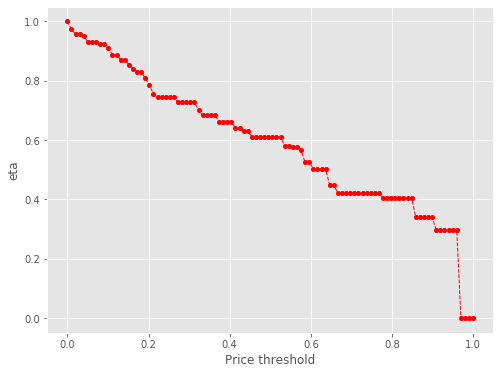

950 38
Number of cells with price above 18.000000000000004th percentile:  38


eta =  1.0
eta =  0.984412893951744
eta =  0.984412893951744
eta =  0.9766858317542622
eta =  0.956571517849784
eta =  0.956571517849784
eta =  0.9503115510662569
eta =  0.9503115510662569
eta =  0.9373896954369272
eta =  0.9253025674767459
eta =  0.9124645449813702
eta =  0.9124645449813702
eta =  0.8948837384952388
eta =  0.8948837384952388
eta =  0.871174711628328
eta =  0.8646016088580194
eta =  0.8536399493453606
eta =  0.8536399493453606
eta =  0.8310115075252807
eta =  0.8064505634733177
eta =  0.7775611384282635
eta =  0.7657718030818679
eta =  0.7657718030818679
eta =  0.7657718030818679
eta =  0.7657718030818679
eta =  0.7657718030818679
eta =  0.7469559495257823
eta =  0.7469559495257823
eta =  0.7469559495257823
eta =  0.7469559495257823
eta =  0.7207580367403503
eta =  0.7207580367403503
eta =  0.7029332081631587
eta =  0.7029332081631587
eta =  0.7029332081631587
eta =  0.7029332081631587
eta =  0.6798553848917271
eta =  0.6798553848917271
eta =  0.6798553848917271
eta = 

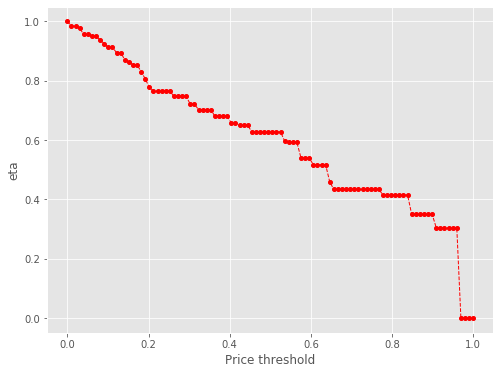

950 37
Number of cells with price above 19.0th percentile:  37


eta =  1.0
eta =  0.9921505881881911
eta =  0.971717786029604
eta =  0.971717786029604
eta =  0.971717786029604
eta =  0.965358699489811
eta =  0.9522322403498285
eta =  0.9399537258825302
eta =  0.9269124272828747
eta =  0.9269124272828747
eta =  0.9090532478733523
eta =  0.9090532478733523
eta =  0.8924077712648407
eta =  0.8782916336936991
eta =  0.8671564082410385
eta =  0.8671564082410385
eta =  0.8441696696894515
eta =  0.8338571169765576
eta =  0.7898729722107639
eta =  0.7778969655789638
eta =  0.7778969655789638
eta =  0.7778969655789638
eta =  0.7778969655789638
eta =  0.7778969655789638
eta =  0.7587831834742285
eta =  0.7587831834742285
eta =  0.7587831834742285
eta =  0.7587831834742285
eta =  0.7587831834742285
eta =  0.7321704552720761
eta =  0.7140633899474468
eta =  0.7140633899474468
eta =  0.7140633899474468
eta =  0.7140633899474468
eta =  0.7140633899474468
eta =  0.6906201544786488
eta =  0.6906201544786488
eta =  0.6906201544786488
eta =  0.6906201544786488
eta =

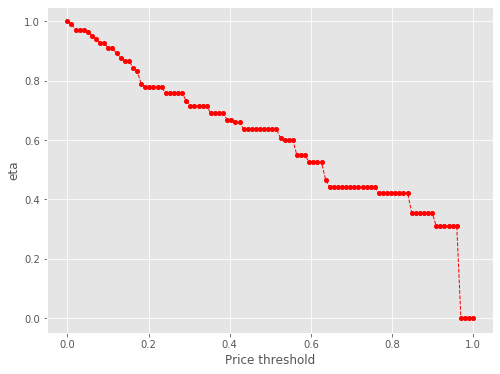

950 37
Number of cells with price above 20.0th percentile:  37


eta =  1.0
eta =  0.9921505881881911
eta =  0.971717786029604
eta =  0.971717786029604
eta =  0.971717786029604
eta =  0.965358699489811
eta =  0.9522322403498285
eta =  0.9399537258825302
eta =  0.9269124272828747
eta =  0.9269124272828747
eta =  0.9090532478733523
eta =  0.9090532478733523
eta =  0.8924077712648407
eta =  0.8782916336936991
eta =  0.8671564082410385
eta =  0.8671564082410385
eta =  0.8441696696894515
eta =  0.8338571169765576
eta =  0.7898729722107639
eta =  0.7778969655789638
eta =  0.7778969655789638
eta =  0.7778969655789638
eta =  0.7778969655789638
eta =  0.7778969655789638
eta =  0.7587831834742285
eta =  0.7587831834742285
eta =  0.7587831834742285
eta =  0.7587831834742285
eta =  0.7587831834742285
eta =  0.7321704552720761
eta =  0.7140633899474468
eta =  0.7140633899474468
eta =  0.7140633899474468
eta =  0.7140633899474468
eta =  0.7140633899474468
eta =  0.6906201544786488
eta =  0.6906201544786488
eta =  0.6906201544786488
eta =  0.6906201544786488
eta =

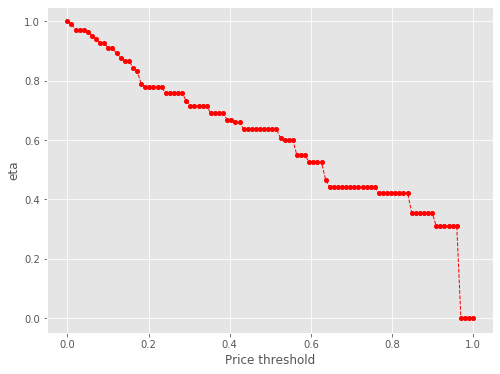

950 36
Number of cells with price above 21.000000000000004th percentile:  36


eta =  1.0
eta =  0.979405543471077
eta =  0.979405543471077
eta =  0.9729961469384342
eta =  0.9729961469384342
eta =  0.9597658376524684
eta =  0.9473901815640912
eta =  0.9342457065671346
eta =  0.9342457065671346
eta =  0.9162452340359074
eta =  0.9162452340359074
eta =  0.899468066530611
eta =  0.8852402489601757
eta =  0.8740169270318028
eta =  0.8740169270318028
eta =  0.8508483286101015
eta =  0.8404541880071855
eta =  0.7961220621288799
eta =  0.7961220621288799
eta =  0.7840513071705324
eta =  0.7840513071705324
eta =  0.7840513071705324
eta =  0.7840513071705324
eta =  0.7647863061391467
eta =  0.7647863061391467
eta =  0.7647863061391467
eta =  0.7647863061391467
eta =  0.7647863061391467
eta =  0.7379630310043197
eta =  0.7379630310043197
eta =  0.7197127114054618
eta =  0.7197127114054618
eta =  0.7197127114054618
eta =  0.7197127114054618
eta =  0.6960840044854683
eta =  0.6960840044854683
eta =  0.6960840044854683
eta =  0.6960840044854683
eta =  0.6960840044854683
eta 

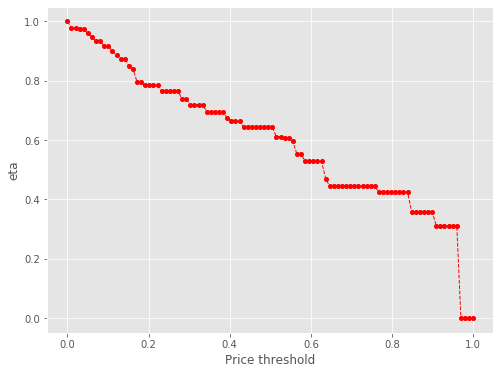

950 35
Number of cells with price above 22.0th percentile:  35


eta =  1.0
eta =  0.9934558298394682
eta =  0.9799473201376784
eta =  0.9673114348592297
eta =  0.9538905643275276
eta =  0.9538905643275276
eta =  0.935511586741356
eta =  0.935511586741356
eta =  0.918381637235621
eta =  0.9038546441373271
eta =  0.9038546441373271
eta =  0.892395323733037
eta =  0.892395323733037
eta =  0.8687395474551223
eta =  0.8430635330707801
eta =  0.8128625240443009
eta =  0.8005379512064058
eta =  0.8005379512064058
eta =  0.8005379512064058
eta =  0.8005379512064058
eta =  0.8005379512064058
eta =  0.7808678552386933
eta =  0.7808678552386933
eta =  0.7808678552386933
eta =  0.7808678552386933
eta =  0.7808678552386933
eta =  0.7534805535089486
eta =  0.7348464751942828
eta =  0.7348464751942828
eta =  0.7348464751942828
eta =  0.7348464751942828
eta =  0.7348464751942828
eta =  0.7107209154835914
eta =  0.7107209154835914
eta =  0.7107209154835914
eta =  0.7107209154835914
eta =  0.7107209154835914
eta =  0.687434332977737
eta =  0.6791587325867886
eta =  

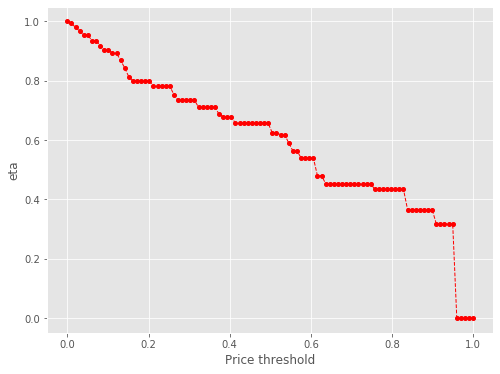

950 35
Number of cells with price above 23.0th percentile:  35


eta =  1.0
eta =  0.9934558298394682
eta =  0.9799473201376784
eta =  0.9673114348592297
eta =  0.9538905643275276
eta =  0.9538905643275276
eta =  0.935511586741356
eta =  0.935511586741356
eta =  0.918381637235621
eta =  0.9038546441373271
eta =  0.9038546441373271
eta =  0.892395323733037
eta =  0.892395323733037
eta =  0.8687395474551223
eta =  0.8430635330707801
eta =  0.8128625240443009
eta =  0.8005379512064058
eta =  0.8005379512064058
eta =  0.8005379512064058
eta =  0.8005379512064058
eta =  0.8005379512064058
eta =  0.7808678552386933
eta =  0.7808678552386933
eta =  0.7808678552386933
eta =  0.7808678552386933
eta =  0.7808678552386933
eta =  0.7534805535089486
eta =  0.7348464751942828
eta =  0.7348464751942828
eta =  0.7348464751942828
eta =  0.7348464751942828
eta =  0.7348464751942828
eta =  0.7107209154835914
eta =  0.7107209154835914
eta =  0.7107209154835914
eta =  0.7107209154835914
eta =  0.7107209154835914
eta =  0.687434332977737
eta =  0.6791587325867886
eta =  

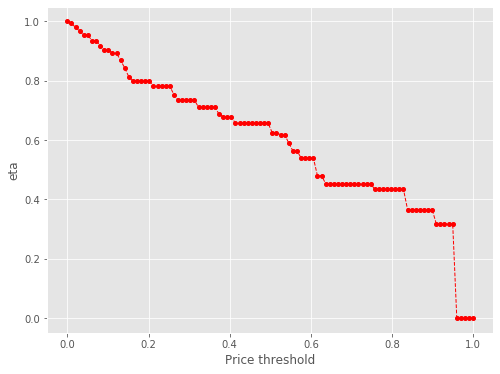

950 34
Number of cells with price above 24.000000000000004th percentile:  34


eta =  1.0
eta =  0.973683384610604
eta =  0.9601741070679167
eta =  0.9601741070679167
eta =  0.9416740620390991
eta =  0.9416740620390991
eta =  0.9416740620390991
eta =  0.9167253735376186
eta =  0.909808586339848
eta =  0.8982737802014192
eta =  0.8982737802014192
eta =  0.874462176738649
eta =  0.8486170272985465
eta =  0.8182170758166981
eta =  0.8058113175859707
eta =  0.8058113175859707
eta =  0.8058113175859707
eta =  0.8058113175859707
eta =  0.8058113175859707
eta =  0.8058113175859707
eta =  0.786011649219345
eta =  0.786011649219345
eta =  0.786011649219345
eta =  0.786011649219345
eta =  0.786011649219345
eta =  0.7584439397076194
eta =  0.7396871135307808
eta =  0.7396871135307808
eta =  0.7396871135307808
eta =  0.7396871135307808
eta =  0.7154026320409598
eta =  0.7154026320409598
eta =  0.7154026320409598
eta =  0.7154026320409598
eta =  0.7154026320409598
eta =  0.6919626543324217
eta =  0.6919626543324217
eta =  0.6836325402575103
eta =  0.6836325402575103
eta =  0.

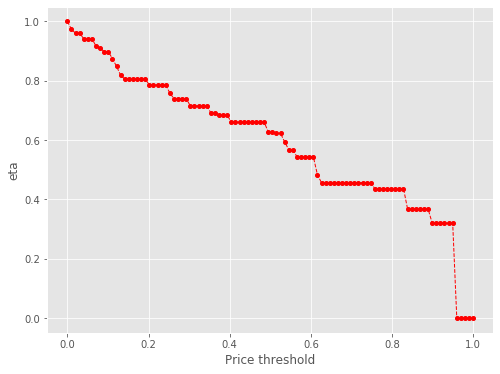

950 34
Number of cells with price above 25.0th percentile:  34


eta =  1.0
eta =  0.973683384610604
eta =  0.9601741070679167
eta =  0.9601741070679167
eta =  0.9416740620390991
eta =  0.9416740620390991
eta =  0.9416740620390991
eta =  0.9167253735376186
eta =  0.909808586339848
eta =  0.8982737802014192
eta =  0.8982737802014192
eta =  0.874462176738649
eta =  0.8486170272985465
eta =  0.8182170758166981
eta =  0.8058113175859707
eta =  0.8058113175859707
eta =  0.8058113175859707
eta =  0.8058113175859707
eta =  0.8058113175859707
eta =  0.8058113175859707
eta =  0.786011649219345
eta =  0.786011649219345
eta =  0.786011649219345
eta =  0.786011649219345
eta =  0.786011649219345
eta =  0.7584439397076194
eta =  0.7396871135307808
eta =  0.7396871135307808
eta =  0.7396871135307808
eta =  0.7396871135307808
eta =  0.7154026320409598
eta =  0.7154026320409598
eta =  0.7154026320409598
eta =  0.7154026320409598
eta =  0.7154026320409598
eta =  0.6919626543324217
eta =  0.6919626543324217
eta =  0.6836325402575103
eta =  0.6836325402575103
eta =  0.

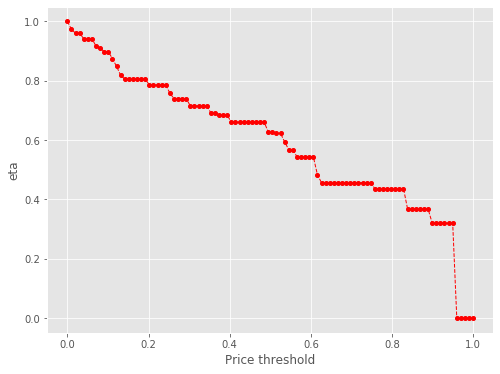

950 32
Number of cells with price above 26.0th percentile:  32


eta =  1.0
eta =  0.9861255950792568
eta =  0.9861255950792568
eta =  0.9671255327168737
eta =  0.9671255327168737
eta =  0.9494167071117802
eta =  0.9343988001846196
eta =  0.9343988001846196
eta =  0.92255223248023
eta =  0.92255223248023
eta =  0.8980970514233068
eta =  0.8715533619154093
eta =  0.8403317636399023
eta =  0.8275907038387341
eta =  0.8275907038387341
eta =  0.8275907038387341
eta =  0.8275907038387341
eta =  0.8275907038387341
eta =  0.8072558920512823
eta =  0.8072558920512823
eta =  0.8072558920512823
eta =  0.8072558920512823
eta =  0.8072558920512823
eta =  0.8072558920512823
eta =  0.7789430852935183
eta =  0.7596793015283884
eta =  0.7596793015283884
eta =  0.7596793015283884
eta =  0.7596793015283884
eta =  0.7347384615452425
eta =  0.7347384615452425
eta =  0.7347384615452425
eta =  0.7347384615452425
eta =  0.7347384615452425
eta =  0.7347384615452425
eta =  0.7106649505056016
eta =  0.7021096909555553
eta =  0.7021096909555553
eta =  0.7021096909555553
eta =

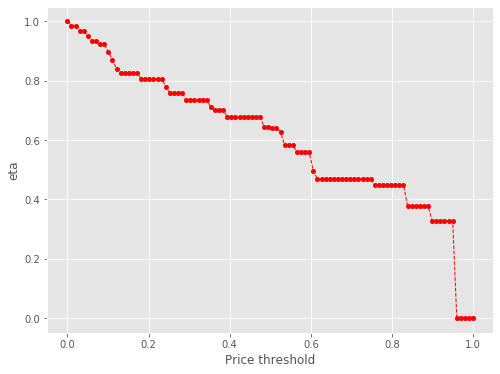

950 31
Number of cells with price above 27.0th percentile:  31


eta =  1.0
eta =  0.9807326141242121
eta =  0.9807326141242121
eta =  0.9547491093433279
eta =  0.9475454291494384
eta =  0.9355321848289343
eta =  0.9355321848289343
eta =  0.9107329288528658
eta =  0.9107329288528658
eta =  0.883815779921381
eta =  0.8521549058589877
eta =  0.8392345842845902
eta =  0.8392345842845902
eta =  0.8392345842845902
eta =  0.8392345842845902
eta =  0.8392345842845902
eta =  0.8186136695766442
eta =  0.8186136695766442
eta =  0.8186136695766442
eta =  0.8186136695766442
eta =  0.8186136695766442
eta =  0.8186136695766442
eta =  0.7899025126012607
eta =  0.7703676948648022
eta =  0.7703676948648022
eta =  0.7703676948648022
eta =  0.7703676948648022
eta =  0.7703676948648022
eta =  0.7450759469296506
eta =  0.7450759469296506
eta =  0.7450759469296506
eta =  0.7450759469296506
eta =  0.7450759469296506
eta =  0.7206637309200804
eta =  0.7119881021840078
eta =  0.7119881021840078
eta =  0.7119881021840078
eta =  0.6878343079584652
eta =  0.6878343079584652
et

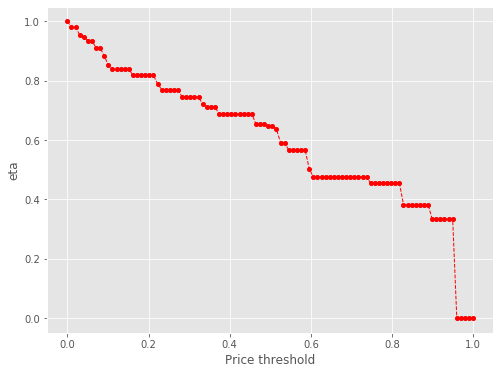

950 30
Number of cells with price above 28.000000000000004th percentile:  30


eta =  1.0
eta =  0.9735060255907904
eta =  0.9661608225352946
eta =  0.9539115670833059
eta =  0.9539115670833059
eta =  0.9286251071258036
eta =  0.9172808291783686
eta =  0.8688962654922581
eta =  0.8688962654922581
eta =  0.8557221124271689
eta =  0.8557221124271689
eta =  0.8557221124271689
eta =  0.8557221124271689
eta =  0.8557221124271689
eta =  0.834696081059424
eta =  0.834696081059424
eta =  0.834696081059424
eta =  0.834696081059424
eta =  0.834696081059424
eta =  0.834696081059424
eta =  0.8054208672428402
eta =  0.7855022702112702
eta =  0.7855022702112702
eta =  0.7855022702112702
eta =  0.7855022702112702
eta =  0.7855022702112702
eta =  0.7597136428413759
eta =  0.7597136428413759
eta =  0.7597136428413759
eta =  0.7597136428413759
eta =  0.7597136428413759
eta =  0.7348218266031955
eta =  0.7348218266031955
eta =  0.7259757572351243
eta =  0.7259757572351243
eta =  0.7259757572351243
eta =  0.7013474397124
eta =  0.7013474397124
eta =  0.7013474397124
eta =  0.7013474

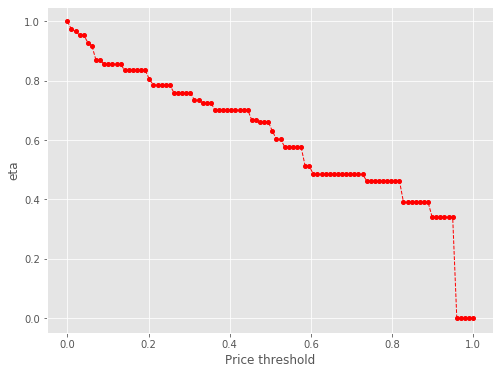

950 30
Number of cells with price above 29.000000000000004th percentile:  30


eta =  1.0
eta =  0.9735060255907904
eta =  0.9661608225352946
eta =  0.9539115670833059
eta =  0.9539115670833059
eta =  0.9286251071258036
eta =  0.9172808291783686
eta =  0.8688962654922581
eta =  0.8688962654922581
eta =  0.8557221124271689
eta =  0.8557221124271689
eta =  0.8557221124271689
eta =  0.8557221124271689
eta =  0.8557221124271689
eta =  0.834696081059424
eta =  0.834696081059424
eta =  0.834696081059424
eta =  0.834696081059424
eta =  0.834696081059424
eta =  0.834696081059424
eta =  0.8054208672428402
eta =  0.7855022702112702
eta =  0.7855022702112702
eta =  0.7855022702112702
eta =  0.7855022702112702
eta =  0.7855022702112702
eta =  0.7597136428413759
eta =  0.7597136428413759
eta =  0.7597136428413759
eta =  0.7597136428413759
eta =  0.7597136428413759
eta =  0.7348218266031955
eta =  0.7348218266031955
eta =  0.7259757572351243
eta =  0.7259757572351243
eta =  0.7259757572351243
eta =  0.7013474397124
eta =  0.7013474397124
eta =  0.7013474397124
eta =  0.7013474

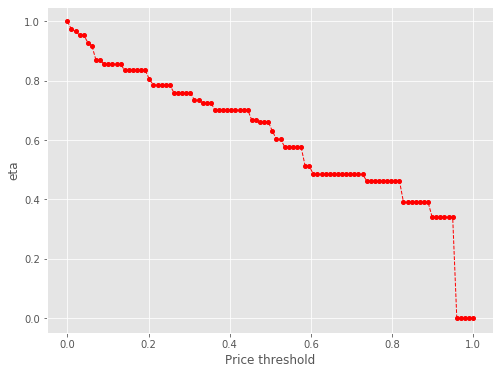

950 29
Number of cells with price above 30.0th percentile:  29


eta =  1.0
eta =  0.9841819647635585
eta =  0.9717042322614329
eta =  0.9717042322614329
eta =  0.9459461211246293
eta =  0.9459461211246293
eta =  0.917988229390613
eta =  0.8851031979374735
eta =  0.8716833163346653
eta =  0.8716833163346653
eta =  0.8716833163346653
eta =  0.8716833163346653
eta =  0.8716833163346653
eta =  0.8716833163346653
eta =  0.8502651006711635
eta =  0.8502651006711635
eta =  0.8502651006711635
eta =  0.8502651006711635
eta =  0.8502651006711635
eta =  0.8204438361561389
eta =  0.8204438361561389
eta =  0.800153711050028
eta =  0.800153711050028
eta =  0.800153711050028
eta =  0.800153711050028
eta =  0.800153711050028
eta =  0.773884065912838
eta =  0.773884065912838
eta =  0.773884065912838
eta =  0.773884065912838
eta =  0.773884065912838
eta =  0.7485279595168648
eta =  0.7395168904194268
eta =  0.7395168904194268
eta =  0.7395168904194268
eta =  0.7395168904194268
eta =  0.7144291976016505
eta =  0.7144291976016505
eta =  0.7144291976016505
eta =  0.714

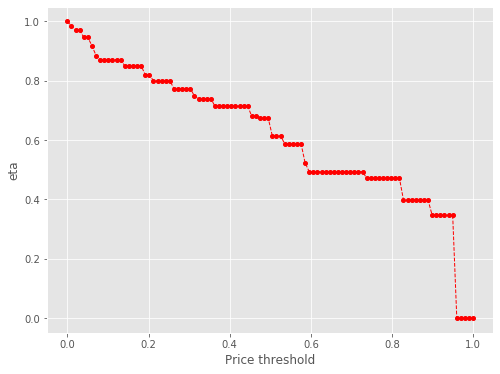

950 27
Number of cells with price above 31.0th percentile:  27


eta =  1.0
eta =  0.9873217220505324
eta =  0.9873217220505324
eta =  0.9611496196761592
eta =  0.9327423812436475
eta =  0.89932881278729
eta =  0.8856932432653143
eta =  0.8856932432653143
eta =  0.8856932432653143
eta =  0.8856932432653143
eta =  0.8856932432653143
eta =  0.8856932432653143
eta =  0.8639307883226987
eta =  0.8639307883226987
eta =  0.8639307883226987
eta =  0.8639307883226987
eta =  0.8639307883226987
eta =  0.8639307883226987
eta =  0.8336302284844691
eta =  0.8130139950717937
eta =  0.8130139950717937
eta =  0.8130139950717937
eta =  0.8130139950717937
eta =  0.8130139950717937
eta =  0.7863221371860408
eta =  0.7863221371860408
eta =  0.7863221371860408
eta =  0.7863221371860408
eta =  0.7863221371860408
eta =  0.7605585006799962
eta =  0.7605585006799962
eta =  0.7514026032747813
eta =  0.7514026032747813
eta =  0.7514026032747813
eta =  0.7259116943616074
eta =  0.7259116943616074
eta =  0.7259116943616074
eta =  0.7259116943616074
eta =  0.7259116943616074
eta

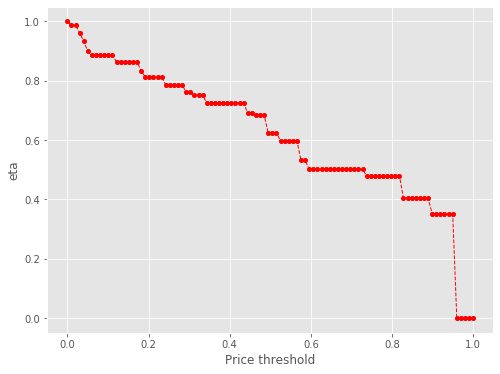

950 26
Number of cells with price above 32.0th percentile:  26


eta =  1.0
eta =  0.973491819545895
eta =  0.9447198014710635
eta =  0.9108771666843376
eta =  0.9108771666843376
eta =  0.8970665017131907
eta =  0.8970665017131907
eta =  0.8970665017131907
eta =  0.8970665017131907
eta =  0.8970665017131907
eta =  0.8750245933295506
eta =  0.8750245933295506
eta =  0.8750245933295506
eta =  0.8750245933295506
eta =  0.8750245933295506
eta =  0.8750245933295506
eta =  0.8443349415559631
eta =  0.8234539734254754
eta =  0.8234539734254754
eta =  0.8234539734254754
eta =  0.8234539734254754
eta =  0.8234539734254754
eta =  0.7964193632375038
eta =  0.7964193632375038
eta =  0.7964193632375038
eta =  0.7964193632375038
eta =  0.7964193632375038
eta =  0.7964193632375038
eta =  0.7703248937949223
eta =  0.7703248937949223
eta =  0.7610514247718775
eta =  0.7610514247718775
eta =  0.7610514247718775
eta =  0.7352331850392069
eta =  0.7352331850392069
eta =  0.7352331850392069
eta =  0.7352331850392069
eta =  0.7352331850392069
eta =  0.7352331850392069
et

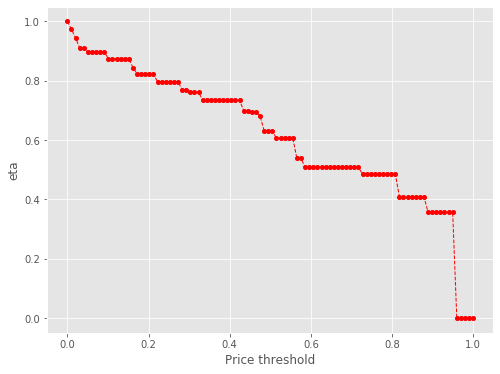

950 25
Number of cells with price above 33.0th percentile:  25


eta =  1.0
eta =  0.970444519925958
eta =  0.9356803502562915
eta =  0.9214936209034047
eta =  0.9214936209034047
eta =  0.9214936209034047
eta =  0.9214936209034047
eta =  0.9214936209034047
eta =  0.9214936209034047
eta =  0.8988515113950557
eta =  0.8988515113950557
eta =  0.8988515113950557
eta =  0.8988515113950557
eta =  0.8988515113950557
eta =  0.8988515113950557
eta =  0.867326180460171
eta =  0.8458766236059304
eta =  0.8458766236059304
eta =  0.8458766236059304
eta =  0.8458766236059304
eta =  0.8458766236059304
eta =  0.8181058610323092
eta =  0.8181058610323092
eta =  0.8181058610323092
eta =  0.8181058610323092
eta =  0.8181058610323092
eta =  0.8181058610323092
eta =  0.7913008392348442
eta =  0.7913008392348442
eta =  0.7817748536673736
eta =  0.7817748536673736
eta =  0.7817748536673736
eta =  0.755253583314312
eta =  0.755253583314312
eta =  0.755253583314312
eta =  0.755253583314312
eta =  0.755253583314312
eta =  0.755253583314312
eta =  0.755253583314312
eta =  0.7

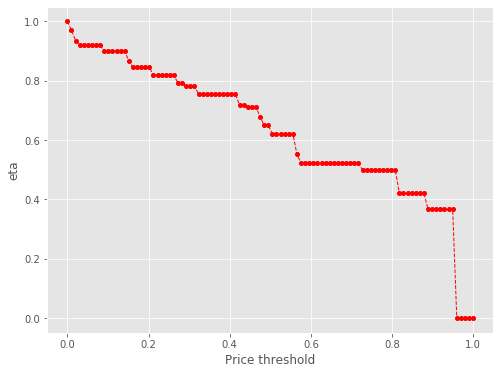

950 23
Number of cells with price above 34.0th percentile:  23


eta =  1.0
eta =  0.9641770663279968
eta =  0.9495582714751297
eta =  0.9495582714751297
eta =  0.9495582714751297
eta =  0.9495582714751297
eta =  0.9495582714751297
eta =  0.9495582714751297
eta =  0.9262265827042182
eta =  0.9262265827042182
eta =  0.9262265827042182
eta =  0.9262265827042182
eta =  0.9262265827042182
eta =  0.9262265827042182
eta =  0.8937411285771858
eta =  0.8716383123792263
eta =  0.8716383123792263
eta =  0.8716383123792263
eta =  0.8716383123792263
eta =  0.8716383123792263
eta =  0.8430217742841479
eta =  0.8430217742841479
eta =  0.8430217742841479
eta =  0.8430217742841479
eta =  0.8430217742841479
eta =  0.8430217742841479
eta =  0.8154003891899128
eta =  0.8154003891899128
eta =  0.805584283918694
eta =  0.805584283918694
eta =  0.805584283918694
eta =  0.7782552920922626
eta =  0.7782552920922626
eta =  0.7782552920922626
eta =  0.7782552920922626
eta =  0.7782552920922626
eta =  0.7782552920922626
eta =  0.7782552920922626
eta =  0.7782552920922626
eta 

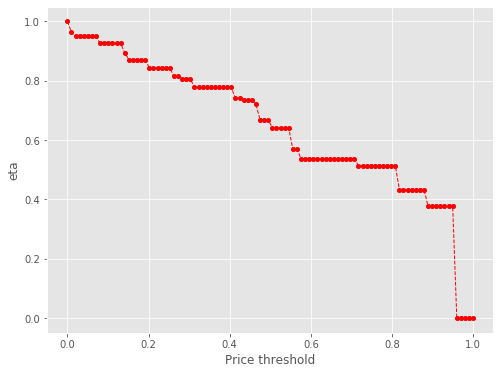

950 22
Number of cells with price above 35.0th percentile:  22


eta =  1.0
eta =  0.9848380599752886
eta =  0.9848380599752886
eta =  0.9848380599752886
eta =  0.9848380599752886
eta =  0.9848380599752886
eta =  0.9848380599752886
eta =  0.9606395080850548
eta =  0.9606395080850548
eta =  0.9606395080850548
eta =  0.9606395080850548
eta =  0.9606395080850548
eta =  0.9269470928000169
eta =  0.9269470928000169
eta =  0.9040230708855188
eta =  0.9040230708855188
eta =  0.9040230708855188
eta =  0.9040230708855188
eta =  0.9040230708855188
eta =  0.8743433169332053
eta =  0.8743433169332053
eta =  0.8743433169332053
eta =  0.8743433169332053
eta =  0.8743433169332053
eta =  0.8743433169332053
eta =  0.8456956897920317
eta =  0.8456956897920317
eta =  0.8355148779743407
eta =  0.8355148779743407
eta =  0.8355148779743407
eta =  0.8071705076497985
eta =  0.8071705076497985
eta =  0.8071705076497985
eta =  0.8071705076497985
eta =  0.8071705076497985
eta =  0.8071705076497985
eta =  0.8071705076497985
eta =  0.8071705076497985
eta =  0.8071705076497985
e

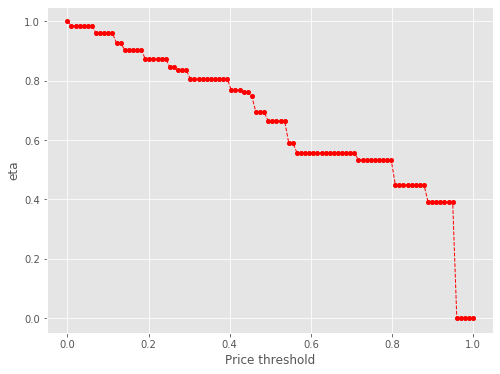

950 21
Number of cells with price above 36.00000000000001th percentile:  21


eta =  1.0
eta =  0.9754289026047176
eta =  0.9754289026047176
eta =  0.9754289026047176
eta =  0.9754289026047176
eta =  0.9754289026047176
eta =  0.9754289026047176
eta =  0.9412177803356581
eta =  0.9179408347685124
eta =  0.9179408347685124
eta =  0.9179408347685124
eta =  0.9179408347685124
eta =  0.9179408347685124
eta =  0.9179408347685124
eta =  0.8878041502124158
eta =  0.8878041502124158
eta =  0.8878041502124158
eta =  0.8878041502124158
eta =  0.8878041502124158
eta =  0.8878041502124158
eta =  0.8587154824350022
eta =  0.8587154824350022
eta =  0.8483779333175905
eta =  0.8483779333175905
eta =  0.8483779333175905
eta =  0.8483779333175905
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.7795962410858965
eta =  0.7795962410858965
eta =  0.7795962410858965
e

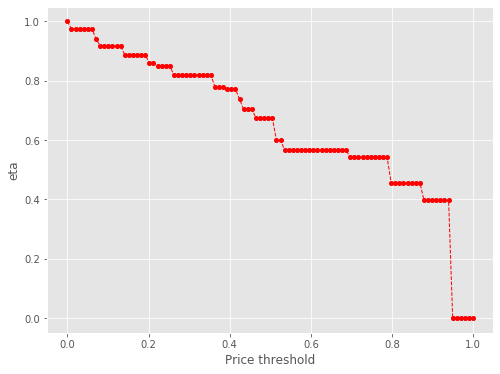

950 21
Number of cells with price above 37.0th percentile:  21


eta =  1.0
eta =  0.9754289026047176
eta =  0.9754289026047176
eta =  0.9754289026047176
eta =  0.9754289026047176
eta =  0.9754289026047176
eta =  0.9754289026047176
eta =  0.9412177803356581
eta =  0.9179408347685124
eta =  0.9179408347685124
eta =  0.9179408347685124
eta =  0.9179408347685124
eta =  0.9179408347685124
eta =  0.9179408347685124
eta =  0.8878041502124158
eta =  0.8878041502124158
eta =  0.8878041502124158
eta =  0.8878041502124158
eta =  0.8878041502124158
eta =  0.8878041502124158
eta =  0.8587154824350022
eta =  0.8587154824350022
eta =  0.8483779333175905
eta =  0.8483779333175905
eta =  0.8483779333175905
eta =  0.8483779333175905
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.7795962410858965
eta =  0.7795962410858965
eta =  0.7795962410858965
e

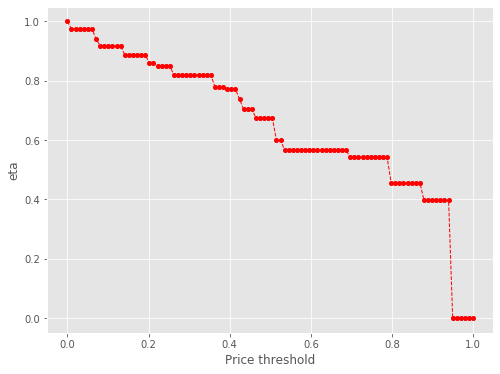

950 21
Number of cells with price above 38.0th percentile:  21


eta =  1.0
eta =  0.9754289026047176
eta =  0.9754289026047176
eta =  0.9754289026047176
eta =  0.9754289026047176
eta =  0.9754289026047176
eta =  0.9754289026047176
eta =  0.9412177803356581
eta =  0.9179408347685124
eta =  0.9179408347685124
eta =  0.9179408347685124
eta =  0.9179408347685124
eta =  0.9179408347685124
eta =  0.9179408347685124
eta =  0.8878041502124158
eta =  0.8878041502124158
eta =  0.8878041502124158
eta =  0.8878041502124158
eta =  0.8878041502124158
eta =  0.8878041502124158
eta =  0.8587154824350022
eta =  0.8587154824350022
eta =  0.8483779333175905
eta =  0.8483779333175905
eta =  0.8483779333175905
eta =  0.8483779333175905
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.7795962410858965
eta =  0.7795962410858965
eta =  0.7795962410858965
e

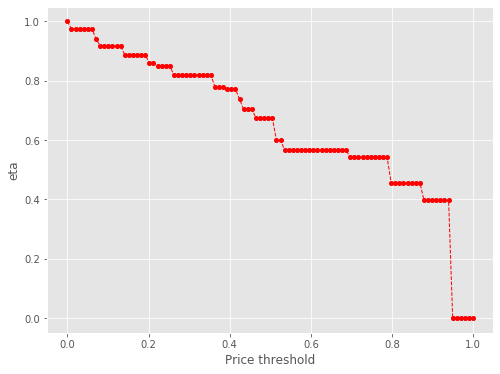

950 21
Number of cells with price above 39.0th percentile:  21


eta =  1.0
eta =  0.9754289026047176
eta =  0.9754289026047176
eta =  0.9754289026047176
eta =  0.9754289026047176
eta =  0.9754289026047176
eta =  0.9754289026047176
eta =  0.9412177803356581
eta =  0.9179408347685124
eta =  0.9179408347685124
eta =  0.9179408347685124
eta =  0.9179408347685124
eta =  0.9179408347685124
eta =  0.9179408347685124
eta =  0.8878041502124158
eta =  0.8878041502124158
eta =  0.8878041502124158
eta =  0.8878041502124158
eta =  0.8878041502124158
eta =  0.8878041502124158
eta =  0.8587154824350022
eta =  0.8587154824350022
eta =  0.8483779333175905
eta =  0.8483779333175905
eta =  0.8483779333175905
eta =  0.8483779333175905
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.8195971911057659
eta =  0.7795962410858965
eta =  0.7795962410858965
eta =  0.7795962410858965
e

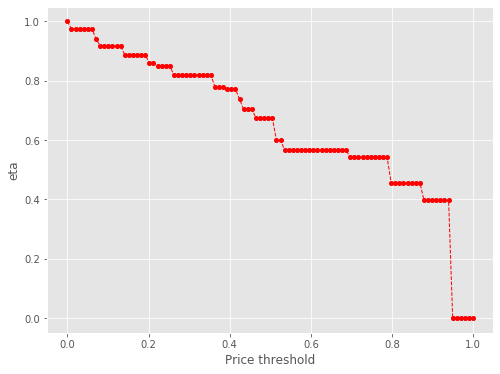

950 20
Number of cells with price above 40.0th percentile:  20


eta =  1.0
eta =  0.96492709804097
eta =  0.9410638051807846
eta =  0.9410638051807846
eta =  0.9410638051807846
eta =  0.9410638051807846
eta =  0.9410638051807846
eta =  0.9410638051807846
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.8803465635905887
eta =  0.8803465635905887
eta =  0.8697486111516083
eta =  0.8697486111516083
eta =  0.8697486111516083
eta =  0.8697486111516083
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.7992343050366018
eta =  0.7992343050366018
eta =  0.7992343050366018
eta =  0.7923021285406546
eta =  0.7923021285406546
eta =  0.7923021285406546
eta =  0.7785029104366052
eta

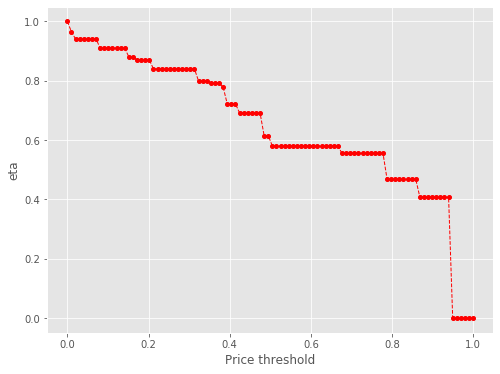

950 20
Number of cells with price above 41.0th percentile:  20


eta =  1.0
eta =  0.96492709804097
eta =  0.9410638051807846
eta =  0.9410638051807846
eta =  0.9410638051807846
eta =  0.9410638051807846
eta =  0.9410638051807846
eta =  0.9410638051807846
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.8803465635905887
eta =  0.8803465635905887
eta =  0.8697486111516083
eta =  0.8697486111516083
eta =  0.8697486111516083
eta =  0.8697486111516083
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.7992343050366018
eta =  0.7992343050366018
eta =  0.7992343050366018
eta =  0.7923021285406546
eta =  0.7923021285406546
eta =  0.7923021285406546
eta =  0.7785029104366052
eta

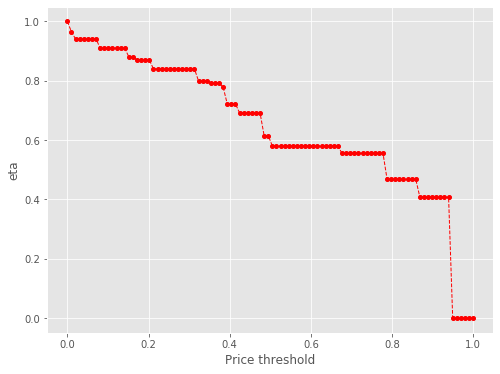

950 20
Number of cells with price above 42.00000000000001th percentile:  20


eta =  1.0
eta =  0.96492709804097
eta =  0.9410638051807846
eta =  0.9410638051807846
eta =  0.9410638051807846
eta =  0.9410638051807846
eta =  0.9410638051807846
eta =  0.9410638051807846
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.8803465635905887
eta =  0.8803465635905887
eta =  0.8697486111516083
eta =  0.8697486111516083
eta =  0.8697486111516083
eta =  0.8697486111516083
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.7992343050366018
eta =  0.7992343050366018
eta =  0.7992343050366018
eta =  0.7923021285406546
eta =  0.7923021285406546
eta =  0.7923021285406546
eta =  0.7785029104366052
eta

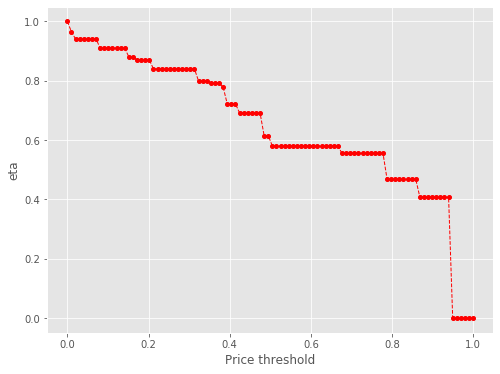

950 20
Number of cells with price above 43.0th percentile:  20


eta =  1.0
eta =  0.96492709804097
eta =  0.9410638051807846
eta =  0.9410638051807846
eta =  0.9410638051807846
eta =  0.9410638051807846
eta =  0.9410638051807846
eta =  0.9410638051807846
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.9101679762017357
eta =  0.8803465635905887
eta =  0.8803465635905887
eta =  0.8697486111516083
eta =  0.8697486111516083
eta =  0.8697486111516083
eta =  0.8697486111516083
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.8402428807647288
eta =  0.7992343050366018
eta =  0.7992343050366018
eta =  0.7992343050366018
eta =  0.7923021285406546
eta =  0.7923021285406546
eta =  0.7923021285406546
eta =  0.7785029104366052
eta

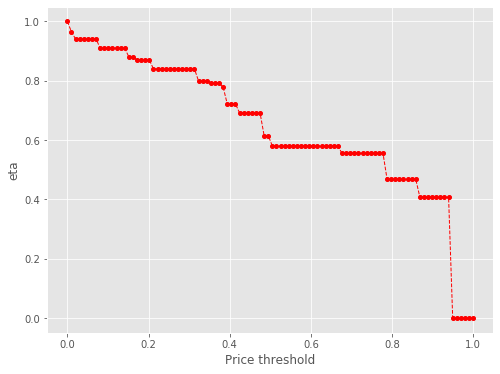

950 19
Number of cells with price above 44.0th percentile:  19


eta =  1.0
eta =  0.975269330803712
eta =  0.975269330803712
eta =  0.975269330803712
eta =  0.975269330803712
eta =  0.975269330803712
eta =  0.975269330803712
eta =  0.9432505088203987
eta =  0.9432505088203987
eta =  0.9432505088203987
eta =  0.9432505088203987
eta =  0.9432505088203987
eta =  0.9432505088203987
eta =  0.912345155792495
eta =  0.912345155792495
eta =  0.901361991923953
eta =  0.901361991923953
eta =  0.901361991923953
eta =  0.901361991923953
eta =  0.8707837954500608
eta =  0.8707837954500608
eta =  0.8707837954500608
eta =  0.8707837954500608
eta =  0.8707837954500608
eta =  0.8707837954500608
eta =  0.8707837954500608
eta =  0.8707837954500608
eta =  0.8707837954500608
eta =  0.8707837954500608
eta =  0.8707837954500608
eta =  0.8707837954500608
eta =  0.8282846514096622
eta =  0.8282846514096622
eta =  0.8282846514096622
eta =  0.8211005060892322
eta =  0.8211005060892322
eta =  0.8211005060892322
eta =  0.7833030113917849
eta =  0.7485821403865944
eta =  0.7485

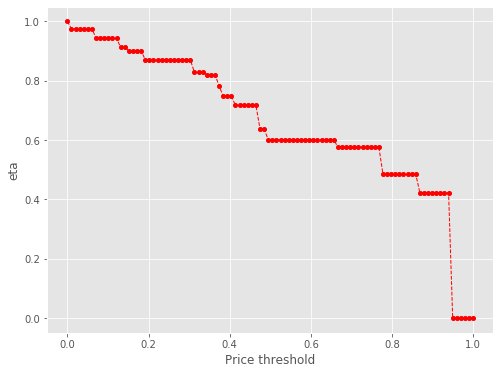

950 18
Number of cells with price above 45.0th percentile:  18


eta =  1.0
eta =  0.9671692516395171
eta =  0.9671692516395171
eta =  0.9671692516395171
eta =  0.9671692516395171
eta =  0.9671692516395171
eta =  0.9671692516395171
eta =  0.9671692516395171
eta =  0.9354802073398928
eta =  0.9354802073398928
eta =  0.9242185347724895
eta =  0.9242185347724895
eta =  0.9242185347724895
eta =  0.9242185347724895
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8492881148298586
eta =  0.8492881148298586
eta =  0.8492881148298586
eta =  0.8419217955029608
eta =  0.8419217955029608
eta =  0.8419217955029608
eta =  0.8419217955029608
eta =  0.8031658400928806
eta =  0.7675645247346121
eta =  0.7675645247346121
eta =  0.7675645247346121
eta =  0.7353118937331771
eta =  0.7353118937331771
e

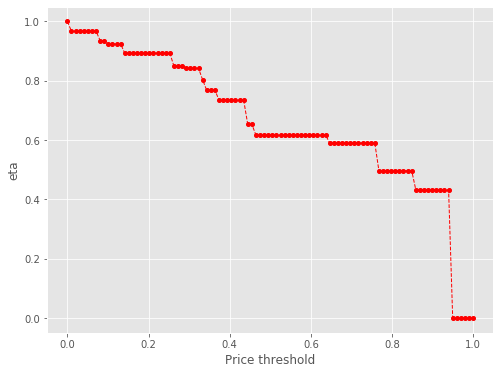

950 18
Number of cells with price above 46.0th percentile:  18


eta =  1.0
eta =  0.9671692516395171
eta =  0.9671692516395171
eta =  0.9671692516395171
eta =  0.9671692516395171
eta =  0.9671692516395171
eta =  0.9671692516395171
eta =  0.9671692516395171
eta =  0.9354802073398928
eta =  0.9354802073398928
eta =  0.9242185347724895
eta =  0.9242185347724895
eta =  0.9242185347724895
eta =  0.9242185347724895
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8492881148298586
eta =  0.8492881148298586
eta =  0.8492881148298586
eta =  0.8419217955029608
eta =  0.8419217955029608
eta =  0.8419217955029608
eta =  0.8419217955029608
eta =  0.8031658400928806
eta =  0.7675645247346121
eta =  0.7675645247346121
eta =  0.7675645247346121
eta =  0.7353118937331771
eta =  0.7353118937331771
e

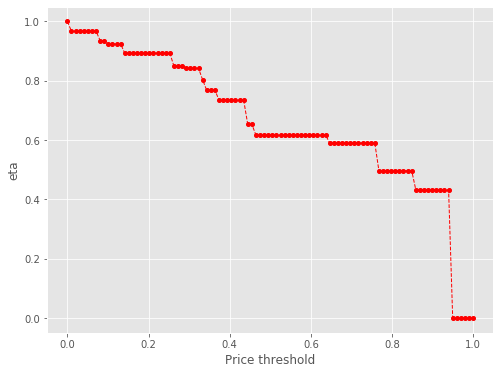

950 18
Number of cells with price above 47.0th percentile:  18


eta =  1.0
eta =  0.9671692516395171
eta =  0.9671692516395171
eta =  0.9671692516395171
eta =  0.9671692516395171
eta =  0.9671692516395171
eta =  0.9671692516395171
eta =  0.9671692516395171
eta =  0.9354802073398928
eta =  0.9354802073398928
eta =  0.9242185347724895
eta =  0.9242185347724895
eta =  0.9242185347724895
eta =  0.9242185347724895
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8928649429921626
eta =  0.8492881148298586
eta =  0.8492881148298586
eta =  0.8492881148298586
eta =  0.8419217955029608
eta =  0.8419217955029608
eta =  0.8419217955029608
eta =  0.8419217955029608
eta =  0.8031658400928806
eta =  0.7675645247346121
eta =  0.7675645247346121
eta =  0.7675645247346121
eta =  0.7353118937331771
eta =  0.7353118937331771
e

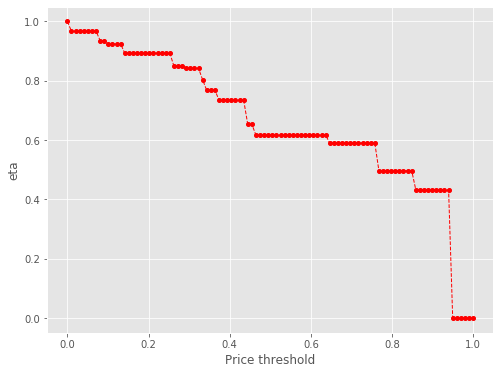

950 17
Number of cells with price above 48.00000000000001th percentile:  17


eta =  1.0
eta =  0.9672352649281333
eta =  0.9672352649281333
eta =  0.955591312695044
eta =  0.955591312695044
eta =  0.955591312695044
eta =  0.955591312695044
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.8781173650735589
eta =  0.8781173650735589
eta =  0.8781173650735589
eta =  0.8705009946043668
eta =  0.8705009946043668
eta =  0.8705009946043668
eta =  0.8553398172559442
eta =  0.8304294607498919
eta =  0.793619651817362
eta =  0.793619651817362
eta =  0.793619651817362
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0

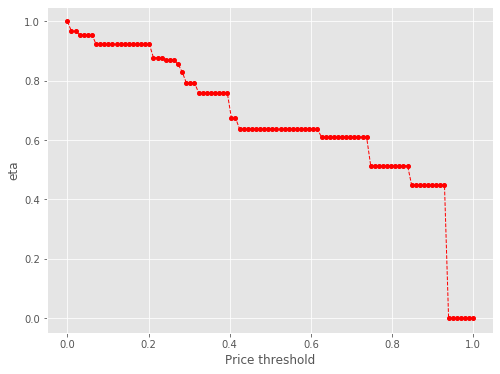

950 17
Number of cells with price above 49.0th percentile:  17


eta =  1.0
eta =  0.9672352649281333
eta =  0.9672352649281333
eta =  0.955591312695044
eta =  0.955591312695044
eta =  0.955591312695044
eta =  0.955591312695044
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.8781173650735589
eta =  0.8781173650735589
eta =  0.8781173650735589
eta =  0.8705009946043668
eta =  0.8705009946043668
eta =  0.8705009946043668
eta =  0.8553398172559442
eta =  0.8304294607498919
eta =  0.793619651817362
eta =  0.793619651817362
eta =  0.793619651817362
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0

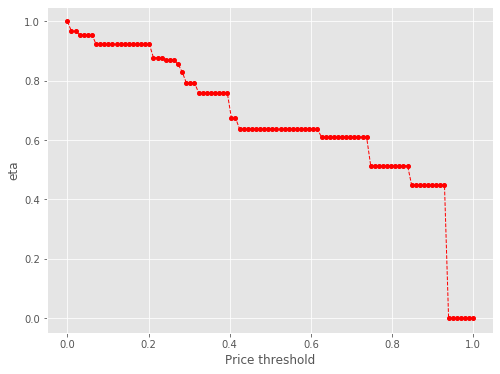

950 17
Number of cells with price above 50.0th percentile:  17


eta =  1.0
eta =  0.9672352649281333
eta =  0.9672352649281333
eta =  0.955591312695044
eta =  0.955591312695044
eta =  0.955591312695044
eta =  0.955591312695044
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.8781173650735589
eta =  0.8781173650735589
eta =  0.8781173650735589
eta =  0.8705009946043668
eta =  0.8705009946043668
eta =  0.8705009946043668
eta =  0.8553398172559442
eta =  0.8304294607498919
eta =  0.793619651817362
eta =  0.793619651817362
eta =  0.793619651817362
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0

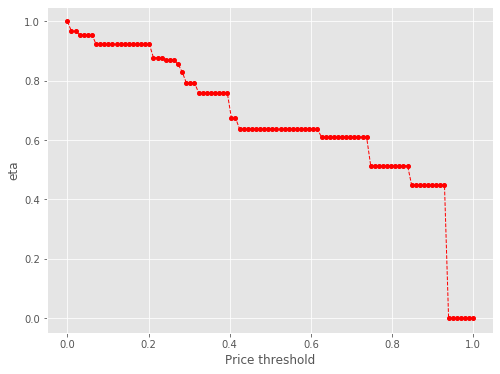

950 17
Number of cells with price above 51.0th percentile:  17


eta =  1.0
eta =  0.9672352649281333
eta =  0.9672352649281333
eta =  0.955591312695044
eta =  0.955591312695044
eta =  0.955591312695044
eta =  0.955591312695044
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.9231734171434874
eta =  0.8781173650735589
eta =  0.8781173650735589
eta =  0.8781173650735589
eta =  0.8705009946043668
eta =  0.8705009946043668
eta =  0.8705009946043668
eta =  0.8553398172559442
eta =  0.8304294607498919
eta =  0.793619651817362
eta =  0.793619651817362
eta =  0.793619651817362
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0.7602721989834745
eta =  0

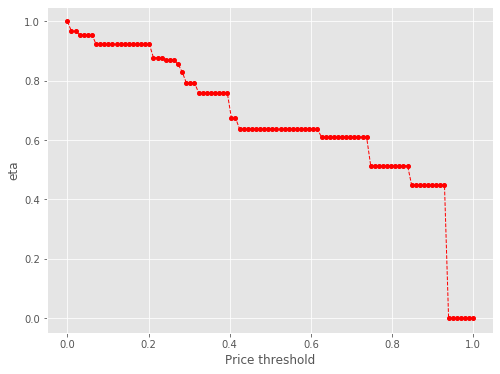

950 16
Number of cells with price above 52.0th percentile:  16


eta =  1.0
eta =  0.9879616132131468
eta =  0.9879616132131468
eta =  0.9879616132131468
eta =  0.9879616132131468
eta =  0.9544455734997217
eta =  0.9544455734997217
eta =  0.9544455734997217
eta =  0.9544455734997217
eta =  0.9544455734997217
eta =  0.9544455734997217
eta =  0.9544455734997217
eta =  0.9544455734997217
eta =  0.9544455734997217
eta =  0.9544455734997217
eta =  0.9544455734997217
eta =  0.9544455734997217
eta =  0.9544455734997217
eta =  0.9544455734997217
eta =  0.9078632644135488
eta =  0.9078632644135488
eta =  0.9078632644135488
eta =  0.8999888922257668
eta =  0.8999888922257668
eta =  0.8999888922257668
eta =  0.8999888922257668
eta =  0.8843141356301737
eta =  0.8205032225291422
eta =  0.8205032225291422
eta =  0.8205032225291422
eta =  0.8205032225291422
eta =  0.7860261371259697
eta =  0.7860261371259697
eta =  0.7860261371259697
eta =  0.7860261371259697
eta =  0.7860261371259697
eta =  0.7860261371259697
eta =  0.7860261371259697
eta =  0.6986147302934168
e

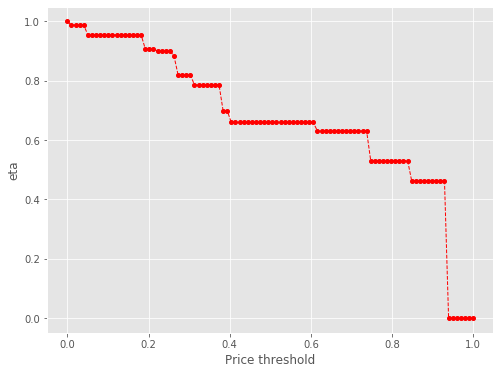

950 15
Number of cells with price above 53.0th percentile:  15


eta =  1.0
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9189256467778194
eta =  0.9189256467778194
eta =  0.9189256467778194
eta =  0.9109553247709024
eta =  0.9109553247709024
eta =  0.9109553247709024
eta =  0.9109553247709024
eta =  0.8950895700837196
eta =  0.8305011161927843
eta =  0.8305011161927843
eta =  0.8305011161927843
eta =  0.8305011161927843
eta =  0.7956039249030916
eta =  0.7956039249030916
eta =  0.7956039249030916
eta =  0.7956039249030916
eta =  0.7956039249030916
eta =  0.7956039249030916
eta =  0.7956039249030916
eta =  0.7956039249030916
eta =  0.707127403484142
eta =  0.707127403484142
eta =  0.6673007348938255
eta =  0.6673007348938255
eta

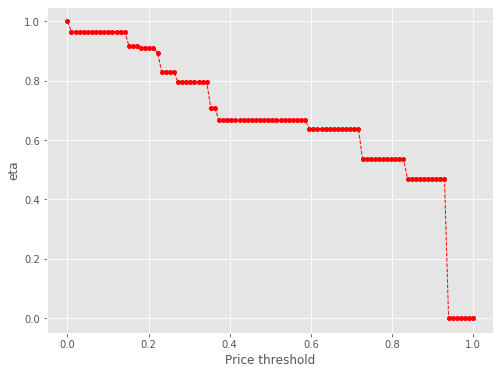

950 15
Number of cells with price above 54.0th percentile:  15


eta =  1.0
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9660755648142837
eta =  0.9189256467778194
eta =  0.9189256467778194
eta =  0.9189256467778194
eta =  0.9109553247709024
eta =  0.9109553247709024
eta =  0.9109553247709024
eta =  0.9109553247709024
eta =  0.8950895700837196
eta =  0.8305011161927843
eta =  0.8305011161927843
eta =  0.8305011161927843
eta =  0.8305011161927843
eta =  0.7956039249030916
eta =  0.7956039249030916
eta =  0.7956039249030916
eta =  0.7956039249030916
eta =  0.7956039249030916
eta =  0.7956039249030916
eta =  0.7956039249030916
eta =  0.7956039249030916
eta =  0.707127403484142
eta =  0.707127403484142
eta =  0.6673007348938255
eta =  0.6673007348938255
eta

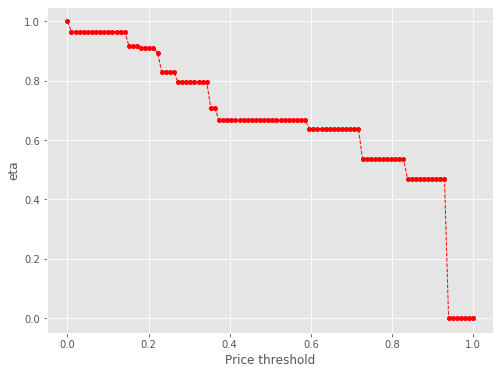

950 14
Number of cells with price above 55.00000000000001th percentile:  14


eta =  1.0
eta =  0.9511943788315065
eta =  0.9511943788315065
eta =  0.9511943788315065
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9265212812372391
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.7319586885732678
eta =  0.7319586885732678
eta =  0.7319586885732678
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
e

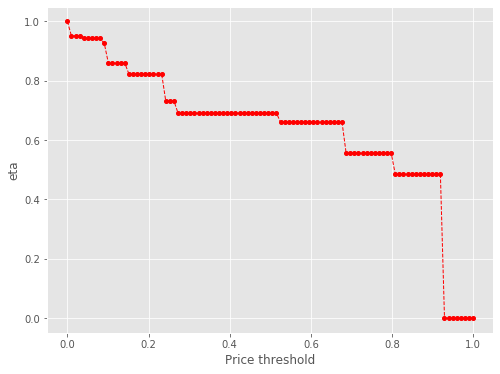

950 14
Number of cells with price above 56.00000000000001th percentile:  14


eta =  1.0
eta =  0.9511943788315065
eta =  0.9511943788315065
eta =  0.9511943788315065
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9265212812372391
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.7319586885732678
eta =  0.7319586885732678
eta =  0.7319586885732678
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
e

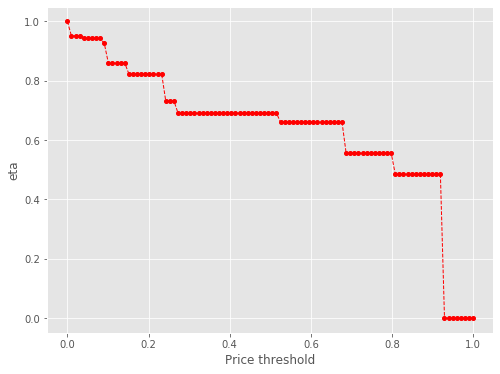

950 14
Number of cells with price above 57.00000000000001th percentile:  14


eta =  1.0
eta =  0.9511943788315065
eta =  0.9511943788315065
eta =  0.9511943788315065
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9265212812372391
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.7319586885732678
eta =  0.7319586885732678
eta =  0.7319586885732678
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
e

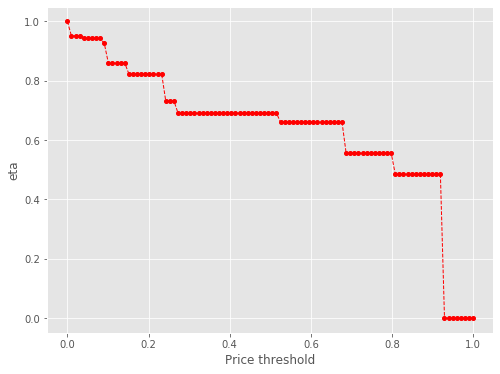

950 14
Number of cells with price above 58.00000000000001th percentile:  14


eta =  1.0
eta =  0.9511943788315065
eta =  0.9511943788315065
eta =  0.9511943788315065
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9265212812372391
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.7319586885732678
eta =  0.7319586885732678
eta =  0.7319586885732678
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
e

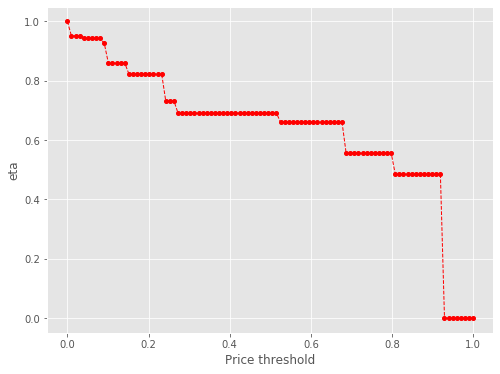

950 14
Number of cells with price above 59.0th percentile:  14


eta =  1.0
eta =  0.9511943788315065
eta =  0.9511943788315065
eta =  0.9511943788315065
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9265212812372391
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.7319586885732678
eta =  0.7319586885732678
eta =  0.7319586885732678
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
e

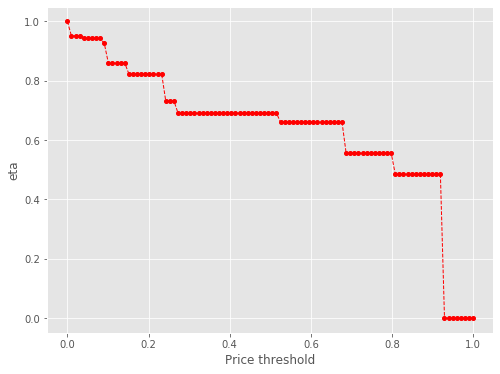

950 14
Number of cells with price above 60.0th percentile:  14


eta =  1.0
eta =  0.9511943788315065
eta =  0.9511943788315065
eta =  0.9511943788315065
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9265212812372391
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.7319586885732678
eta =  0.7319586885732678
eta =  0.7319586885732678
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
e

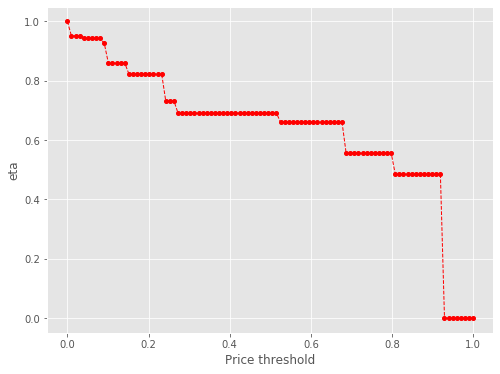

950 14
Number of cells with price above 61.0th percentile:  14


eta =  1.0
eta =  0.9511943788315065
eta =  0.9511943788315065
eta =  0.9511943788315065
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9429441732604245
eta =  0.9265212812372391
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8596647575414434
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.8235421263926045
eta =  0.7319586885732678
eta =  0.7319586885732678
eta =  0.7319586885732678
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
eta =  0.6907334779988001
e

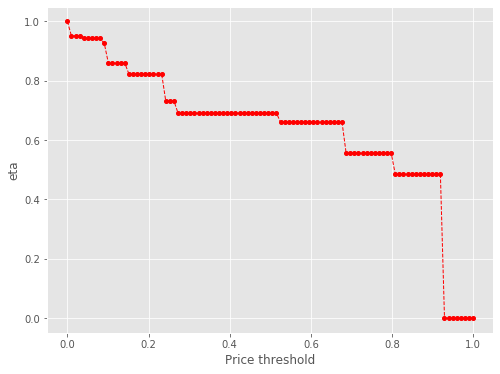

950 13
Number of cells with price above 62.0th percentile:  13


eta =  1.0
eta =  0.9913264777897269
eta =  0.9913264777897269
eta =  0.9913264777897269
eta =  0.9913264777897269
eta =  0.9740609299809183
eta =  0.9456930175618697
eta =  0.9037740094695446
eta =  0.9037740094695446
eta =  0.9037740094695446
eta =  0.9037740094695446
eta =  0.9037740094695446
eta =  0.8657979322841287
eta =  0.8657979322841287
eta =  0.8657979322841287
eta =  0.8657979322841287
eta =  0.8657979322841287
eta =  0.8657979322841287
eta =  0.8657979322841287
eta =  0.8657979322841287
eta =  0.8657979322841287
eta =  0.7695153639074712
eta =  0.7695153639074712
eta =  0.7695153639074712
eta =  0.7261748948173251
eta =  0.7261748948173251
eta =  0.7261748948173251
eta =  0.7261748948173251
eta =  0.7261748948173251
eta =  0.7261748948173251
eta =  0.7261748948173251
eta =  0.7261748948173251
eta =  0.7261748948173251
eta =  0.7261748948173251
eta =  0.7261748948173251
eta =  0.7261748948173251
eta =  0.7261748948173251
eta =  0.7261748948173251
eta =  0.7261748948173251
e

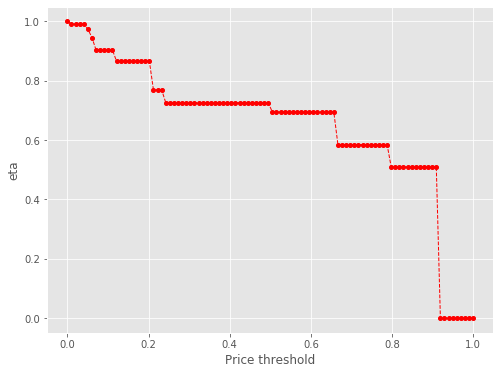

950 12
Number of cells with price above 63.0th percentile:  12


eta =  1.0
eta =  0.9825833888273579
eta =  0.9116814992015644
eta =  0.9116814992015644
eta =  0.9116814992015644
eta =  0.9116814992015644
eta =  0.9116814992015644
eta =  0.8733731537308697
eta =  0.8733731537308697
eta =  0.8733731537308697
eta =  0.8733731537308697
eta =  0.8733731537308697
eta =  0.8733731537308697
eta =  0.8733731537308697
eta =  0.8733731537308697
eta =  0.8733731537308697
eta =  0.8733731537308697
eta =  0.7762481696475935
eta =  0.7762481696475935
eta =  0.7762481696475935
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
e

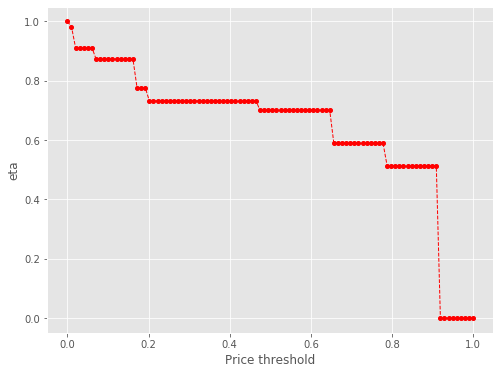

950 12
Number of cells with price above 64.0th percentile:  12


eta =  1.0
eta =  0.9825833888273579
eta =  0.9116814992015644
eta =  0.9116814992015644
eta =  0.9116814992015644
eta =  0.9116814992015644
eta =  0.9116814992015644
eta =  0.8733731537308697
eta =  0.8733731537308697
eta =  0.8733731537308697
eta =  0.8733731537308697
eta =  0.8733731537308697
eta =  0.8733731537308697
eta =  0.8733731537308697
eta =  0.8733731537308697
eta =  0.8733731537308697
eta =  0.8733731537308697
eta =  0.7762481696475935
eta =  0.7762481696475935
eta =  0.7762481696475935
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
eta =  0.7325284970057625
e

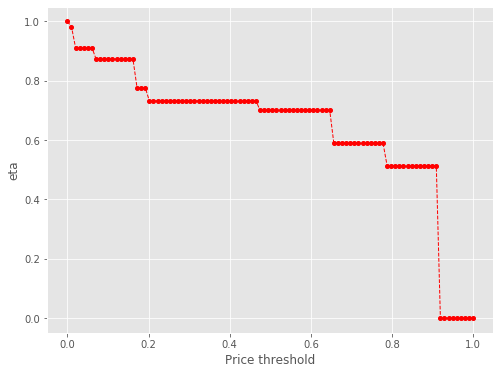

950 11
Number of cells with price above 65.0th percentile:  11


eta =  1.0
eta =  0.9278413512461169
eta =  0.9278413512461169
eta =  0.9278413512461169
eta =  0.9278413512461169
eta =  0.9278413512461169
eta =  0.8888539778523808
eta =  0.8888539778523808
eta =  0.8888539778523808
eta =  0.8888539778523808
eta =  0.8888539778523808
eta =  0.8888539778523808
eta =  0.8888539778523808
eta =  0.8888539778523808
eta =  0.8888539778523808
eta =  0.8888539778523808
eta =  0.7900074217354616
eta =  0.7900074217354616
eta =  0.7900074217354616
eta =  0.7455128036308271
eta =  0.7455128036308271
eta =  0.7455128036308271
eta =  0.7455128036308271
eta =  0.7455128036308271
eta =  0.7455128036308271
eta =  0.7455128036308271
eta =  0.7455128036308271
eta =  0.7455128036308271
eta =  0.7455128036308271
eta =  0.7455128036308271
eta =  0.7455128036308271
eta =  0.7455128036308271
eta =  0.7455128036308271
eta =  0.7455128036308271
eta =  0.7455128036308271
eta =  0.7455128036308271
eta =  0.7455128036308271
eta =  0.7455128036308271
eta =  0.7455128036308271
e

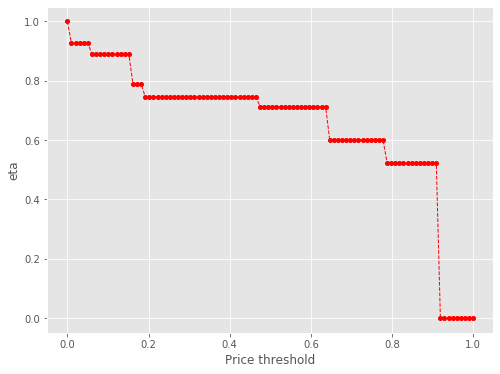

950 9
Number of cells with price above 66.0th percentile:  9


eta =  1.0
eta =  0.9579805606407013
eta =  0.9579805606407013
eta =  0.9579805606407013
eta =  0.9579805606407013
eta =  0.9579805606407013
eta =  0.9579805606407013
eta =  0.9579805606407013
eta =  0.9579805606407013
eta =  0.9579805606407013
eta =  0.9579805606407013
eta =  0.8514466623787132
eta =  0.8514466623787132
eta =  0.8514466623787132
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
e

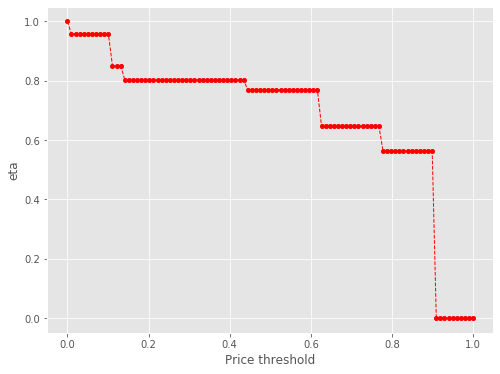

950 9
Number of cells with price above 67.0th percentile:  9


eta =  1.0
eta =  0.9579805606407013
eta =  0.9579805606407013
eta =  0.9579805606407013
eta =  0.9579805606407013
eta =  0.9579805606407013
eta =  0.9579805606407013
eta =  0.9579805606407013
eta =  0.9579805606407013
eta =  0.9579805606407013
eta =  0.9579805606407013
eta =  0.8514466623787132
eta =  0.8514466623787132
eta =  0.8514466623787132
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
eta =  0.803491677353658
e

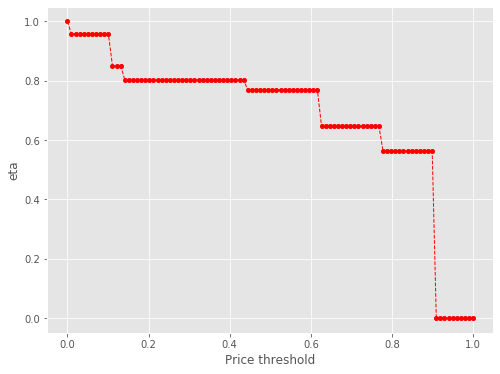

950 8
Number of cells with price above 68.0th percentile:  8


eta =  1.0
eta =  0.8887932567329574
eta =  0.8887932567329574
eta =  0.8887932567329574
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8022799481445613
eta =  0.8022799481445613
e

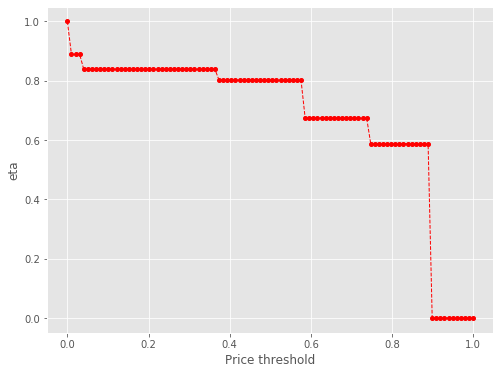

950 8
Number of cells with price above 69.0th percentile:  8


eta =  1.0
eta =  0.8887932567329574
eta =  0.8887932567329574
eta =  0.8887932567329574
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8022799481445613
eta =  0.8022799481445613
e

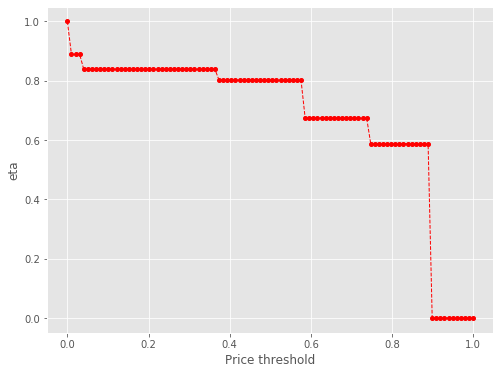

950 8
Number of cells with price above 70.0th percentile:  8


eta =  1.0
eta =  0.8887932567329574
eta =  0.8887932567329574
eta =  0.8887932567329574
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8387348453253368
eta =  0.8022799481445613
eta =  0.8022799481445613
e

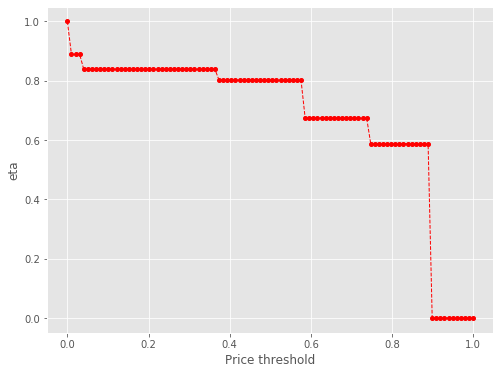

950 7
Number of cells with price above 71.00000000000001th percentile:  7


eta =  1.0
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9436782277223544
eta =  0.9026620556208951
eta =  0.9026620556208951
eta =  0.9026620556208951
eta =  0.9026620556208951
e

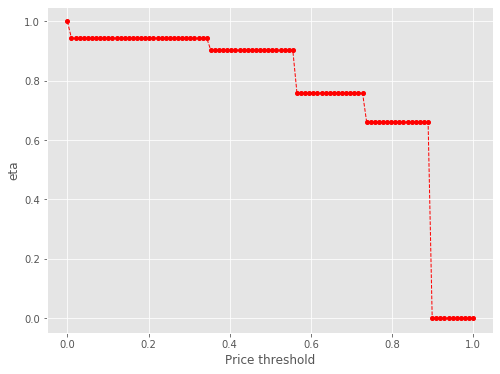

950 6
Number of cells with price above 72.0th percentile:  6


eta =  1.0
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  

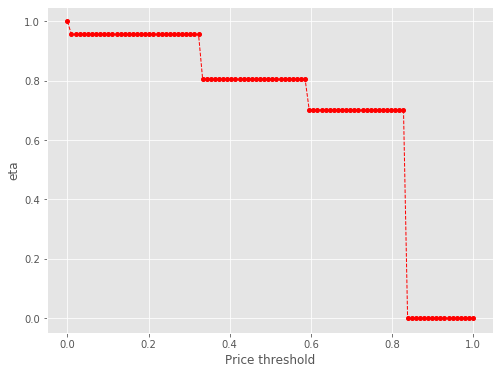

950 6
Number of cells with price above 73.0th percentile:  6


eta =  1.0
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  

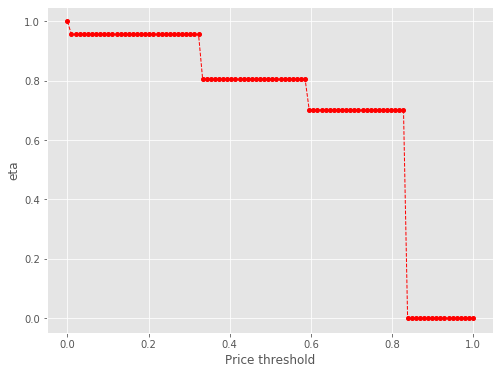

950 6
Number of cells with price above 74.0th percentile:  6


eta =  1.0
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  

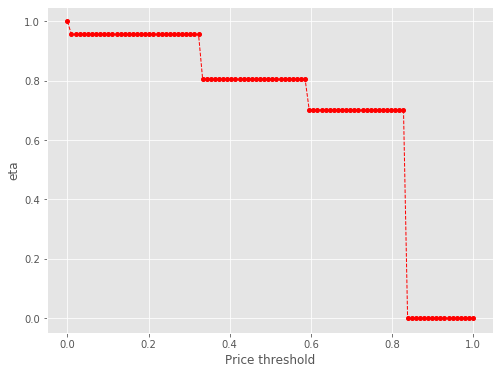

950 6
Number of cells with price above 75.0th percentile:  6


eta =  1.0
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  

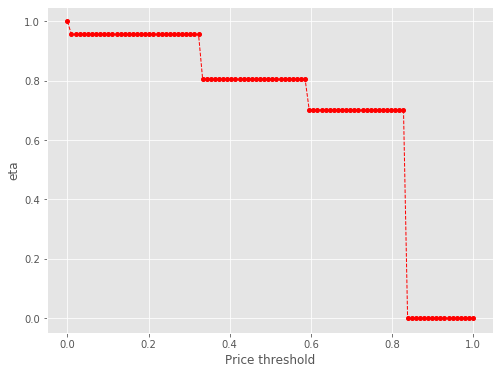

950 6
Number of cells with price above 76.0th percentile:  6


eta =  1.0
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  

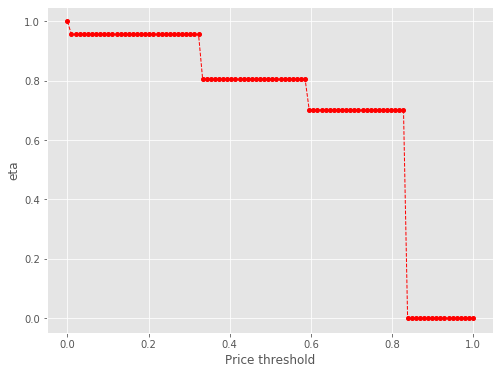

950 6
Number of cells with price above 77.0th percentile:  6


eta =  1.0
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  

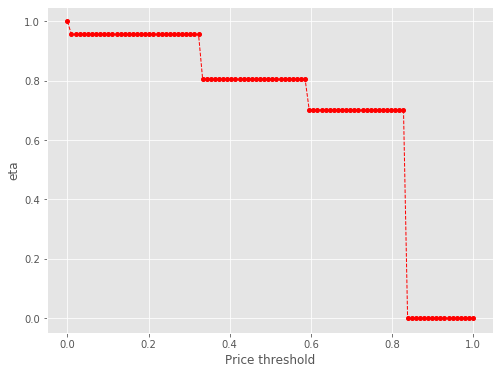

950 6
Number of cells with price above 78.0th percentile:  6


eta =  1.0
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  

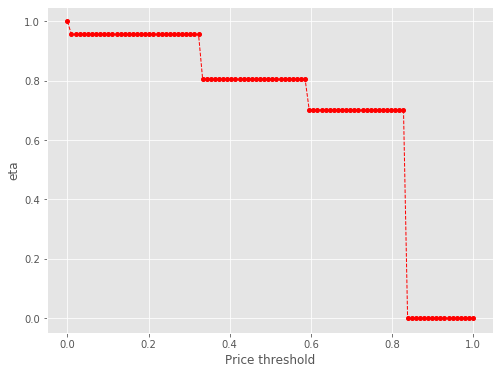

950 6
Number of cells with price above 79.0th percentile:  6


eta =  1.0
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  

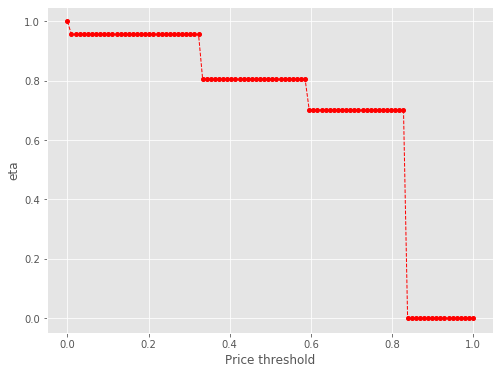

950 6
Number of cells with price above 80.0th percentile:  6


eta =  1.0
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  

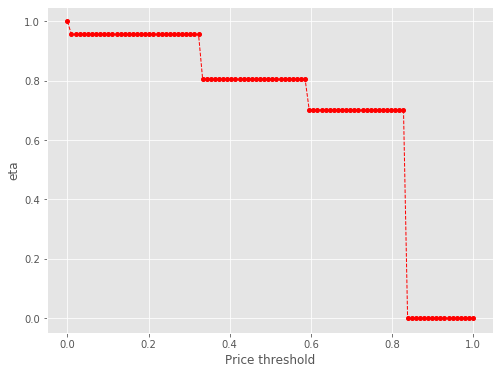

950 6
Number of cells with price above 81.0th percentile:  6


eta =  1.0
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.9565358499364182
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  0.805341880942653
eta =  

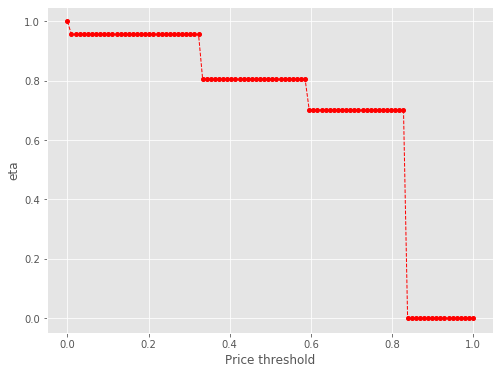

950 5
Number of cells with price above 82.0th percentile:  5


eta =  1.0
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
e

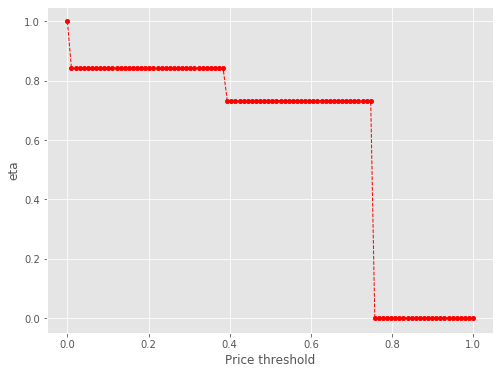

950 5
Number of cells with price above 83.0th percentile:  5


eta =  1.0
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
e

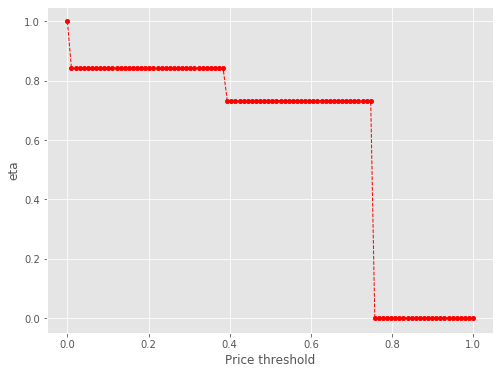

950 5
Number of cells with price above 84.00000000000001th percentile:  5


eta =  1.0
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
e

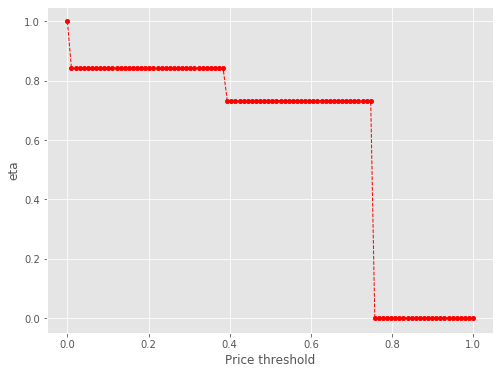

950 5
Number of cells with price above 85.0th percentile:  5


eta =  1.0
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
e

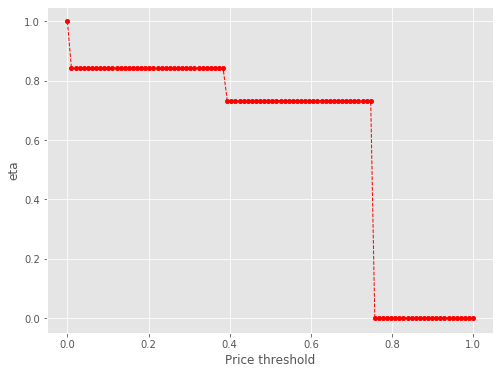

950 5
Number of cells with price above 86.0th percentile:  5


eta =  1.0
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
e

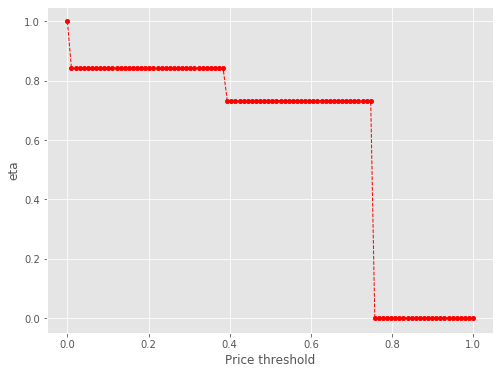

950 5
Number of cells with price above 87.0th percentile:  5


eta =  1.0
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
eta =  0.8419359096642167
e

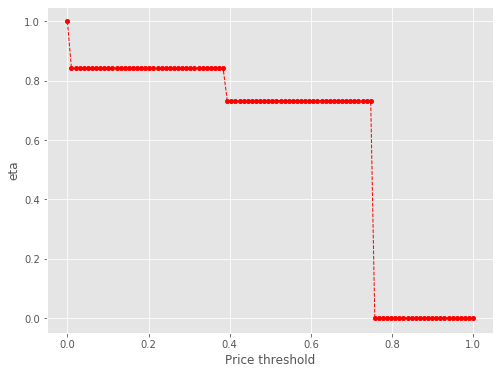

950 4
Number of cells with price above 88.0th percentile:  4


eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta = 

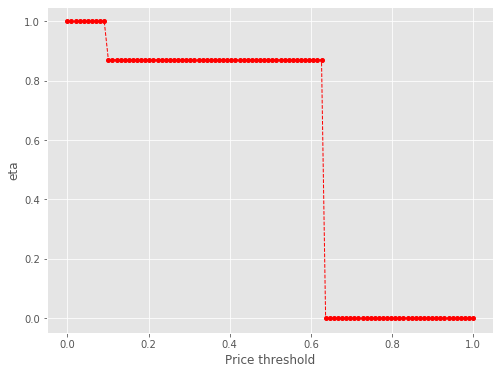

950 4
Number of cells with price above 89.0th percentile:  4


eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta = 

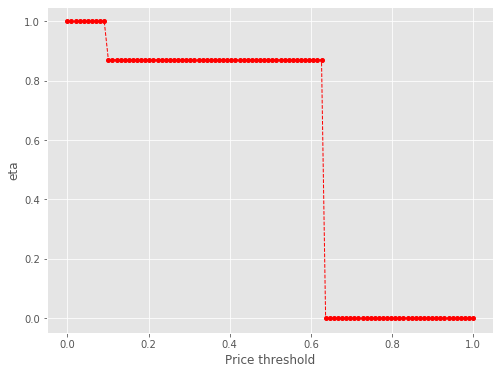

950 4
Number of cells with price above 90.0th percentile:  4


eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta = 

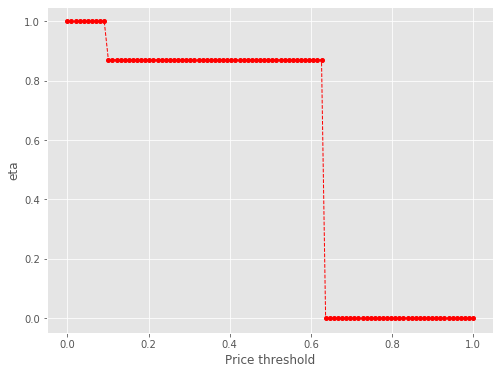

950 4
Number of cells with price above 91.0th percentile:  4


eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta = 

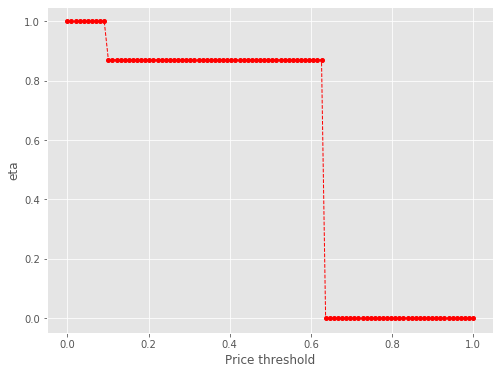

950 3
Number of cells with price above 92.0th percentile:  3


eta =  1.0
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
eta =  0.8708528682336021
e

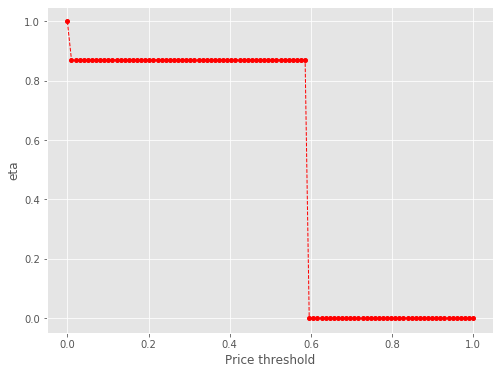

950 2
Number of cells with price above 93.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

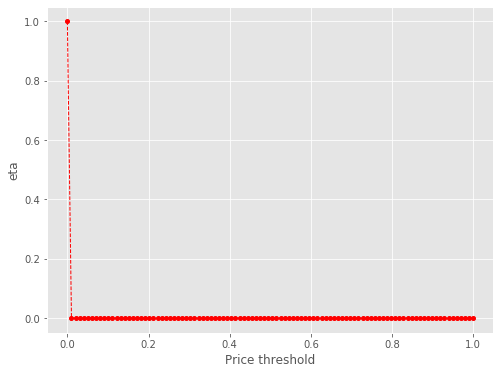

950 2
Number of cells with price above 94.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

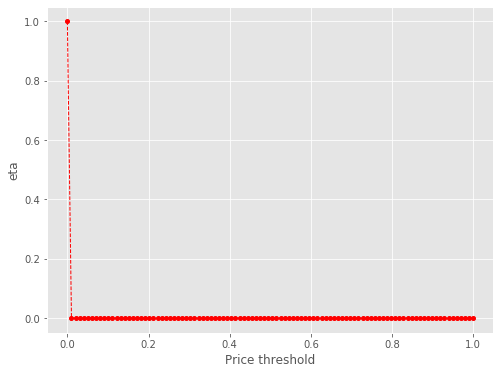

950 2
Number of cells with price above 95.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

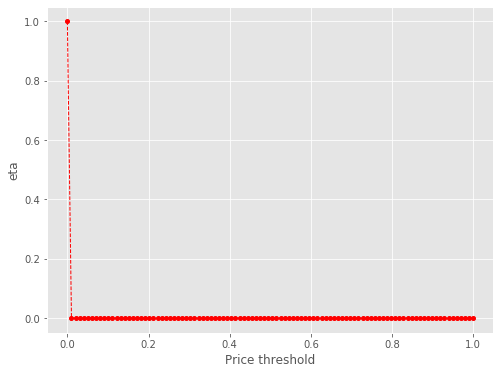

950 2
Number of cells with price above 96.00000000000001th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

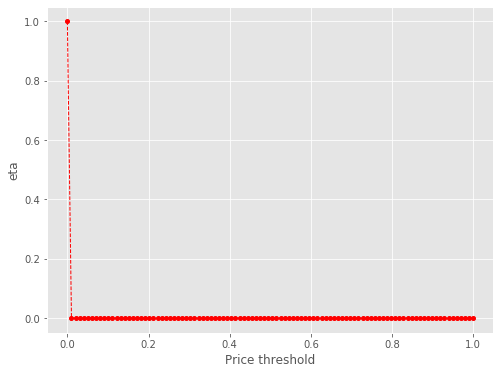

950 1
Number of cells with price above 97.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning:

invalid value encountered in true_divide



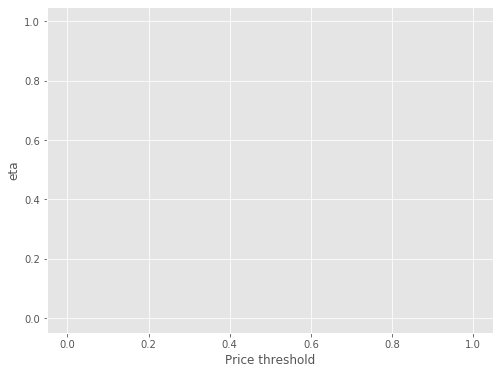

950 1
Number of cells with price above 98.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

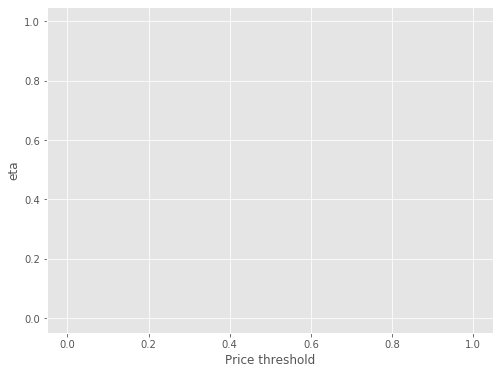

950 1
Number of cells with price above 99.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

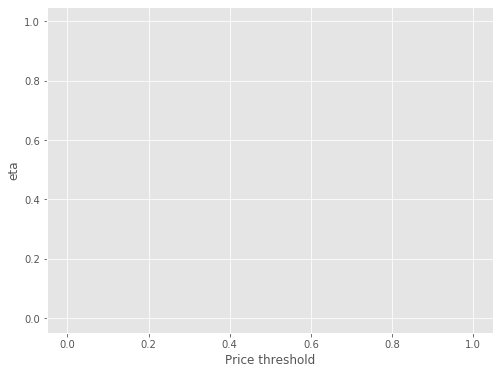

950 1
Number of cells with price above 100.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

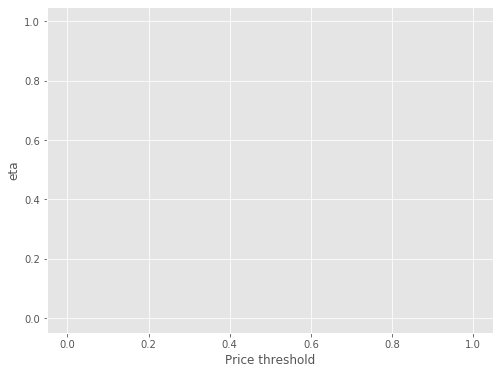


time: 1min 8s


In [27]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
#keys = np.array(keys)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_2d = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    etas = []
    lval = np.linspace(min(vals_cut), max(vals_cut), 100)
    for k in tqdm_notebook(lval):
        loubar_keys = keys[vals_cut>=k]
        dist_mat = mat[keys.reshape(-1,1), keys]

        total_dist = dist_mat.sum()
        dist_corr = dist_mat[dist_mat>0]

        loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

        loubar_dist = loubar_dist_mat.sum()

        loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
        eta = loubar_dist_corr.mean()/dist_corr.mean()
        etas.append(eta)
        print('eta = ', eta)
    etas_array = np.array(etas)
    etas_array = np.where(np.isnan(etas_array), 0, etas_array)
    lval = (lval - lval.min())/(lval - lval.min()).max()
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(lval, etas_array, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
    plt.xlabel("Price threshold")
    plt.ylabel("eta")
    plt.show()
    etas_2d.append(etas)
etas_2d = np.array(etas_2d)
etas_2d = np.where(np.isnan(etas_2d), 0, etas_2d)
lval = lval/lval.max()

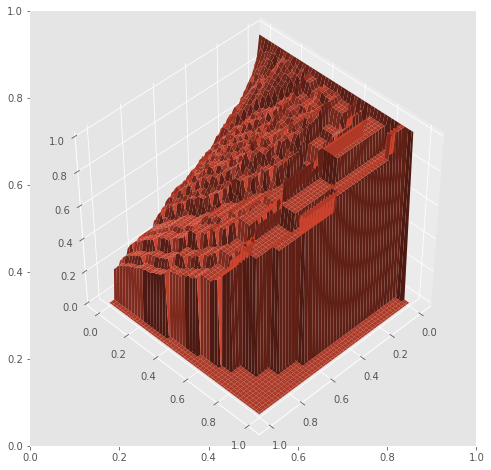

time: 1.29 s


In [28]:
X,Y = np.meshgrid(np.linspace(0,1, 100),np.linspace(0,1, 100))
etas_surface = etas_2d
fig, ax = plt.subplots(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot a 3D surface
ax.plot_surface(X, Y, etas_surface)
ax.view_init(45, 45)
plt.show()

In [29]:
pickle_in = open("etas_surface_dict.pickle","rb")
etas_surface_dict = pickle.load(pickle_in)
#etas_surface_dict = {}
etas_surface_dict['Bologna'] = etas_surface


pickle_out = open("etas_surface_dict.pickle","wb")
pickle.dump(etas_surface_dict, pickle_out)
pickle_out.close()

etas_surface_dict

{'NY': array([[1.        , 0.40697941, 0.38848337, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.95418349, 0.92471336, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.96911482, 0.94572765, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 'Boston': array([[1.        , 0.49308111, 0.46754658, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.94621367, 0.92299712, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.97340556, 0.95206791, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.       

time: 18 ms


950 67
Number of cells with price above 5th percentile:  67
total number of cells:  950
number of cells within urban airbnb territory:  67



Mean travel times in minutes:  8.736071807628523


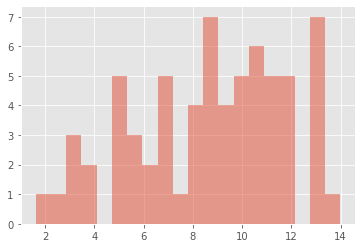

time: 4.45 s


In [31]:
from tqdm import tqdm_notebook

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

print('total number of cells: ', len(polylist))

times_names = ['times_{}'.format(c) for c in range(1, len(centers)+1)]
times_dict = {name:[] for name in times_names}

plist = poly_prices[poly_prices.index.isin(keys)].geometry.tolist()
print('number of cells within urban airbnb territory: ', len(plist))
for poly in tqdm_notebook(plist):
    origin = ox.get_nearest_node(G, poly.centroid.coords[0][::-1])
    dists_to_centers = []
    for node, target in centers.items():
        try:
            if origin!=target:
                path = nx.shortest_path(G, origin, target, weight='length')
                edges = [ tuple( path[i:i+2] ) for i in range( len(path) - 1 ) ]
                dist = np.sum([G.get_edge_data(*edge)[0]['length'] for edge in edges])
                dists_to_centers.append(dist)
        except:
            pass
    if len(dists_to_centers) != 0:
        dists_to_centers = sorted(dists_to_centers)
        #print('distance list length equal to # of centers: ', len(dists_to_centers)==len(centers))
        if len(dists_to_centers)==len(centers):
            for n, dist in enumerate(dists_to_centers):
                time = (dist/3)/60
                times_dict['times_{}'.format(n+1)].append(time)
                #print(times_dict['times_{}'.format(n+1)][-1])
        else:
            print('Distance list length NOT equal to # of centers')

#print(distances_dict)
for center in range(1, len(centers)+1):
    print("Mean travel times in minutes: ", np.mean(times_dict['times_{}'.format(center)]))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=0.5)
plt.show()

Mean travel times in minutes:  8.736071807628523


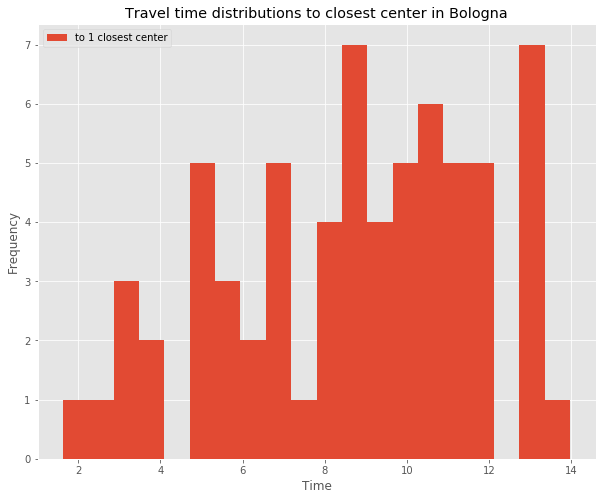

time: 296 ms


In [32]:
for center in range(1, len(centers)+1):
    times_dict['times_{}'.format(center)] = np.array(times_dict['times_{}'.format(center)])
    
for center in range(1, len(centers)+1):
    print("Mean travel times in minutes: ", np.mean(times_dict['times_{}'.format(center)]))

fig, ax = plt.subplots(figsize=(10,8))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=1, label='to {} closest center'.format(center))
plt.title('Travel time distributions to closest center in Bologna')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [33]:
pickle_in = open("City_Accessibility.pickle","rb")
access_dict = pickle.load(pickle_in)
#access_dict = {}
access_dict['Bologna'] = times_dict


pickle_out = open("City_Accessibility.pickle","wb")
pickle.dump(access_dict, pickle_out)
pickle_out.close()

access_dict

{'Paris': {'times_1': array([ 4.73219737,  4.40047807,  7.81577632,  7.07926754,  6.7129386 ,
          7.48037281, 10.85755263,  8.41227193, 14.20045614, 15.15502193,
         16.00692982, 15.80582895, 14.35941228, 14.10681579, 12.26687281,
         13.89203947, 14.31310965, 15.99389474, 16.77728947, 17.82112281,
         20.19769737, 20.40849561, 21.93033333, 22.03087719, 20.6584386 ,
         20.62538596, 19.53197368, 20.61141228, 21.70609211, 23.22407018,
         21.70395614, 23.12607456, 22.79396053, 23.95434211, 21.49400439,
         21.55605702, 22.35374123, 22.36948246, 22.44162719, 21.54410965,
         21.93589912, 21.86757456, 21.86757456, 21.41060088, 21.92571491,
         22.93862281, 23.57200877, 25.13889474, 24.49192982, 26.04400877,
         26.815     , 38.90660088, 38.56507018, 37.89241228, 36.57546491,
         29.87379386, 27.54254825, 25.54755702, 26.98263158, 25.76562281,
         25.03485526, 25.37799123, 25.69687719, 26.07382018, 23.81846491,
         24.034649

time: 523 ms


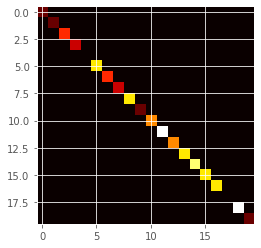

time: 139 ms


In [34]:
x = times_dict['times_{}'.format(1)]
#y = times_dict['times_{}'.format(2)]
#c_xy = np.histogram2d(x, y, 20)[0]
c_xx = np.histogram2d(x, x, 20)[0]
plt.imshow(c_xx, cmap='hot', interpolation='nearest')
plt.show()

In [35]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

mi_list = []
for center in range(1, len(centers)+1):
    mi_list.append(times_dict['times_{}'.format(center)])

mis = []
for pair in combinations_with_replacement(mi_list, 2):
    MI = calc_MI(pair[0], pair[1], 20)
    print(MI)
    mis.append(MI)
mis = np.array(mis)
avg_mi = np.mean(mis)
print('average mutual information = ', avg_mi)

2.7317991260148045
average mutual information =  2.7317991260148045
time: 7 ms


In [36]:
pickle_in = open("Time_distribution_mutual_information.pickle","rb")
MI_dict = pickle.load(pickle_in)
#MI_dict = {}
MI_dict['Bologna'] = avg_mi


pickle_out = open("Time_distribution_mutual_information.pickle","wb")
pickle.dump(MI_dict, pickle_out)
pickle_out.close()

MI_dict

{'Beijing': 1.629373608642793,
 'Florence': 2.0836399429599792,
 'Palermo': 1.8596013030930105,
 'Los_Angeles': 1.5602500680599918,
 'Moscow': 1.5631970905638934,
 'Porto': 1.6277816420571996,
 'Prague': 2.176480497902222,
 'Reykjavik': 1.3730161847793374,
 'Riga': 2.240374487910287,
 'Rome': 1.6095563575725969,
 'Seoul': 1.2910685865906735,
 'Siena': 2.7660068415344448,
 'Sydney': 1.2791891753795948,
 'Tallin': 2.3884073435187867,
 'Treviso': 2.631909071373147,
 'Valencia': 2.1872520197930965,
 'Venezia': 2.719891808939249,
 'Verona': 2.7080241467515376,
 'Vicenza': 2.6192607829416756,
 'Vienna': 1.4481542925032476,
 'Wellington': 2.1855226822614866,
 'Zurich': 2.462051055806955,
 'Aarhus': 2.2910468431831847,
 'Milan': 1.6107461389394335,
 'Busan': 1.903641833377143,
 'Barcelona': 1.6449937230537024,
 'Bologna': 2.7317991260148045,
 'Bremen': 1.9447717965210316,
 'Brno': 2.4300669174144036,
 'Budapest': 2.219525897631017,
 'Dublin': 1.830502368836079,
 'Boston': 1.1451275682586615,
 

time: 8 ms
